In [2]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import PermutedMNIST
from train import train
from model import MLP
import utils
import random
import matplotlib.pyplot as plt


task_number = 10
epochs_per_task =60
batch_size = 128
fisher_estimation_sample_size = 2048
weight_decay = 0
cuda=False






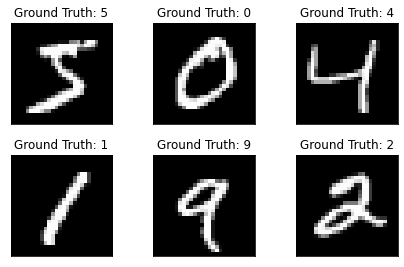

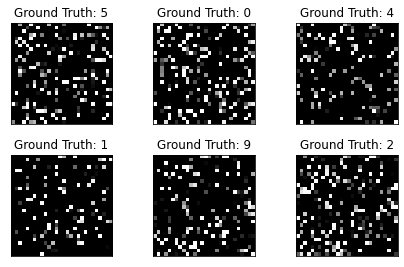

In [3]:
def imshow(img,labels):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i].view(28,28), cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
            
            
def get_permute_mnist():
   
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(task_number):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = False, permute_idx= idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()

#unpermuted data:
examples_unpermuted = enumerate(train_loader[0])

_, (example_data_unpermuted, example_targets_unpermuted) = next(examples_unpermuted)

imshow(example_data_unpermuted[:6], example_targets_unpermuted[:6])

#permuted data:
examples_permuted = enumerate(train_loader[1])

_, (example_data_permuted, example_targets_permuted) = next(examples_permuted)
imshow(example_data_permuted[:6], example_targets_permuted[:6])

In [4]:
#could also cut last 5 items which are ignored by early stopping
def loss_plot(x):
    num_epochs = 0
    for task in range(1, task_number+1):
        plt.plot(range(num_epochs+1, num_epochs + 1 + len(x[task])), x[task] )
        num_epochs+= len(x[task])
        
def accuracy_plot(x):
    total_epochs = len(x[1])
    for task in range(1, task_number + 1):
        plt.plot(range(total_epochs+1 - len(x[task]), total_epochs+1), x[task] )



In [5]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [6]:
#high learning rate, no dropout, no early stopping
hidden_size1=512
hidden_size2 = 256
lamda=1000
lr=5.e-2
hidden_dropout_prob=0
input_dropout_prob=0
early_stopping = False
consolidate = False

In [6]:
# prepare the model.
mlp_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_no_dropout_no_earlystopping)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout.cuda()


In [7]:
# run the standard experiment.
(standard_prec_no_dropout_no_earlystopping, 
 standard_total_loss_no_dropout_no_earlystopping,
 standard_ce_loss_no_dropout_no_earlystopping,
 standard_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4413 / ewc: 0.0 / total: 0.4413: : 469it [00:06, 75.58it/s] 
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3643 / ewc: 0.0 / total: 0.3643: : 469it [00:05, 79.02it/s]  
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3229 / ewc: 0.0 / total: 0.3229: : 469it [00:06, 69.84it/s]  
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2933 / ewc: 0.0 / total: 0.2933: : 469it [00:06, 71.79it/s]  
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2684 / ewc: 0.0 / total: 0.2684: : 469it [00:05, 82.44it/s]  
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2512 / ewc: 0.0 / total: 0.2512: : 469it [00:05, 81.76it/s] 
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | l

=> task: 2/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003507 / ewc: 0.0 / total: 0.003507: : 469it [00:05, 85.22it/s]  
=> task: 2/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003437 / ewc: 0.0 / total: 0.003437: : 469it [00:05, 85.26it/s]   
=> task: 2/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003201 / ewc: 0.0 / total: 0.003201: : 469it [00:05, 86.09it/s]   
=> task: 2/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003164 / ewc: 0.0 / total: 0.003164: : 469it [00:05, 86.23it/s]   
=> task: 2/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.002918 / ewc: 0.0 / total: 0.002918: : 469it [00:05, 86.44it/s]   
=> task: 2/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.002897 / ewc: 0.0 / total: 0.002897: : 469it [00:05, 86.37it/s]   
=> task: 2/10 | epoch: 51/60 | progress: [60032/60000] (100

=> task: 4/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.007408 / ewc: 0.0 / total: 0.007408: : 469it [00:05, 84.51it/s]   
=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.006574 / ewc: 0.0 / total: 0.006574: : 469it [00:05, 85.28it/s]  
=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.005869 / ewc: 0.0 / total: 0.005869: : 469it [00:05, 85.62it/s]   
=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.005264 / ewc: 0.0 / total: 0.005264: : 469it [00:05, 86.21it/s]   
=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.004796 / ewc: 0.0 / total: 0.004796: : 469it [00:05, 86.82it/s]  
=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.004435 / ewc: 0.0 / total: 0.004435: : 469it [00:05, 86.13it/s]   
=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%

=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06229 / ewc: 0.0 / total: 0.06229: : 469it [00:05, 85.24it/s]
=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05419 / ewc: 0.0 / total: 0.05419: : 469it [00:05, 85.86it/s]  
=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04348 / ewc: 0.0 / total: 0.04348: : 469it [00:05, 86.17it/s] 
=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03275 / ewc: 0.0 / total: 0.03275: : 469it [00:05, 86.88it/s]  
=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02486 / ewc: 0.0 / total: 0.02486: : 469it [00:05, 86.43it/s]  
=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01635 / ewc: 0.0 / total: 0.01635: : 469it [00:05, 87.26it/s] 
=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) 

=> task: 7/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001426 / ewc: 0.0 / total: 0.001426: : 469it [00:05, 85.92it/s]   
=> task: 7/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001382 / ewc: 0.0 / total: 0.001382: : 469it [00:05, 86.28it/s]  
=> task: 7/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001328 / ewc: 0.0 / total: 0.001328: : 469it [00:05, 85.67it/s]  
=> task: 7/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001298 / ewc: 0.0 / total: 0.001298: : 469it [00:05, 85.60it/s]   
=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2389 / ewc: 0.0 / total: 0.2389: : 469it [00:05, 87.09it/s]   
=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1957 / ewc: 0.0 / total: 0.1957: : 469it [00:05, 86.80it/s]   
=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | p

=> task: 9/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.002099 / ewc: 0.0 / total: 0.002099: : 469it [00:05, 85.20it/s]   
=> task: 9/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001984 / ewc: 0.0 / total: 0.001984: : 469it [00:05, 84.49it/s]   
=> task: 9/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001913 / ewc: 0.0 / total: 0.001913: : 469it [00:05, 85.94it/s]   
=> task: 9/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001862 / ewc: 0.0 / total: 0.001862: : 469it [00:05, 79.32it/s]  
=> task: 9/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001716 / ewc: 0.0 / total: 0.001716: : 469it [00:06, 73.30it/s]  
=> task: 9/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001721 / ewc: 0.0 / total: 0.001721: : 469it [00:05, 81.00it/s]  
=> task: 9/10 | epoch: 47/60 | progress: [60032/60000] (100%)

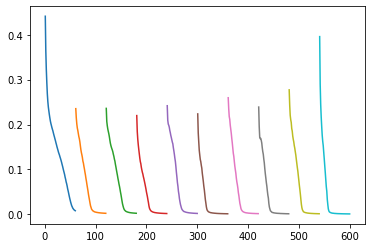

In [8]:
loss_plot(standard_total_loss_no_dropout_no_earlystopping)

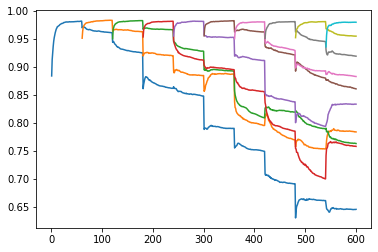

In [9]:
accuracy_plot(standard_prec_no_dropout_no_earlystopping)

In [10]:
mlp_consolidation_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_no_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_no_dropout_no_earlystopping, 
 ewc_total_loss_no_dropout_no_earlystopping, 
 ewc_ce_loss_no_dropout_no_earlystopping, 
 ewc_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_consolidation_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4476 / ewc: 0.0 / total: 0.4476: : 469it [00:05, 79.98it/s]  
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.368 / ewc: 0.0 / total: 0.368: : 469it [00:05, 83.12it/s]    
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3256 / ewc: 0.0 / total: 0.3256: : 469it [00:06, 73.39it/s]  
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2941 / ewc: 0.0 / total: 0.2941: : 469it [00:05, 80.38it/s]  
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2703 / ewc: 0.0 / total: 0.2703: : 469it [00:05, 78.73it/s]  
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2545 / ewc: 0.0 / total: 0.2545: : 469it [00:06, 75.57it/s] 
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2564 / ewc: 0.01894 / total: 0.2754: : 469it [00:08, 54.61it/s] 
=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.224 / ewc: 0.01684 / total: 0.2409: : 469it [00:07, 60.21it/s]   
=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2102 / ewc: 0.01556 / total: 0.2257: : 469it [00:07, 60.91it/s] 
=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1981 / ewc: 0.01467 / total: 0.2128: : 469it [00:07, 61.52it/s] 
=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1884 / ewc: 0.01402 / total: 0.2024: : 469it [00:07, 62.59it/s] 
=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1808 / ewc: 0.01352 / total: 0.1944: : 469it [00:07, 61.62it/s] 
=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (10

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2394 / ewc: 0.02055 / total: 0.26: : 469it [00:08, 57.29it/s]    
=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2201 / ewc: 0.01639 / total: 0.2365: : 469it [00:07, 60.91it/s] 
=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2097 / ewc: 0.01443 / total: 0.2241: : 469it [00:07, 61.04it/s] 
=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1963 / ewc: 0.01317 / total: 0.2094: : 469it [00:07, 61.47it/s] 
=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1846 / ewc: 0.01227 / total: 0.1969: : 469it [00:07, 61.60it/s] 
=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1787 / ewc: 0.01159 / total: 0.1903: : 469it [00:07, 61.57it/s] 
=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (10

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2176 / ewc: 0.02327 / total: 0.2409: : 469it [00:08, 56.32it/s] 
=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1904 / ewc: 0.01795 / total: 0.2084: : 469it [00:07, 59.65it/s] 
=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1809 / ewc: 0.01552 / total: 0.1965: : 469it [00:07, 60.99it/s] 
=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1701 / ewc: 0.014 / total: 0.1841: : 469it [00:07, 61.41it/s]   
=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.161 / ewc: 0.01299 / total: 0.174: : 469it [00:07, 62.88it/s]   
=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1531 / ewc: 0.0122 / total: 0.1653: : 469it [00:07, 61.46it/s]  
=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] (100

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2374 / ewc: 0.02002 / total: 0.2574: : 469it [00:08, 56.17it/s] 
=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1978 / ewc: 0.01514 / total: 0.2129: : 469it [00:07, 60.64it/s] 
=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1866 / ewc: 0.01304 / total: 0.1996: : 469it [00:07, 60.97it/s] 
=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1796 / ewc: 0.01178 / total: 0.1914: : 469it [00:07, 61.97it/s] 
=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.176 / ewc: 0.0109 / total: 0.1869: : 469it [00:07, 61.12it/s]   
=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1718 / ewc: 0.01022 / total: 0.182: : 469it [00:07, 64.71it/s]  
=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (100

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2178 / ewc: 0.0201 / total: 0.2379: : 469it [00:08, 56.56it/s]   
=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2159 / ewc: 0.01618 / total: 0.2321: : 469it [00:07, 64.58it/s] 
=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2144 / ewc: 0.01406 / total: 0.2285: : 469it [00:07, 61.23it/s] 
=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2029 / ewc: 0.01265 / total: 0.2156: : 469it [00:07, 61.25it/s] 
=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1882 / ewc: 0.0117 / total: 0.1999: : 469it [00:07, 61.71it/s]  
=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.172 / ewc: 0.0109 / total: 0.1829: : 469it [00:07, 61.78it/s]   
=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (10

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2453 / ewc: 0.01735 / total: 0.2626: : 469it [00:08, 56.33it/s] 
=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2078 / ewc: 0.01366 / total: 0.2214: : 469it [00:07, 61.14it/s] 
=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.172 / ewc: 0.01183 / total: 0.1838: : 469it [00:07, 61.18it/s]  
=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1526 / ewc: 0.01066 / total: 0.1633: : 469it [00:07, 60.90it/s] 
=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1468 / ewc: 0.009829 / total: 0.1567: : 469it [00:07, 61.03it/s] 
=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1374 / ewc: 0.009176 / total: 0.1466: : 469it [00:07, 63.10it/s] 
=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (1

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2499 / ewc: 0.0163 / total: 0.2662: : 469it [00:08, 57.10it/s]  
=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2224 / ewc: 0.01338 / total: 0.2358: : 469it [00:07, 60.08it/s] 
=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2028 / ewc: 0.01179 / total: 0.2146: : 469it [00:07, 60.04it/s] 
=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1886 / ewc: 0.01068 / total: 0.1992: : 469it [00:07, 60.86it/s] 
=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1775 / ewc: 0.009861 / total: 0.1874: : 469it [00:07, 60.91it/s] 
=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1688 / ewc: 0.009193 / total: 0.178: : 469it [00:07, 60.91it/s]  
=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (1

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2441 / ewc: 0.01674 / total: 0.2609: : 469it [00:08, 56.03it/s]  
=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2015 / ewc: 0.01335 / total: 0.2148: : 469it [00:07, 61.73it/s]  
=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1772 / ewc: 0.01166 / total: 0.1888: : 469it [00:07, 60.01it/s]  
=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1647 / ewc: 0.01057 / total: 0.1753: : 469it [00:07, 59.66it/s]  
=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1502 / ewc: 0.009752 / total: 0.16: : 469it [00:07, 59.86it/s]   
=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1368 / ewc: 0.009076 / total: 0.1458: : 469it [00:07, 59.37it/s] 
=> task: 9/10 | epoch: 7/60 | progress: [60032/60000

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2253 / ewc: 0.0127 / total: 0.238: : 469it [00:08, 56.63it/s]   
=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1907 / ewc: 0.01053 / total: 0.2012: : 469it [00:07, 61.07it/s] 
=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1741 / ewc: 0.009367 / total: 0.1834: : 469it [00:07, 61.08it/s] 
=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1649 / ewc: 0.00858 / total: 0.1735: : 469it [00:07, 63.86it/s]  
=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1612 / ewc: 0.007976 / total: 0.1692: : 469it [00:08, 58.36it/s] 
=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1587 / ewc: 0.007494 / total: 0.1662: : 469it [00:07, 60.09it/s] 
=> task: 10/10 | epoch: 7/60 | progress: [60032/

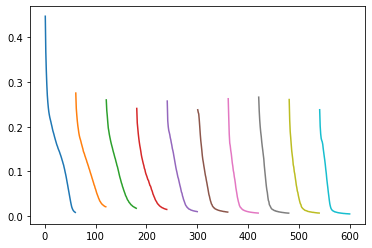

In [11]:
loss_plot(ewc_total_loss_no_dropout_no_earlystopping)

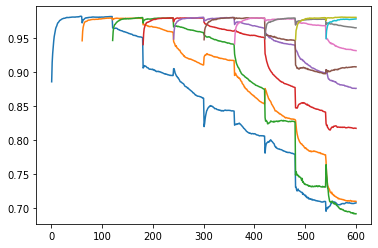

In [12]:
accuracy_plot(ewc_prec_no_dropout_no_earlystopping)

In [7]:
#high learning rate, dropout, no early stopping
hidden_dropout_prob = 0.5
input_dropout_prob = 0.2

In [14]:
# prepare the model.
mlp_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_dropout_no_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_no_earlystopping,
 standard_total_loss_dropout_no_earlystopping,
 standard_ce_loss_dropout_no_earlystopping,
 standard_ewc_loss_dropout_no_earlystopping) = train(
    mlp_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.5158 / ewc: 0.0 / total: 0.5158: : 469it [00:05, 80.27it/s]
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4231 / ewc: 0.0 / total: 0.4231: : 469it [00:05, 81.98it/s] 
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3815 / ewc: 0.0 / total: 0.3815: : 469it [00:05, 81.14it/s]  
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2811 / ewc: 0.0 / total: 0.2811: : 469it [00:05, 81.35it/s]  
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2458 / ewc: 0.0 / total: 0.2458: : 469it [00:05, 81.71it/s]  
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2472 / ewc: 0.0 / total: 0.2472: : 469it [00:05, 89.53it/s]   
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9583 | 

=> task: 2/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02264 / ewc: 0.0 / total: 0.02264: : 469it [00:05, 81.39it/s] 
=> task: 2/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04668 / ewc: 0.0 / total: 0.04668: : 469it [00:05, 81.42it/s] 
=> task: 2/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.009893 / ewc: 0.0 / total: 0.009893: : 469it [00:05, 81.78it/s]  
=> task: 2/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.02457 / ewc: 0.0 / total: 0.02457: : 469it [00:05, 82.12it/s] 
=> task: 2/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03715 / ewc: 0.0 / total: 0.03715: : 469it [00:05, 81.33it/s] 
=> task: 2/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02064 / ewc: 0.0 / total: 0.02064: : 469it [00:05, 82.45it/s] 
=> task: 2/10 | epoch: 52/60 | progress: [60032/60000] (100%) | 

=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0499 / ewc: 0.0 / total: 0.0499: : 469it [00:05, 81.33it/s]   
=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.03587 / ewc: 0.0 / total: 0.03587: : 469it [00:05, 81.22it/s] 
=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04412 / ewc: 0.0 / total: 0.04412: : 469it [00:05, 81.61it/s]
=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1226 / ewc: 0.0 / total: 0.1226: : 469it [00:05, 81.55it/s]   
=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1131 / ewc: 0.0 / total: 0.1131: : 469it [00:05, 82.11it/s]   
=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03481 / ewc: 0.0 / total: 0.03481: : 469it [00:05, 81.12it/s] 
=> task: 4/10 | epoch: 36/60 | progress: [60032/60000] (100%) | p

=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1493 / ewc: 0.0 / total: 0.1493: : 469it [00:05, 81.68it/s]   
=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1516 / ewc: 0.0 / total: 0.1516: : 469it [00:05, 81.82it/s] 
=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0862 / ewc: 0.0 / total: 0.0862: : 469it [00:05, 81.12it/s]  
=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1445 / ewc: 0.0 / total: 0.1445: : 469it [00:05, 80.69it/s]   
=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1627 / ewc: 0.0 / total: 0.1627: : 469it [00:05, 82.12it/s]  
=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1361 / ewc: 0.0 / total: 0.1361: : 469it [00:05, 81.72it/s]   
=> task: 6/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec

=> task: 7/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.002039 / ewc: 0.0 / total: 0.002039: : 469it [00:05, 82.27it/s]  
=> task: 7/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003294 / ewc: 0.0 / total: 0.003294: : 469it [00:05, 81.58it/s]  
=> task: 7/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.00246 / ewc: 0.0 / total: 0.00246: : 469it [00:05, 81.29it/s]    
=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3864 / ewc: 0.0 / total: 0.3864: : 469it [00:05, 81.72it/s]  
=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2527 / ewc: 0.0 / total: 0.2527: : 469it [00:05, 82.37it/s] 
=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.3078 / ewc: 0.0 / total: 0.3078: : 469it [00:05, 82.23it/s] 
=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9

=> task: 9/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1029 / ewc: 0.0 / total: 0.1029: : 469it [00:05, 81.92it/s]   
=> task: 9/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.06104 / ewc: 0.0 / total: 0.06104: : 469it [00:05, 82.06it/s] 
=> task: 9/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0952 / ewc: 0.0 / total: 0.0952: : 469it [00:05, 82.43it/s]   
=> task: 9/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01969 / ewc: 0.0 / total: 0.01969: : 469it [00:05, 81.86it/s] 
=> task: 9/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03724 / ewc: 0.0 / total: 0.03724: : 469it [00:05, 80.25it/s] 
=> task: 9/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05124 / ewc: 0.0 / total: 0.05124: : 469it [00:05, 78.51it/s] 
=> task: 9/10 | epoch: 48/60 | progress: [60032/60000] (100%) | 

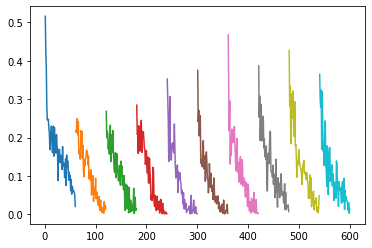

In [15]:
loss_plot(standard_total_loss_dropout_no_earlystopping)

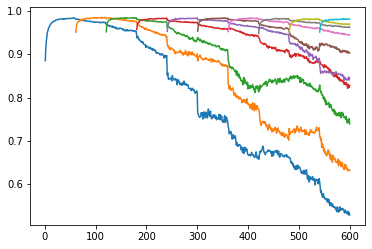

In [16]:
accuracy_plot(standard_prec_dropout_no_earlystopping)

In [19]:
mlp_consolidation_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_no_earlystopping, 
 ewc_total_loss_dropout_no_earlystopping, 
 ewc_ce_loss_dropout_no_earlystopping, 
 ewc_ewc_loss_dropout_no_earlystopping) =train(
    mlp_consolidation_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.5005 / ewc: 0.0 / total: 0.5005: : 469it [00:07, 66.42it/s]
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.8229 | loss => ce: 0.4266 / ewc: 0.0 / total: 0.4266: : 469it [00:06, 78.03it/s] 
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3978 / ewc: 0.0 / total: 0.3978: : 469it [00:06, 71.63it/s]  
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2378 / ewc: 0.0 / total: 0.2378: : 469it [00:07, 64.65it/s]  
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2477 / ewc: 0.0 / total: 0.2477: : 469it [00:05, 84.19it/s]  
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.256 / ewc: 0.0 / total: 0.256: : 469it [00:06, 78.02it/s]    
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | l

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2778 / ewc: 0.02548 / total: 0.3033: : 469it [00:08, 53.45it/s] 
=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1768 / ewc: 0.02074 / total: 0.1975: : 469it [00:08, 56.42it/s]  
=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1911 / ewc: 0.01841 / total: 0.2095: : 469it [00:08, 56.92it/s]  
=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1768 / ewc: 0.01714 / total: 0.194: : 469it [00:08, 57.55it/s]   
=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1717 / ewc: 0.01611 / total: 0.1878: : 469it [00:07, 58.76it/s]  
=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1756 / ewc: 0.01523 / total: 0.1908: : 469it [00:08, 57.65it/s] 
=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2666 / ewc: 0.02701 / total: 0.2936: : 469it [00:08, 54.27it/s] 
=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2522 / ewc: 0.01969 / total: 0.2718: : 469it [00:08, 58.50it/s]  
=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2304 / ewc: 0.01725 / total: 0.2476: : 469it [00:08, 54.10it/s] 
=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2837 / ewc: 0.0156 / total: 0.2993: : 469it [00:08, 55.63it/s]  
=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2486 / ewc: 0.01401 / total: 0.2626: : 469it [00:08, 57.45it/s] 
=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2322 / ewc: 0.01309 / total: 0.2453: : 469it [00:08, 57.38it/s] 
=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (10

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2956 / ewc: 0.02643 / total: 0.3221: : 469it [00:09, 51.95it/s] 
=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2512 / ewc: 0.0199 / total: 0.2711: : 469it [00:08, 58.38it/s]   
=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1853 / ewc: 0.0175 / total: 0.2028: : 469it [00:08, 56.48it/s]   
=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2163 / ewc: 0.01539 / total: 0.2317: : 469it [00:08, 57.56it/s]  
=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2661 / ewc: 0.01448 / total: 0.2806: : 469it [00:08, 57.86it/s]  
=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1626 / ewc: 0.01302 / total: 0.1756: : 469it [00:08, 57.68it/s] 
=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2948 / ewc: 0.02657 / total: 0.3214: : 469it [00:08, 53.49it/s] 
=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2423 / ewc: 0.01979 / total: 0.2621: : 469it [00:08, 58.22it/s]  
=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.207 / ewc: 0.01676 / total: 0.2238: : 469it [00:07, 58.65it/s]   
=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1816 / ewc: 0.01495 / total: 0.1966: : 469it [00:08, 58.55it/s] 
=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2395 / ewc: 0.01386 / total: 0.2534: : 469it [00:08, 57.95it/s] 
=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.276 / ewc: 0.01269 / total: 0.2887: : 469it [00:08, 58.43it/s]   
=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1814 / ewc: 0.02749 / total: 0.2089: : 469it [00:08, 53.23it/s] 
=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1639 / ewc: 0.02038 / total: 0.1843: : 469it [00:08, 56.86it/s]  
=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1242 / ewc: 0.01757 / total: 0.1418: : 469it [00:08, 55.38it/s] 
=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2378 / ewc: 0.01565 / total: 0.2534: : 469it [00:08, 57.75it/s] 
=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1596 / ewc: 0.01458 / total: 0.1742: : 469it [00:08, 57.66it/s]  
=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2037 / ewc: 0.01327 / total: 0.217: : 469it [00:08, 57.67it/s]   
=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.333 / ewc: 0.0249 / total: 0.3579: : 469it [00:08, 53.36it/s]   
=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3137 / ewc: 0.01937 / total: 0.3331: : 469it [00:07, 58.90it/s] 
=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3169 / ewc: 0.0167 / total: 0.3336: : 469it [00:08, 56.57it/s]   
=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2679 / ewc: 0.01489 / total: 0.2828: : 469it [00:08, 57.49it/s]  
=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2632 / ewc: 0.01388 / total: 0.2771: : 469it [00:08, 57.69it/s] 
=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3404 / ewc: 0.01287 / total: 0.3533: : 469it [00:08, 57.34it/s] 
=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (1

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2811 / ewc: 0.02233 / total: 0.3034: : 469it [00:08, 53.65it/s] 
=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2283 / ewc: 0.01692 / total: 0.2452: : 469it [00:08, 58.14it/s] 
=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1963 / ewc: 0.01409 / total: 0.2104: : 469it [00:08, 58.15it/s] 
=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1676 / ewc: 0.0129 / total: 0.1805: : 469it [00:07, 58.99it/s]   
=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2494 / ewc: 0.01224 / total: 0.2616: : 469it [00:08, 58.31it/s] 
=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1568 / ewc: 0.01164 / total: 0.1685: : 469it [00:08, 58.14it/s]  
=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (1

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.466 / ewc: 0.02395 / total: 0.49: : 469it [00:09, 51.35it/s]    
=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3364 / ewc: 0.01784 / total: 0.3542: : 469it [00:08, 56.31it/s]  
=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2039 / ewc: 0.01517 / total: 0.2191: : 469it [00:08, 54.68it/s] 
=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2305 / ewc: 0.01355 / total: 0.2441: : 469it [00:09, 51.66it/s]  
=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1918 / ewc: 0.01273 / total: 0.2045: : 469it [00:08, 52.34it/s]  
=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1605 / ewc: 0.0118 / total: 0.1723: : 469it [00:08, 55.37it/s]  
=> task: 9/10 | epoch: 7/60 | progress: [60032/60000] (

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3828 / ewc: 0.02144 / total: 0.4043: : 469it [00:08, 52.89it/s] 
=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.332 / ewc: 0.01608 / total: 0.348: : 469it [00:08, 56.98it/s]   
=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1987 / ewc: 0.0142 / total: 0.2129: : 469it [00:08, 57.54it/s]   
=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1931 / ewc: 0.01262 / total: 0.2057: : 469it [00:08, 57.33it/s]  
=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3347 / ewc: 0.01151 / total: 0.3462: : 469it [00:07, 61.57it/s] 
=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2213 / ewc: 0.01105 / total: 0.2323: : 469it [00:08, 57.69it/s]  
=> task: 10/10 | epoch: 7/60 | progress: [60032/6

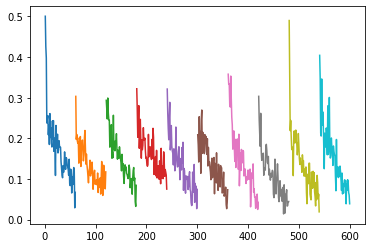

In [20]:
loss_plot(ewc_total_loss_dropout_no_earlystopping)

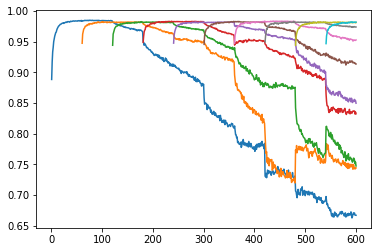

In [21]:
accuracy_plot(ewc_prec_dropout_no_earlystopping)

In [8]:
#dropout and early stopping
early_stopping = True

In [23]:
mlp_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_dropout_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_earlystopping, 
 standard_total_loss_dropout_earlystopping,
 standard_ce_loss_dropout_earlystopping,
 standard_ewc_loss_dropout_earlystopping) = train(
    mlp_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.5331 / ewc: 0.0 / total: 0.5331: : 469it [00:05, 78.66it/s] 


Validation loss decreased (inf --> 0.385261).  Saving model ...


=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.4279 / ewc: 0.0 / total: 0.4279: : 469it [00:05, 80.99it/s]  


Validation loss decreased (0.385261 --> 0.286879).  Saving model ...


=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3568 / ewc: 0.0 / total: 0.3568: : 469it [00:06, 77.67it/s]  


Validation loss decreased (0.286879 --> 0.234854).  Saving model ...


=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2864 / ewc: 0.0 / total: 0.2864: : 469it [00:06, 76.46it/s]  


Validation loss decreased (0.234854 --> 0.201252).  Saving model ...


=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3511 / ewc: 0.0 / total: 0.3511: : 469it [00:06, 73.49it/s]  


Validation loss decreased (0.201252 --> 0.170593).  Saving model ...


=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2396 / ewc: 0.0 / total: 0.2396: : 469it [00:06, 76.41it/s]  


Validation loss decreased (0.170593 --> 0.149144).  Saving model ...


=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2379 / ewc: 0.0 / total: 0.2379: : 469it [00:06, 75.36it/s]  


Validation loss decreased (0.149144 --> 0.135010).  Saving model ...


=> task: 1/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2313 / ewc: 0.0 / total: 0.2313: : 469it [00:06, 75.35it/s] 


Validation loss decreased (0.135010 --> 0.122349).  Saving model ...


=> task: 1/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2554 / ewc: 0.0 / total: 0.2554: : 469it [00:06, 74.19it/s]  


Validation loss decreased (0.122349 --> 0.112080).  Saving model ...


=> task: 1/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2102 / ewc: 0.0 / total: 0.2102: : 469it [00:05, 78.90it/s] 


Validation loss decreased (0.112080 --> 0.105060).  Saving model ...


=> task: 1/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2443 / ewc: 0.0 / total: 0.2443: : 469it [00:05, 86.20it/s]  


Validation loss decreased (0.105060 --> 0.097271).  Saving model ...


=> task: 1/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1998 / ewc: 0.0 / total: 0.1998: : 469it [00:06, 70.50it/s]   


Validation loss decreased (0.097271 --> 0.091994).  Saving model ...


=> task: 1/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2338 / ewc: 0.0 / total: 0.2338: : 469it [00:05, 78.60it/s] 


Validation loss decreased (0.091994 --> 0.088109).  Saving model ...


=> task: 1/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1895 / ewc: 0.0 / total: 0.1895: : 469it [00:06, 68.89it/s]  


Validation loss decreased (0.088109 --> 0.084124).  Saving model ...


=> task: 1/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1832 / ewc: 0.0 / total: 0.1832: : 469it [00:05, 79.29it/s]  


Validation loss decreased (0.084124 --> 0.081320).  Saving model ...


=> task: 1/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.202 / ewc: 0.0 / total: 0.202: : 469it [00:05, 79.52it/s]    


Validation loss decreased (0.081320 --> 0.077260).  Saving model ...


=> task: 1/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1789 / ewc: 0.0 / total: 0.1789: : 469it [00:05, 78.35it/s]  


Validation loss decreased (0.077260 --> 0.075834).  Saving model ...


=> task: 1/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.196 / ewc: 0.0 / total: 0.196: : 469it [00:05, 79.92it/s]    


Validation loss decreased (0.075834 --> 0.073449).  Saving model ...


=> task: 1/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1721 / ewc: 0.0 / total: 0.1721: : 469it [00:05, 78.47it/s] 


Validation loss decreased (0.073449 --> 0.070925).  Saving model ...


=> task: 1/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1963 / ewc: 0.0 / total: 0.1963: : 469it [00:06, 77.47it/s] 


Validation loss decreased (0.070925 --> 0.069594).  Saving model ...


=> task: 1/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1882 / ewc: 0.0 / total: 0.1882: : 469it [00:05, 79.95it/s]  


Validation loss decreased (0.069594 --> 0.068455).  Saving model ...


=> task: 1/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1991 / ewc: 0.0 / total: 0.1991: : 469it [00:05, 79.59it/s]  


Validation loss decreased (0.068455 --> 0.066818).  Saving model ...


=> task: 1/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2246 / ewc: 0.0 / total: 0.2246: : 469it [00:05, 80.74it/s]  


Validation loss decreased (0.066818 --> 0.066285).  Saving model ...


=> task: 1/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2058 / ewc: 0.0 / total: 0.2058: : 469it [00:05, 80.88it/s]  


Validation loss decreased (0.066285 --> 0.064438).  Saving model ...


=> task: 1/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1542 / ewc: 0.0 / total: 0.1542: : 469it [00:05, 81.97it/s]  


Validation loss decreased (0.064438 --> 0.063420).  Saving model ...


=> task: 1/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1322 / ewc: 0.0 / total: 0.1322: : 469it [00:06, 74.21it/s]  


Validation loss decreased (0.063420 --> 0.062350).  Saving model ...


=> task: 1/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1655 / ewc: 0.0 / total: 0.1655: : 469it [00:06, 74.41it/s] 


Validation loss decreased (0.062350 --> 0.062033).  Saving model ...


=> task: 1/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1586 / ewc: 0.0 / total: 0.1586: : 469it [00:05, 78.41it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1713 / ewc: 0.0 / total: 0.1713: : 469it [00:05, 80.48it/s] 


Validation loss decreased (0.062033 --> 0.061415).  Saving model ...


=> task: 1/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1249 / ewc: 0.0 / total: 0.1249: : 469it [00:05, 80.84it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.141 / ewc: 0.0 / total: 0.141: : 469it [00:05, 80.49it/s]   


Validation loss decreased (0.061415 --> 0.058526).  Saving model ...


=> task: 1/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09407 / ewc: 0.0 / total: 0.09407: : 469it [00:05, 80.83it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1582 / ewc: 0.0 / total: 0.1582: : 469it [00:05, 80.98it/s]   


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09493 / ewc: 0.0 / total: 0.09493: : 469it [00:05, 80.83it/s]


Validation loss decreased (0.058526 --> 0.057928).  Saving model ...


=> task: 1/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1243 / ewc: 0.0 / total: 0.1243: : 469it [00:05, 80.61it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1485 / ewc: 0.0 / total: 0.1485: : 469it [00:05, 80.65it/s]    


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1946 / ewc: 0.0 / total: 0.1946: : 469it [00:05, 81.27it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07627 / ewc: 0.0 / total: 0.07627: : 469it [00:05, 81.14it/s]


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1365 / ewc: 0.0 / total: 0.1365: : 469it [00:05, 80.72it/s]  


Validation loss decreased (0.057928 --> 0.057189).  Saving model ...


=> task: 1/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1197 / ewc: 0.0 / total: 0.1197: : 469it [00:05, 79.89it/s]  


Validation loss decreased (0.057189 --> 0.056583).  Saving model ...


=> task: 1/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1202 / ewc: 0.0 / total: 0.1202: : 469it [00:05, 80.15it/s]   


Validation loss decreased (0.056583 --> 0.056547).  Saving model ...


=> task: 1/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1295 / ewc: 0.0 / total: 0.1295: : 469it [00:05, 80.75it/s]  


Validation loss decreased (0.056547 --> 0.055971).  Saving model ...


=> task: 1/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1099 / ewc: 0.0 / total: 0.1099: : 469it [00:05, 80.92it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1456 / ewc: 0.0 / total: 0.1456: : 469it [00:05, 80.69it/s]  


Validation loss decreased (0.055971 --> 0.055694).  Saving model ...


=> task: 1/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.101 / ewc: 0.0 / total: 0.101: : 469it [00:05, 81.52it/s]     


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1394 / ewc: 0.0 / total: 0.1394: : 469it [00:05, 80.79it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1483 / ewc: 0.0 / total: 0.1483: : 469it [00:05, 80.63it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0675 / ewc: 0.0 / total: 0.0675: : 469it [00:05, 80.83it/s]   


Validation loss decreased (0.055694 --> 0.055516).  Saving model ...


=> task: 1/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09676 / ewc: 0.0 / total: 0.09676: : 469it [00:05, 80.64it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09324 / ewc: 0.0 / total: 0.09324: : 469it [00:05, 80.68it/s]


Validation loss decreased (0.055516 --> 0.055343).  Saving model ...


=> task: 1/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07559 / ewc: 0.0 / total: 0.07559: : 469it [00:05, 80.43it/s] 


Validation loss decreased (0.055343 --> 0.054787).  Saving model ...


=> task: 1/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09066 / ewc: 0.0 / total: 0.09066: : 469it [00:05, 82.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06138 / ewc: 0.0 / total: 0.06138: : 469it [00:05, 80.33it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0839 / ewc: 0.0 / total: 0.0839: : 469it [00:05, 81.00it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01693 / ewc: 0.0 / total: 0.01693: : 469it [00:05, 80.88it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08859 / ewc: 0.0 / total: 0.08859: : 469it [00:05, 80.83it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2291 / ewc: 0.0 / total: 0.2291: : 469it [00:06, 73.50it/s]  


Validation loss decreased (inf --> 0.156624).  Saving model ...


=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1558 / ewc: 0.0 / total: 0.1558: : 469it [00:06, 73.12it/s]  


Validation loss decreased (0.156624 --> 0.117077).  Saving model ...


=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2333 / ewc: 0.0 / total: 0.2333: : 469it [00:05, 80.57it/s] 


Validation loss decreased (0.117077 --> 0.097194).  Saving model ...


=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1824 / ewc: 0.0 / total: 0.1824: : 469it [00:05, 81.29it/s] 


Validation loss decreased (0.097194 --> 0.088923).  Saving model ...


=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.148 / ewc: 0.0 / total: 0.148: : 469it [00:05, 80.51it/s]   


Validation loss decreased (0.088923 --> 0.080951).  Saving model ...


=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1514 / ewc: 0.0 / total: 0.1514: : 469it [00:06, 75.88it/s]  


Validation loss decreased (0.080951 --> 0.075839).  Saving model ...


=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1199 / ewc: 0.0 / total: 0.1199: : 469it [00:05, 80.75it/s]  


Validation loss decreased (0.075839 --> 0.073807).  Saving model ...


=> task: 2/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1454 / ewc: 0.0 / total: 0.1454: : 469it [00:05, 80.23it/s] 


Validation loss decreased (0.073807 --> 0.068934).  Saving model ...


=> task: 2/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1215 / ewc: 0.0 / total: 0.1215: : 469it [00:05, 80.55it/s] 


Validation loss decreased (0.068934 --> 0.068042).  Saving model ...


=> task: 2/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1434 / ewc: 0.0 / total: 0.1434: : 469it [00:05, 80.33it/s] 


Validation loss decreased (0.068042 --> 0.065844).  Saving model ...


=> task: 2/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1546 / ewc: 0.0 / total: 0.1546: : 469it [00:05, 81.16it/s]  


Validation loss decreased (0.065844 --> 0.062233).  Saving model ...


=> task: 2/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1542 / ewc: 0.0 / total: 0.1542: : 469it [00:05, 78.98it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1421 / ewc: 0.0 / total: 0.1421: : 469it [00:06, 77.51it/s] 


Validation loss decreased (0.062233 --> 0.061549).  Saving model ...


=> task: 2/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1674 / ewc: 0.0 / total: 0.1674: : 469it [00:06, 77.58it/s] 


Validation loss decreased (0.061549 --> 0.061278).  Saving model ...


=> task: 2/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1009 / ewc: 0.0 / total: 0.1009: : 469it [00:06, 72.10it/s] 


Validation loss decreased (0.061278 --> 0.060230).  Saving model ...


=> task: 2/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1238 / ewc: 0.0 / total: 0.1238: : 469it [00:06, 76.78it/s] 


Validation loss decreased (0.060230 --> 0.057243).  Saving model ...


=> task: 2/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1055 / ewc: 0.0 / total: 0.1055: : 469it [00:06, 72.92it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1348 / ewc: 0.0 / total: 0.1348: : 469it [00:06, 70.16it/s] 


Validation loss decreased (0.057243 --> 0.057038).  Saving model ...


=> task: 2/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1196 / ewc: 0.0 / total: 0.1196: : 469it [00:06, 75.07it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1105 / ewc: 0.0 / total: 0.1105: : 469it [00:06, 78.08it/s] 


Validation loss decreased (0.057038 --> 0.055174).  Saving model ...


=> task: 2/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0954 / ewc: 0.0 / total: 0.0954: : 469it [00:06, 72.83it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1299 / ewc: 0.0 / total: 0.1299: : 469it [00:05, 78.77it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09743 / ewc: 0.0 / total: 0.09743: : 469it [00:05, 79.37it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1227 / ewc: 0.0 / total: 0.1227: : 469it [00:06, 77.38it/s]  


EarlyStopping counter: 4 out of 5


=> task: 2/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09468 / ewc: 0.0 / total: 0.09468: : 469it [00:06, 75.44it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3317 / ewc: 0.0 / total: 0.3317: : 469it [00:06, 78.02it/s]  


Validation loss decreased (inf --> 0.143756).  Saving model ...


=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2387 / ewc: 0.0 / total: 0.2387: : 469it [00:06, 72.22it/s]  


Validation loss decreased (0.143756 --> 0.107125).  Saving model ...


=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1971 / ewc: 0.0 / total: 0.1971: : 469it [00:05, 81.27it/s]  


Validation loss decreased (0.107125 --> 0.091478).  Saving model ...


=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2142 / ewc: 0.0 / total: 0.2142: : 469it [00:05, 80.55it/s] 


Validation loss decreased (0.091478 --> 0.086019).  Saving model ...


=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2319 / ewc: 0.0 / total: 0.2319: : 469it [00:05, 79.92it/s] 


Validation loss decreased (0.086019 --> 0.075286).  Saving model ...


=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1689 / ewc: 0.0 / total: 0.1689: : 469it [00:05, 81.44it/s] 


Validation loss decreased (0.075286 --> 0.073823).  Saving model ...


=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1353 / ewc: 0.0 / total: 0.1353: : 469it [00:05, 82.42it/s] 


Validation loss decreased (0.073823 --> 0.069694).  Saving model ...


=> task: 3/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.173 / ewc: 0.0 / total: 0.173: : 469it [00:05, 82.42it/s]    


Validation loss decreased (0.069694 --> 0.066211).  Saving model ...


=> task: 3/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1528 / ewc: 0.0 / total: 0.1528: : 469it [00:05, 81.97it/s] 


Validation loss decreased (0.066211 --> 0.063769).  Saving model ...


=> task: 3/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1867 / ewc: 0.0 / total: 0.1867: : 469it [00:05, 82.67it/s]  


Validation loss decreased (0.063769 --> 0.061980).  Saving model ...


=> task: 3/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1915 / ewc: 0.0 / total: 0.1915: : 469it [00:05, 81.87it/s] 


Validation loss decreased (0.061980 --> 0.060243).  Saving model ...


=> task: 3/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1928 / ewc: 0.0 / total: 0.1928: : 469it [00:05, 84.89it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1237 / ewc: 0.0 / total: 0.1237: : 469it [00:05, 82.90it/s]  


Validation loss decreased (0.060243 --> 0.059250).  Saving model ...


=> task: 3/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1865 / ewc: 0.0 / total: 0.1865: : 469it [00:05, 82.49it/s] 


Validation loss decreased (0.059250 --> 0.056682).  Saving model ...


=> task: 3/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1646 / ewc: 0.0 / total: 0.1646: : 469it [00:06, 69.43it/s]   


Validation loss decreased (0.056682 --> 0.056326).  Saving model ...


=> task: 3/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1122 / ewc: 0.0 / total: 0.1122: : 469it [00:05, 79.68it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1442 / ewc: 0.0 / total: 0.1442: : 469it [00:05, 82.19it/s]  


Validation loss decreased (0.056326 --> 0.055689).  Saving model ...


=> task: 3/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1739 / ewc: 0.0 / total: 0.1739: : 469it [00:05, 82.43it/s] 


Validation loss decreased (0.055689 --> 0.055589).  Saving model ...


=> task: 3/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1206 / ewc: 0.0 / total: 0.1206: : 469it [00:05, 81.29it/s]   


Validation loss decreased (0.055589 --> 0.054281).  Saving model ...


=> task: 3/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1212 / ewc: 0.0 / total: 0.1212: : 469it [00:05, 83.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.147 / ewc: 0.0 / total: 0.147: : 469it [00:05, 82.74it/s]    


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1478 / ewc: 0.0 / total: 0.1478: : 469it [00:05, 82.75it/s]   


Validation loss decreased (0.054281 --> 0.053096).  Saving model ...


=> task: 3/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.104 / ewc: 0.0 / total: 0.104: : 469it [00:05, 82.70it/s]     


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1162 / ewc: 0.0 / total: 0.1162: : 469it [00:05, 83.14it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1102 / ewc: 0.0 / total: 0.1102: : 469it [00:05, 82.30it/s]   


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09545 / ewc: 0.0 / total: 0.09545: : 469it [00:05, 83.15it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1242 / ewc: 0.0 / total: 0.1242: : 469it [00:05, 83.34it/s]   


Validation loss decreased (0.053096 --> 0.052961).  Saving model ...


=> task: 3/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.128 / ewc: 0.0 / total: 0.128: : 469it [00:05, 81.16it/s]     


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.114 / ewc: 0.0 / total: 0.114: : 469it [00:05, 82.63it/s]     


Validation loss decreased (0.052961 --> 0.052732).  Saving model ...


=> task: 3/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1208 / ewc: 0.0 / total: 0.1208: : 469it [00:05, 82.82it/s]   


Validation loss decreased (0.052732 --> 0.051780).  Saving model ...


=> task: 3/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0832 / ewc: 0.0 / total: 0.0832: : 469it [00:05, 82.35it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1101 / ewc: 0.0 / total: 0.1101: : 469it [00:05, 82.67it/s]   


Validation loss decreased (0.051780 --> 0.051639).  Saving model ...


=> task: 3/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09463 / ewc: 0.0 / total: 0.09463: : 469it [00:05, 82.60it/s] 


Validation loss decreased (0.051639 --> 0.050711).  Saving model ...


=> task: 3/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05969 / ewc: 0.0 / total: 0.05969: : 469it [00:05, 82.24it/s]


Validation loss decreased (0.050711 --> 0.048739).  Saving model ...


=> task: 3/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08112 / ewc: 0.0 / total: 0.08112: : 469it [00:05, 82.71it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08308 / ewc: 0.0 / total: 0.08308: : 469it [00:05, 83.25it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04601 / ewc: 0.0 / total: 0.04601: : 469it [00:05, 82.62it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05629 / ewc: 0.0 / total: 0.05629: : 469it [00:05, 82.67it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02387 / ewc: 0.0 / total: 0.02387: : 469it [00:05, 83.18it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2711 / ewc: 0.0 / total: 0.2711: : 469it [00:05, 81.96it/s]  


Validation loss decreased (inf --> 0.134167).  Saving model ...


=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2767 / ewc: 0.0 / total: 0.2767: : 469it [00:05, 82.80it/s]  


Validation loss decreased (0.134167 --> 0.100537).  Saving model ...


=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2389 / ewc: 0.0 / total: 0.2389: : 469it [00:05, 82.36it/s]  


Validation loss decreased (0.100537 --> 0.089350).  Saving model ...


=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1771 / ewc: 0.0 / total: 0.1771: : 469it [00:05, 81.95it/s] 


Validation loss decreased (0.089350 --> 0.078944).  Saving model ...


=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1518 / ewc: 0.0 / total: 0.1518: : 469it [00:05, 82.20it/s]  


Validation loss decreased (0.078944 --> 0.076358).  Saving model ...


=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1717 / ewc: 0.0 / total: 0.1717: : 469it [00:05, 82.66it/s] 


Validation loss decreased (0.076358 --> 0.070179).  Saving model ...


=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1855 / ewc: 0.0 / total: 0.1855: : 469it [00:05, 82.68it/s] 


Validation loss decreased (0.070179 --> 0.068012).  Saving model ...


=> task: 4/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1965 / ewc: 0.0 / total: 0.1965: : 469it [00:05, 81.91it/s] 


Validation loss decreased (0.068012 --> 0.064863).  Saving model ...


=> task: 4/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1792 / ewc: 0.0 / total: 0.1792: : 469it [00:05, 82.87it/s] 


Validation loss decreased (0.064863 --> 0.063638).  Saving model ...


=> task: 4/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1737 / ewc: 0.0 / total: 0.1737: : 469it [00:05, 81.99it/s] 


Validation loss decreased (0.063638 --> 0.063089).  Saving model ...


=> task: 4/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1131 / ewc: 0.0 / total: 0.1131: : 469it [00:06, 70.32it/s] 


Validation loss decreased (0.063089 --> 0.062051).  Saving model ...


=> task: 4/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.133 / ewc: 0.0 / total: 0.133: : 469it [00:06, 76.17it/s]   


Validation loss decreased (0.062051 --> 0.058811).  Saving model ...


=> task: 4/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.171 / ewc: 0.0 / total: 0.171: : 469it [00:05, 81.57it/s]   


Validation loss decreased (0.058811 --> 0.057627).  Saving model ...


=> task: 4/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0871 / ewc: 0.0 / total: 0.0871: : 469it [00:05, 81.61it/s] 


Validation loss decreased (0.057627 --> 0.057535).  Saving model ...


=> task: 4/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1445 / ewc: 0.0 / total: 0.1445: : 469it [00:05, 81.48it/s] 


Validation loss decreased (0.057535 --> 0.057404).  Saving model ...


=> task: 4/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.189 / ewc: 0.0 / total: 0.189: : 469it [00:05, 81.31it/s]     


Validation loss decreased (0.057404 --> 0.055856).  Saving model ...


=> task: 4/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1339 / ewc: 0.0 / total: 0.1339: : 469it [00:05, 82.57it/s]  


Validation loss decreased (0.055856 --> 0.054806).  Saving model ...


=> task: 4/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1425 / ewc: 0.0 / total: 0.1425: : 469it [00:05, 82.38it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1513 / ewc: 0.0 / total: 0.1513: : 469it [00:05, 83.33it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.149 / ewc: 0.0 / total: 0.149: : 469it [00:05, 83.38it/s]    


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1045 / ewc: 0.0 / total: 0.1045: : 469it [00:05, 82.06it/s]  


Validation loss decreased (0.054806 --> 0.054551).  Saving model ...


=> task: 4/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1385 / ewc: 0.0 / total: 0.1385: : 469it [00:05, 82.43it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08442 / ewc: 0.0 / total: 0.08442: : 469it [00:05, 82.79it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06106 / ewc: 0.0 / total: 0.06106: : 469it [00:05, 82.99it/s] 


Validation loss decreased (0.054551 --> 0.053942).  Saving model ...


=> task: 4/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06607 / ewc: 0.0 / total: 0.06607: : 469it [00:05, 82.16it/s] 


Validation loss decreased (0.053942 --> 0.052975).  Saving model ...


=> task: 4/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1081 / ewc: 0.0 / total: 0.1081: : 469it [00:05, 82.60it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1351 / ewc: 0.0 / total: 0.1351: : 469it [00:05, 81.42it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1136 / ewc: 0.0 / total: 0.1136: : 469it [00:05, 82.87it/s]   


Validation loss decreased (0.052975 --> 0.052930).  Saving model ...


=> task: 4/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08059 / ewc: 0.0 / total: 0.08059: : 469it [00:05, 82.39it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09429 / ewc: 0.0 / total: 0.09429: : 469it [00:05, 82.93it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04724 / ewc: 0.0 / total: 0.04724: : 469it [00:05, 82.82it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09336 / ewc: 0.0 / total: 0.09336: : 469it [00:05, 83.02it/s] 


Validation loss decreased (0.052930 --> 0.052716).  Saving model ...


=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04685 / ewc: 0.0 / total: 0.04685: : 469it [00:06, 76.35it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04865 / ewc: 0.0 / total: 0.04865: : 469it [00:05, 79.84it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05954 / ewc: 0.0 / total: 0.05954: : 469it [00:06, 75.82it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05903 / ewc: 0.0 / total: 0.05903: : 469it [00:06, 75.77it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04439 / ewc: 0.0 / total: 0.04439: : 469it [00:06, 74.79it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2795 / ewc: 0.0 / total: 0.2795: : 469it [00:06, 76.03it/s] 


Validation loss decreased (inf --> 0.142031).  Saving model ...


=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2066 / ewc: 0.0 / total: 0.2066: : 469it [00:05, 81.52it/s]  


Validation loss decreased (0.142031 --> 0.107954).  Saving model ...


=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1783 / ewc: 0.0 / total: 0.1783: : 469it [00:05, 81.23it/s] 


Validation loss decreased (0.107954 --> 0.090737).  Saving model ...


=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2187 / ewc: 0.0 / total: 0.2187: : 469it [00:05, 80.58it/s] 


Validation loss decreased (0.090737 --> 0.080189).  Saving model ...


=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2053 / ewc: 0.0 / total: 0.2053: : 469it [00:05, 80.80it/s] 


Validation loss decreased (0.080189 --> 0.076516).  Saving model ...


=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1975 / ewc: 0.0 / total: 0.1975: : 469it [00:05, 81.69it/s]  


Validation loss decreased (0.076516 --> 0.070881).  Saving model ...


=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1395 / ewc: 0.0 / total: 0.1395: : 469it [00:05, 82.07it/s]  


Validation loss decreased (0.070881 --> 0.068573).  Saving model ...


=> task: 5/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2234 / ewc: 0.0 / total: 0.2234: : 469it [00:05, 81.70it/s] 


Validation loss decreased (0.068573 --> 0.067630).  Saving model ...


=> task: 5/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1239 / ewc: 0.0 / total: 0.1239: : 469it [00:05, 81.33it/s] 


Validation loss decreased (0.067630 --> 0.065072).  Saving model ...


=> task: 5/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1984 / ewc: 0.0 / total: 0.1984: : 469it [00:05, 81.82it/s]  


Validation loss decreased (0.065072 --> 0.061692).  Saving model ...


=> task: 5/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1356 / ewc: 0.0 / total: 0.1356: : 469it [00:05, 78.58it/s] 


Validation loss decreased (0.061692 --> 0.059961).  Saving model ...


=> task: 5/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1945 / ewc: 0.0 / total: 0.1945: : 469it [00:05, 81.65it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1518 / ewc: 0.0 / total: 0.1518: : 469it [00:05, 81.79it/s]  


Validation loss decreased (0.059961 --> 0.058374).  Saving model ...


=> task: 5/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.128 / ewc: 0.0 / total: 0.128: : 469it [00:05, 80.25it/s]     


Validation loss decreased (0.058374 --> 0.056794).  Saving model ...


=> task: 5/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.193 / ewc: 0.0 / total: 0.193: : 469it [00:05, 81.13it/s]     


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.133 / ewc: 0.0 / total: 0.133: : 469it [00:05, 82.36it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1486 / ewc: 0.0 / total: 0.1486: : 469it [00:05, 81.71it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1309 / ewc: 0.0 / total: 0.1309: : 469it [00:05, 82.23it/s]  


Validation loss decreased (0.056794 --> 0.055913).  Saving model ...


=> task: 5/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1379 / ewc: 0.0 / total: 0.1379: : 469it [00:05, 81.28it/s]    


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1129 / ewc: 0.0 / total: 0.1129: : 469it [00:05, 82.15it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.184 / ewc: 0.0 / total: 0.184: : 469it [00:05, 81.29it/s]    


Validation loss decreased (0.055913 --> 0.055492).  Saving model ...


=> task: 5/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1331 / ewc: 0.0 / total: 0.1331: : 469it [00:05, 82.15it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07531 / ewc: 0.0 / total: 0.07531: : 469it [00:05, 82.40it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1079 / ewc: 0.0 / total: 0.1079: : 469it [00:05, 82.25it/s]   


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1187 / ewc: 0.0 / total: 0.1187: : 469it [00:05, 82.53it/s]  


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08922 / ewc: 0.0 / total: 0.08922: : 469it [00:05, 82.25it/s] 


Validation loss decreased (0.055492 --> 0.053795).  Saving model ...


=> task: 5/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1284 / ewc: 0.0 / total: 0.1284: : 469it [00:05, 86.21it/s]    


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.0 / total: 0.1152: : 469it [00:05, 82.98it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07661 / ewc: 0.0 / total: 0.07661: : 469it [00:05, 82.14it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0614 / ewc: 0.0 / total: 0.0614: : 469it [00:05, 82.42it/s]   


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06284 / ewc: 0.0 / total: 0.06284: : 469it [00:05, 82.21it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2707 / ewc: 0.0 / total: 0.2707: : 469it [00:05, 81.76it/s]  


Validation loss decreased (inf --> 0.134059).  Saving model ...


=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1918 / ewc: 0.0 / total: 0.1918: : 469it [00:06, 69.28it/s]  


Validation loss decreased (0.134059 --> 0.105162).  Saving model ...


=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2286 / ewc: 0.0 / total: 0.2286: : 469it [00:05, 81.28it/s] 


Validation loss decreased (0.105162 --> 0.089675).  Saving model ...


=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1704 / ewc: 0.0 / total: 0.1704: : 469it [00:05, 81.20it/s] 


Validation loss decreased (0.089675 --> 0.086558).  Saving model ...


=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1894 / ewc: 0.0 / total: 0.1894: : 469it [00:05, 82.08it/s] 


Validation loss decreased (0.086558 --> 0.080435).  Saving model ...


=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1566 / ewc: 0.0 / total: 0.1566: : 469it [00:05, 81.32it/s] 


Validation loss decreased (0.080435 --> 0.072333).  Saving model ...


=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1325 / ewc: 0.0 / total: 0.1325: : 469it [00:05, 81.31it/s] 


Validation loss decreased (0.072333 --> 0.069794).  Saving model ...


=> task: 6/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2167 / ewc: 0.0 / total: 0.2167: : 469it [00:05, 90.31it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.165 / ewc: 0.0 / total: 0.165: : 469it [00:05, 82.83it/s]    


Validation loss decreased (0.069794 --> 0.067288).  Saving model ...


=> task: 6/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1669 / ewc: 0.0 / total: 0.1669: : 469it [00:05, 82.78it/s] 


Validation loss decreased (0.067288 --> 0.065750).  Saving model ...


=> task: 6/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.123 / ewc: 0.0 / total: 0.123: : 469it [00:05, 82.54it/s]   


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1811 / ewc: 0.0 / total: 0.1811: : 469it [00:05, 82.66it/s]   


Validation loss decreased (0.065750 --> 0.064695).  Saving model ...


=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2211 / ewc: 0.0 / total: 0.2211: : 469it [00:05, 82.40it/s] 


Validation loss decreased (0.064695 --> 0.063281).  Saving model ...


=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.172 / ewc: 0.0 / total: 0.172: : 469it [00:05, 82.53it/s]   


Validation loss decreased (0.063281 --> 0.060094).  Saving model ...


=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1658 / ewc: 0.0 / total: 0.1658: : 469it [00:05, 82.85it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1698 / ewc: 0.0 / total: 0.1698: : 469it [00:05, 82.59it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1543 / ewc: 0.0 / total: 0.1543: : 469it [00:05, 86.53it/s]   


Validation loss decreased (0.060094 --> 0.060076).  Saving model ...


=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1746 / ewc: 0.0 / total: 0.1746: : 469it [00:05, 82.41it/s] 


Validation loss decreased (0.060076 --> 0.059937).  Saving model ...


=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1671 / ewc: 0.0 / total: 0.1671: : 469it [00:05, 81.19it/s]   


Validation loss decreased (0.059937 --> 0.058564).  Saving model ...


=> task: 6/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1391 / ewc: 0.0 / total: 0.1391: : 469it [00:05, 81.91it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1304 / ewc: 0.0 / total: 0.1304: : 469it [00:05, 83.45it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05328 / ewc: 0.0 / total: 0.05328: : 469it [00:05, 82.14it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1293 / ewc: 0.0 / total: 0.1293: : 469it [00:05, 81.82it/s]   


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1195 / ewc: 0.0 / total: 0.1195: : 469it [00:05, 83.03it/s]   


Validation loss decreased (0.058564 --> 0.057391).  Saving model ...


=> task: 6/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08818 / ewc: 0.0 / total: 0.08818: : 469it [00:05, 82.26it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07167 / ewc: 0.0 / total: 0.07167: : 469it [00:05, 82.86it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1597 / ewc: 0.0 / total: 0.1597: : 469it [00:05, 82.82it/s]   


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06733 / ewc: 0.0 / total: 0.06733: : 469it [00:05, 88.06it/s]  


Validation loss decreased (0.057391 --> 0.057140).  Saving model ...


=> task: 6/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05233 / ewc: 0.0 / total: 0.05233: : 469it [00:05, 82.15it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08936 / ewc: 0.0 / total: 0.08936: : 469it [00:05, 81.89it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07592 / ewc: 0.0 / total: 0.07592: : 469it [00:05, 82.36it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09009 / ewc: 0.0 / total: 0.09009: : 469it [00:05, 83.20it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003217 / ewc: 0.0 / total: 0.003217: : 469it [00:05, 82.97it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3043 / ewc: 0.0 / total: 0.3043: : 469it [00:05, 82.27it/s] 


Validation loss decreased (inf --> 0.143520).  Saving model ...


=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.233 / ewc: 0.0 / total: 0.233: : 469it [00:05, 81.72it/s]    


Validation loss decreased (0.143520 --> 0.112476).  Saving model ...


=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2281 / ewc: 0.0 / total: 0.2281: : 469it [00:05, 82.31it/s]  


Validation loss decreased (0.112476 --> 0.095518).  Saving model ...


=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2074 / ewc: 0.0 / total: 0.2074: : 469it [00:05, 82.58it/s] 


Validation loss decreased (0.095518 --> 0.083658).  Saving model ...


=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.173 / ewc: 0.0 / total: 0.173: : 469it [00:05, 81.99it/s]    


Validation loss decreased (0.083658 --> 0.076818).  Saving model ...


=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1271 / ewc: 0.0 / total: 0.1271: : 469it [00:05, 82.24it/s]  


Validation loss decreased (0.076818 --> 0.073402).  Saving model ...


=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1394 / ewc: 0.0 / total: 0.1394: : 469it [00:05, 90.50it/s]   


Validation loss decreased (0.073402 --> 0.070952).  Saving model ...


=> task: 7/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1417 / ewc: 0.0 / total: 0.1417: : 469it [00:05, 79.75it/s]  


Validation loss decreased (0.070952 --> 0.069462).  Saving model ...


=> task: 7/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1251 / ewc: 0.0 / total: 0.1251: : 469it [00:05, 82.34it/s] 


Validation loss decreased (0.069462 --> 0.066727).  Saving model ...


=> task: 7/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1287 / ewc: 0.0 / total: 0.1287: : 469it [00:05, 82.42it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1548 / ewc: 0.0 / total: 0.1548: : 469it [00:05, 84.38it/s]  


Validation loss decreased (0.066727 --> 0.066074).  Saving model ...


=> task: 7/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1767 / ewc: 0.0 / total: 0.1767: : 469it [00:05, 82.36it/s] 


Validation loss decreased (0.066074 --> 0.062802).  Saving model ...


=> task: 7/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1103 / ewc: 0.0 / total: 0.1103: : 469it [00:05, 82.29it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1632 / ewc: 0.0 / total: 0.1632: : 469it [00:05, 82.60it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1617 / ewc: 0.0 / total: 0.1617: : 469it [00:05, 83.13it/s]  


Validation loss decreased (0.062802 --> 0.061412).  Saving model ...


=> task: 7/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1591 / ewc: 0.0 / total: 0.1591: : 469it [00:05, 82.81it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1499 / ewc: 0.0 / total: 0.1499: : 469it [00:05, 82.60it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1359 / ewc: 0.0 / total: 0.1359: : 469it [00:05, 82.34it/s]  


Validation loss decreased (0.061412 --> 0.061026).  Saving model ...


=> task: 7/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1392 / ewc: 0.0 / total: 0.1392: : 469it [00:05, 82.42it/s]   


Validation loss decreased (0.061026 --> 0.060691).  Saving model ...


=> task: 7/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06411 / ewc: 0.0 / total: 0.06411: : 469it [00:05, 82.23it/s]


Validation loss decreased (0.060691 --> 0.060633).  Saving model ...


=> task: 7/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1613 / ewc: 0.0 / total: 0.1613: : 469it [00:05, 82.14it/s]  


Validation loss decreased (0.060633 --> 0.060548).  Saving model ...


=> task: 7/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1522 / ewc: 0.0 / total: 0.1522: : 469it [00:05, 81.96it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1616 / ewc: 0.0 / total: 0.1616: : 469it [00:05, 82.98it/s]   


Validation loss decreased (0.060548 --> 0.059733).  Saving model ...


=> task: 7/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09878 / ewc: 0.0 / total: 0.09878: : 469it [00:05, 82.55it/s]


Validation loss decreased (0.059733 --> 0.058029).  Saving model ...


=> task: 7/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1269 / ewc: 0.0 / total: 0.1269: : 469it [00:05, 82.46it/s]   


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1443 / ewc: 0.0 / total: 0.1443: : 469it [00:05, 82.48it/s]  


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1017 / ewc: 0.0 / total: 0.1017: : 469it [00:05, 82.68it/s]   


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06963 / ewc: 0.0 / total: 0.06963: : 469it [00:05, 83.45it/s] 


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1179 / ewc: 0.0 / total: 0.1179: : 469it [00:05, 82.57it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.201 / ewc: 0.0 / total: 0.201: : 469it [00:05, 82.04it/s]    


Validation loss decreased (inf --> 0.147268).  Saving model ...


=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2658 / ewc: 0.0 / total: 0.2658: : 469it [00:05, 82.07it/s]  


Validation loss decreased (0.147268 --> 0.115047).  Saving model ...


=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2077 / ewc: 0.0 / total: 0.2077: : 469it [00:05, 82.38it/s]  


Validation loss decreased (0.115047 --> 0.099347).  Saving model ...


=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1972 / ewc: 0.0 / total: 0.1972: : 469it [00:05, 85.77it/s]  


Validation loss decreased (0.099347 --> 0.087125).  Saving model ...


=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1891 / ewc: 0.0 / total: 0.1891: : 469it [00:05, 81.97it/s] 


Validation loss decreased (0.087125 --> 0.081553).  Saving model ...


=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2193 / ewc: 0.0 / total: 0.2193: : 469it [00:05, 82.45it/s] 


Validation loss decreased (0.081553 --> 0.076856).  Saving model ...


=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1978 / ewc: 0.0 / total: 0.1978: : 469it [00:05, 83.11it/s] 


Validation loss decreased (0.076856 --> 0.072860).  Saving model ...


=> task: 8/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1825 / ewc: 0.0 / total: 0.1825: : 469it [00:05, 82.86it/s] 


Validation loss decreased (0.072860 --> 0.071821).  Saving model ...


=> task: 8/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1358 / ewc: 0.0 / total: 0.1358: : 469it [00:05, 82.28it/s] 


Validation loss decreased (0.071821 --> 0.067994).  Saving model ...


=> task: 8/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.0 / total: 0.1305: : 469it [00:05, 82.58it/s]  


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1439 / ewc: 0.0 / total: 0.1439: : 469it [00:05, 82.88it/s] 


Validation loss decreased (0.067994 --> 0.066952).  Saving model ...


=> task: 8/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1821 / ewc: 0.0 / total: 0.1821: : 469it [00:05, 82.11it/s]  


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1504 / ewc: 0.0 / total: 0.1504: : 469it [00:05, 82.78it/s] 


Validation loss decreased (0.066952 --> 0.066867).  Saving model ...


=> task: 8/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1169 / ewc: 0.0 / total: 0.1169: : 469it [00:05, 82.60it/s]  


Validation loss decreased (0.066867 --> 0.065070).  Saving model ...


=> task: 8/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0858 / ewc: 0.0 / total: 0.0858: : 469it [00:05, 82.50it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1715 / ewc: 0.0 / total: 0.1715: : 469it [00:05, 82.15it/s]  


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1154 / ewc: 0.0 / total: 0.1154: : 469it [00:05, 82.55it/s]  


Validation loss decreased (0.065070 --> 0.061940).  Saving model ...


=> task: 8/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09224 / ewc: 0.0 / total: 0.09224: : 469it [00:05, 81.99it/s]


Validation loss decreased (0.061940 --> 0.061680).  Saving model ...


=> task: 8/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1479 / ewc: 0.0 / total: 0.1479: : 469it [00:05, 82.19it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08924 / ewc: 0.0 / total: 0.08924: : 469it [00:05, 82.40it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1213 / ewc: 0.0 / total: 0.1213: : 469it [00:05, 83.35it/s]   


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04475 / ewc: 0.0 / total: 0.04475: : 469it [00:05, 83.10it/s] 


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09926 / ewc: 0.0 / total: 0.09926: : 469it [00:05, 82.98it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3765 / ewc: 0.0 / total: 0.3765: : 469it [00:05, 81.82it/s]  


Validation loss decreased (inf --> 0.151675).  Saving model ...


=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2735 / ewc: 0.0 / total: 0.2735: : 469it [00:05, 83.23it/s]  


Validation loss decreased (0.151675 --> 0.114664).  Saving model ...


=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2354 / ewc: 0.0 / total: 0.2354: : 469it [00:05, 82.41it/s]  


Validation loss decreased (0.114664 --> 0.090195).  Saving model ...


=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2198 / ewc: 0.0 / total: 0.2198: : 469it [00:05, 82.41it/s] 


Validation loss decreased (0.090195 --> 0.083276).  Saving model ...


=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2496 / ewc: 0.0 / total: 0.2496: : 469it [00:05, 82.90it/s]  


Validation loss decreased (0.083276 --> 0.082328).  Saving model ...


=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2371 / ewc: 0.0 / total: 0.2371: : 469it [00:05, 82.28it/s]  


Validation loss decreased (0.082328 --> 0.074769).  Saving model ...


=> task: 9/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1223 / ewc: 0.0 / total: 0.1223: : 469it [00:05, 82.36it/s] 


Validation loss decreased (0.074769 --> 0.069124).  Saving model ...


=> task: 9/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1857 / ewc: 0.0 / total: 0.1857: : 469it [00:05, 82.33it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2218 / ewc: 0.0 / total: 0.2218: : 469it [00:05, 82.44it/s] 


Validation loss decreased (0.069124 --> 0.067870).  Saving model ...


=> task: 9/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09565 / ewc: 0.0 / total: 0.09565: : 469it [00:05, 81.68it/s]


Validation loss decreased (0.067870 --> 0.064494).  Saving model ...


=> task: 9/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1623 / ewc: 0.0 / total: 0.1623: : 469it [00:05, 81.60it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1615 / ewc: 0.0 / total: 0.1615: : 469it [00:05, 82.00it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1784 / ewc: 0.0 / total: 0.1784: : 469it [00:05, 82.66it/s]   


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.126 / ewc: 0.0 / total: 0.126: : 469it [00:05, 83.57it/s]     


Validation loss decreased (0.064494 --> 0.064430).  Saving model ...


=> task: 9/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1291 / ewc: 0.0 / total: 0.1291: : 469it [00:05, 81.95it/s] 


Validation loss decreased (0.064430 --> 0.062358).  Saving model ...


=> task: 9/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1084 / ewc: 0.0 / total: 0.1084: : 469it [00:05, 81.93it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1672 / ewc: 0.0 / total: 0.1672: : 469it [00:05, 83.52it/s]  


Validation loss decreased (0.062358 --> 0.061705).  Saving model ...


=> task: 9/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0785 / ewc: 0.0 / total: 0.0785: : 469it [00:05, 82.32it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1176 / ewc: 0.0 / total: 0.1176: : 469it [00:05, 82.75it/s]   


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1294 / ewc: 0.0 / total: 0.1294: : 469it [00:05, 82.37it/s] 


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1323 / ewc: 0.0 / total: 0.1323: : 469it [00:05, 82.39it/s]   


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.102 / ewc: 0.0 / total: 0.102: : 469it [00:05, 82.73it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3532 / ewc: 0.0 / total: 0.3532: : 469it [00:05, 82.12it/s] 


Validation loss decreased (inf --> 0.152016).  Saving model ...


=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2824 / ewc: 0.0 / total: 0.2824: : 469it [00:05, 82.19it/s] 


Validation loss decreased (0.152016 --> 0.110420).  Saving model ...


=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2597 / ewc: 0.0 / total: 0.2597: : 469it [00:05, 82.39it/s] 


Validation loss decreased (0.110420 --> 0.096497).  Saving model ...


=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2058 / ewc: 0.0 / total: 0.2058: : 469it [00:05, 81.96it/s]  


Validation loss decreased (0.096497 --> 0.087996).  Saving model ...


=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2577 / ewc: 0.0 / total: 0.2577: : 469it [00:05, 81.76it/s] 


Validation loss decreased (0.087996 --> 0.081674).  Saving model ...


=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2627 / ewc: 0.0 / total: 0.2627: : 469it [00:05, 82.43it/s] 


Validation loss decreased (0.081674 --> 0.079373).  Saving model ...


=> task: 10/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1436 / ewc: 0.0 / total: 0.1436: : 469it [00:05, 82.67it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07511 / ewc: 0.0 / total: 0.07511: : 469it [00:05, 82.43it/s] 


Validation loss decreased (0.079373 --> 0.068939).  Saving model ...


=> task: 10/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2278 / ewc: 0.0 / total: 0.2278: : 469it [00:05, 82.24it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1127 / ewc: 0.0 / total: 0.1127: : 469it [00:05, 80.44it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1928 / ewc: 0.0 / total: 0.1928: : 469it [00:05, 82.23it/s] 


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2367 / ewc: 0.0 / total: 0.2367: : 469it [00:05, 83.81it/s]  


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2096 / ewc: 0.0 / total: 0.2096: : 469it [00:05, 82.53it/s]  


Validation loss decreased (0.068939 --> 0.067254).  Saving model ...


=> task: 10/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1467 / ewc: 0.0 / total: 0.1467: : 469it [00:05, 82.56it/s]   


Validation loss decreased (0.067254 --> 0.064647).  Saving model ...


=> task: 10/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2311 / ewc: 0.0 / total: 0.2311: : 469it [00:05, 82.14it/s]   


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.143 / ewc: 0.0 / total: 0.143: : 469it [00:05, 82.41it/s]   


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1491 / ewc: 0.0 / total: 0.1491: : 469it [00:05, 82.32it/s] 


Validation loss decreased (0.064647 --> 0.061807).  Saving model ...


=> task: 10/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1808 / ewc: 0.0 / total: 0.1808: : 469it [00:05, 81.68it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1637 / ewc: 0.0 / total: 0.1637: : 469it [00:05, 82.56it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1043 / ewc: 0.0 / total: 0.1043: : 469it [00:05, 82.99it/s]  


Validation loss decreased (0.061807 --> 0.060645).  Saving model ...


=> task: 10/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09502 / ewc: 0.0 / total: 0.09502: : 469it [00:05, 82.49it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1396 / ewc: 0.0 / total: 0.1396: : 469it [00:05, 83.11it/s]    


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1051 / ewc: 0.0 / total: 0.1051: : 469it [00:05, 83.06it/s]   


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1196 / ewc: 0.0 / total: 0.1196: : 469it [00:05, 83.89it/s]   


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.107 / ewc: 0.0 / total: 0.107: : 469it [00:05, 85.22it/s]     


EarlyStopping counter: 5 out of 5
Early stopping


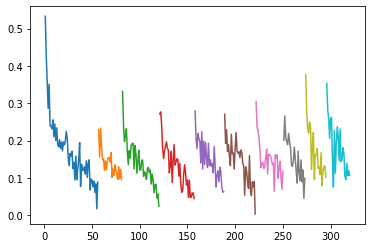

In [24]:
loss_plot(standard_total_loss_dropout_earlystopping)

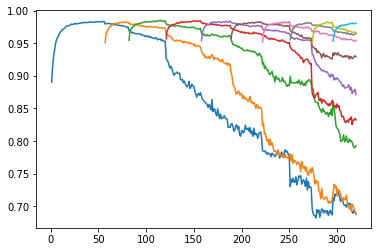

In [25]:
accuracy_plot(standard_prec_dropout_earlystopping)

In [26]:
mlp_consolidation_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_earlystopping,
 ewc_total_loss_dropout_earlystopping, 
 ewc_ce_loss_dropout_earlystopping,
 ewc_ewc_loss_dropout_earlystopping) =train(
    mlp_consolidation_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4946 / ewc: 0.0 / total: 0.4946: : 469it [00:06, 76.29it/s] 


Validation loss decreased (inf --> 0.392221).  Saving model ...


=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.401 / ewc: 0.0 / total: 0.401: : 469it [00:05, 82.01it/s]   


Validation loss decreased (0.392221 --> 0.289274).  Saving model ...


=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3714 / ewc: 0.0 / total: 0.3714: : 469it [00:05, 81.53it/s]  


Validation loss decreased (0.289274 --> 0.238119).  Saving model ...


=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3212 / ewc: 0.0 / total: 0.3212: : 469it [00:05, 82.25it/s]  


Validation loss decreased (0.238119 --> 0.201122).  Saving model ...


=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2373 / ewc: 0.0 / total: 0.2373: : 469it [00:05, 91.63it/s]  


Validation loss decreased (0.201122 --> 0.173776).  Saving model ...


=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.252 / ewc: 0.0 / total: 0.252: : 469it [00:05, 81.92it/s]    


Validation loss decreased (0.173776 --> 0.150388).  Saving model ...


=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2565 / ewc: 0.0 / total: 0.2565: : 469it [00:05, 81.99it/s]  


Validation loss decreased (0.150388 --> 0.134875).  Saving model ...


=> task: 1/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2289 / ewc: 0.0 / total: 0.2289: : 469it [00:05, 81.74it/s]  


Validation loss decreased (0.134875 --> 0.122966).  Saving model ...


=> task: 1/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1999 / ewc: 0.0 / total: 0.1999: : 469it [00:05, 86.53it/s]  


Validation loss decreased (0.122966 --> 0.113094).  Saving model ...


=> task: 1/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.223 / ewc: 0.0 / total: 0.223: : 469it [00:05, 82.20it/s]   


Validation loss decreased (0.113094 --> 0.105981).  Saving model ...


=> task: 1/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2199 / ewc: 0.0 / total: 0.2199: : 469it [00:05, 82.00it/s]  


Validation loss decreased (0.105981 --> 0.098820).  Saving model ...


=> task: 1/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1893 / ewc: 0.0 / total: 0.1893: : 469it [00:05, 81.60it/s]  


Validation loss decreased (0.098820 --> 0.093880).  Saving model ...


=> task: 1/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1617 / ewc: 0.0 / total: 0.1617: : 469it [00:05, 82.06it/s]  


Validation loss decreased (0.093880 --> 0.089368).  Saving model ...


=> task: 1/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1758 / ewc: 0.0 / total: 0.1758: : 469it [00:05, 81.02it/s] 


Validation loss decreased (0.089368 --> 0.085930).  Saving model ...


=> task: 1/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1761 / ewc: 0.0 / total: 0.1761: : 469it [00:05, 81.53it/s] 


Validation loss decreased (0.085930 --> 0.081770).  Saving model ...


=> task: 1/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2401 / ewc: 0.0 / total: 0.2401: : 469it [00:05, 81.11it/s] 


Validation loss decreased (0.081770 --> 0.077618).  Saving model ...


=> task: 1/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2287 / ewc: 0.0 / total: 0.2287: : 469it [00:05, 82.02it/s] 


Validation loss decreased (0.077618 --> 0.076275).  Saving model ...


=> task: 1/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1573 / ewc: 0.0 / total: 0.1573: : 469it [00:05, 82.82it/s]  


Validation loss decreased (0.076275 --> 0.072921).  Saving model ...


=> task: 1/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1573 / ewc: 0.0 / total: 0.1573: : 469it [00:05, 81.70it/s] 


Validation loss decreased (0.072921 --> 0.071057).  Saving model ...


=> task: 1/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1827 / ewc: 0.0 / total: 0.1827: : 469it [00:05, 89.12it/s]  


Validation loss decreased (0.071057 --> 0.069384).  Saving model ...


=> task: 1/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1374 / ewc: 0.0 / total: 0.1374: : 469it [00:05, 82.14it/s]  


Validation loss decreased (0.069384 --> 0.067735).  Saving model ...


=> task: 1/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.19 / ewc: 0.0 / total: 0.19: : 469it [00:05, 82.66it/s]     


Validation loss decreased (0.067735 --> 0.066573).  Saving model ...


=> task: 1/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2009 / ewc: 0.0 / total: 0.2009: : 469it [00:05, 82.62it/s] 


Validation loss decreased (0.066573 --> 0.065678).  Saving model ...


=> task: 1/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.167 / ewc: 0.0 / total: 0.167: : 469it [00:05, 82.10it/s]   


Validation loss decreased (0.065678 --> 0.063572).  Saving model ...


=> task: 1/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1437 / ewc: 0.0 / total: 0.1437: : 469it [00:05, 80.65it/s] 


Validation loss decreased (0.063572 --> 0.062572).  Saving model ...


=> task: 1/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1975 / ewc: 0.0 / total: 0.1975: : 469it [00:05, 81.90it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1861 / ewc: 0.0 / total: 0.1861: : 469it [00:05, 87.62it/s]  


Validation loss decreased (0.062572 --> 0.061572).  Saving model ...


=> task: 1/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1305 / ewc: 0.0 / total: 0.1305: : 469it [00:05, 82.52it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.137 / ewc: 0.0 / total: 0.137: : 469it [00:05, 83.00it/s]   


Validation loss decreased (0.061572 --> 0.061196).  Saving model ...


=> task: 1/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1063 / ewc: 0.0 / total: 0.1063: : 469it [00:05, 83.09it/s]   


Validation loss decreased (0.061196 --> 0.059479).  Saving model ...


=> task: 1/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1375 / ewc: 0.0 / total: 0.1375: : 469it [00:05, 83.17it/s]  


Validation loss decreased (0.059479 --> 0.059103).  Saving model ...


=> task: 1/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1744 / ewc: 0.0 / total: 0.1744: : 469it [00:05, 82.40it/s]   


Validation loss decreased (0.059103 --> 0.057761).  Saving model ...


=> task: 1/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1213 / ewc: 0.0 / total: 0.1213: : 469it [00:05, 83.60it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1435 / ewc: 0.0 / total: 0.1435: : 469it [00:05, 83.10it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1561 / ewc: 0.0 / total: 0.1561: : 469it [00:05, 84.59it/s]   


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.162 / ewc: 0.0 / total: 0.162: : 469it [00:04, 94.04it/s]    


Validation loss decreased (0.057761 --> 0.056625).  Saving model ...


=> task: 1/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1144 / ewc: 0.0 / total: 0.1144: : 469it [00:05, 83.90it/s]   


Validation loss decreased (0.056625 --> 0.056254).  Saving model ...


=> task: 1/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1395 / ewc: 0.0 / total: 0.1395: : 469it [00:05, 83.13it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1234 / ewc: 0.0 / total: 0.1234: : 469it [00:05, 83.05it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08954 / ewc: 0.0 / total: 0.08954: : 469it [00:05, 83.05it/s]


Validation loss decreased (0.056254 --> 0.055673).  Saving model ...


=> task: 1/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1136 / ewc: 0.0 / total: 0.1136: : 469it [00:05, 83.01it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1048 / ewc: 0.0 / total: 0.1048: : 469it [00:05, 82.92it/s]  


Validation loss decreased (0.055673 --> 0.054509).  Saving model ...


=> task: 1/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0799 / ewc: 0.0 / total: 0.0799: : 469it [00:05, 82.99it/s]    


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.066 / ewc: 0.0 / total: 0.066: : 469it [00:05, 83.12it/s]     


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09513 / ewc: 0.0 / total: 0.09513: : 469it [00:05, 82.76it/s]


Validation loss decreased (0.054509 --> 0.054076).  Saving model ...


=> task: 1/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1009 / ewc: 0.0 / total: 0.1009: : 469it [00:05, 82.71it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07415 / ewc: 0.0 / total: 0.07415: : 469it [00:05, 83.21it/s]


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07232 / ewc: 0.0 / total: 0.07232: : 469it [00:05, 83.02it/s]


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06709 / ewc: 0.0 / total: 0.06709: : 469it [00:05, 82.50it/s]


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0674 / ewc: 0.0 / total: 0.0674: : 469it [00:05, 83.08it/s]   


Validation loss decreased (0.054076 --> 0.053559).  Saving model ...


=> task: 1/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08825 / ewc: 0.0 / total: 0.08825: : 469it [00:05, 82.39it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07539 / ewc: 0.0 / total: 0.07539: : 469it [00:05, 82.63it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05531 / ewc: 0.0 / total: 0.05531: : 469it [00:05, 82.95it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05634 / ewc: 0.0 / total: 0.05634: : 469it [00:05, 82.99it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0627 / ewc: 0.0 / total: 0.0627: : 469it [00:05, 83.64it/s]   


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3258 / ewc: 0.02911 / total: 0.3549: : 469it [00:08, 53.89it/s]


Validation loss decreased (inf --> 0.203662).  Saving model ...


=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2084 / ewc: 0.02352 / total: 0.2319: : 469it [00:07, 60.29it/s]  


Validation loss decreased (0.203662 --> 0.163403).  Saving model ...


=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1971 / ewc: 0.02066 / total: 0.2177: : 469it [00:08, 57.89it/s]  


Validation loss decreased (0.163403 --> 0.137719).  Saving model ...


=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1473 / ewc: 0.01897 / total: 0.1663: : 469it [00:08, 57.76it/s] 


Validation loss decreased (0.137719 --> 0.125479).  Saving model ...


=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1704 / ewc: 0.01743 / total: 0.1878: : 469it [00:08, 58.15it/s] 


Validation loss decreased (0.125479 --> 0.118835).  Saving model ...


=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1292 / ewc: 0.01651 / total: 0.1457: : 469it [00:08, 58.21it/s] 


Validation loss decreased (0.118835 --> 0.110786).  Saving model ...


=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.174 / ewc: 0.0157 / total: 0.1897: : 469it [00:08, 58.49it/s]    


Validation loss decreased (0.110786 --> 0.107108).  Saving model ...


=> task: 2/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1804 / ewc: 0.01529 / total: 0.1957: : 469it [00:08, 58.16it/s] 


Validation loss decreased (0.107108 --> 0.103136).  Saving model ...


=> task: 2/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1617 / ewc: 0.01461 / total: 0.1763: : 469it [00:08, 58.04it/s] 


Validation loss decreased (0.103136 --> 0.098546).  Saving model ...


=> task: 2/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1276 / ewc: 0.01405 / total: 0.1417: : 469it [00:08, 57.75it/s]  


Validation loss decreased (0.098546 --> 0.093833).  Saving model ...


=> task: 2/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1899 / ewc: 0.01377 / total: 0.2037: : 469it [00:08, 57.70it/s] 


Validation loss decreased (0.093833 --> 0.092358).  Saving model ...


=> task: 2/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.152 / ewc: 0.01325 / total: 0.1652: : 469it [00:07, 59.71it/s]  


Validation loss decreased (0.092358 --> 0.090399).  Saving model ...


=> task: 2/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1184 / ewc: 0.01317 / total: 0.1316: : 469it [00:08, 58.25it/s]  


Validation loss decreased (0.090399 --> 0.089075).  Saving model ...


=> task: 2/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1917 / ewc: 0.01267 / total: 0.2044: : 469it [00:08, 57.99it/s]  


Validation loss decreased (0.089075 --> 0.087284).  Saving model ...


=> task: 2/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.141 / ewc: 0.0126 / total: 0.1536: : 469it [00:07, 58.91it/s]   


Validation loss decreased (0.087284 --> 0.086188).  Saving model ...


=> task: 2/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1309 / ewc: 0.01219 / total: 0.1431: : 469it [00:08, 58.01it/s] 


Validation loss decreased (0.086188 --> 0.085207).  Saving model ...


=> task: 2/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1547 / ewc: 0.01194 / total: 0.1666: : 469it [00:08, 58.01it/s]  


Validation loss decreased (0.085207 --> 0.082512).  Saving model ...


=> task: 2/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1716 / ewc: 0.01179 / total: 0.1834: : 469it [00:08, 58.06it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1184 / ewc: 0.0116 / total: 0.13: : 469it [00:08, 58.30it/s]    


Validation loss decreased (0.082512 --> 0.082218).  Saving model ...


=> task: 2/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1512 / ewc: 0.01131 / total: 0.1625: : 469it [00:07, 61.12it/s] 


Validation loss decreased (0.082218 --> 0.080405).  Saving model ...


=> task: 2/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1902 / ewc: 0.0111 / total: 0.2013: : 469it [00:08, 57.68it/s]  


Validation loss decreased (0.080405 --> 0.078121).  Saving model ...


=> task: 2/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1532 / ewc: 0.0109 / total: 0.1641: : 469it [00:07, 59.56it/s]   


Validation loss decreased (0.078121 --> 0.076440).  Saving model ...


=> task: 2/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1309 / ewc: 0.01082 / total: 0.1417: : 469it [00:08, 57.98it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1348 / ewc: 0.01058 / total: 0.1454: : 469it [00:08, 57.91it/s] 


Validation loss decreased (0.076440 --> 0.075622).  Saving model ...


=> task: 2/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.175 / ewc: 0.01063 / total: 0.1856: : 469it [00:08, 57.92it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1182 / ewc: 0.01043 / total: 0.1286: : 469it [00:08, 58.31it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.11 / ewc: 0.0104 / total: 0.1204: : 469it [00:08, 58.09it/s]    


Validation loss decreased (0.075622 --> 0.074912).  Saving model ...


=> task: 2/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1341 / ewc: 0.01017 / total: 0.1443: : 469it [00:08, 58.21it/s] 


Validation loss decreased (0.074912 --> 0.074469).  Saving model ...


=> task: 2/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1609 / ewc: 0.009984 / total: 0.1708: : 469it [00:07, 58.76it/s] 


Validation loss decreased (0.074469 --> 0.073035).  Saving model ...


=> task: 2/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1514 / ewc: 0.009922 / total: 0.1614: : 469it [00:08, 58.10it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1264 / ewc: 0.00972 / total: 0.1362: : 469it [00:08, 57.59it/s]  


Validation loss decreased (0.073035 --> 0.072364).  Saving model ...


=> task: 2/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1822 / ewc: 0.009632 / total: 0.1918: : 469it [00:08, 57.98it/s] 


Validation loss decreased (0.072364 --> 0.072068).  Saving model ...


=> task: 2/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1151 / ewc: 0.009611 / total: 0.1247: : 469it [00:08, 57.97it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1216 / ewc: 0.009533 / total: 0.1312: : 469it [00:08, 57.88it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09759 / ewc: 0.009457 / total: 0.1071: : 469it [00:08, 58.02it/s]


Validation loss decreased (0.072068 --> 0.071279).  Saving model ...


=> task: 2/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1485 / ewc: 0.009475 / total: 0.1579: : 469it [00:08, 57.72it/s]  


Validation loss decreased (0.071279 --> 0.071111).  Saving model ...


=> task: 2/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1106 / ewc: 0.009354 / total: 0.12: : 469it [00:08, 57.62it/s]   


Validation loss decreased (0.071111 --> 0.070127).  Saving model ...


=> task: 2/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1298 / ewc: 0.009281 / total: 0.1391: : 469it [00:08, 57.75it/s] 


Validation loss decreased (0.070127 --> 0.069238).  Saving model ...


=> task: 2/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1514 / ewc: 0.009048 / total: 0.1604: : 469it [00:07, 63.05it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1497 / ewc: 0.008897 / total: 0.1586: : 469it [00:08, 58.10it/s] 


Validation loss decreased (0.069238 --> 0.068072).  Saving model ...


=> task: 2/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1268 / ewc: 0.008845 / total: 0.1357: : 469it [00:08, 57.74it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1076 / ewc: 0.008873 / total: 0.1165: : 469it [00:08, 58.58it/s] 


Validation loss decreased (0.068072 --> 0.067605).  Saving model ...


=> task: 2/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.132 / ewc: 0.008702 / total: 0.1407: : 469it [00:08, 58.19it/s]  


Validation loss decreased (0.067605 --> 0.067008).  Saving model ...


=> task: 2/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1123 / ewc: 0.008687 / total: 0.121: : 469it [00:08, 57.95it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1637 / ewc: 0.008558 / total: 0.1722: : 469it [00:08, 58.17it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08536 / ewc: 0.008534 / total: 0.0939: : 469it [00:08, 58.05it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1134 / ewc: 0.008346 / total: 0.1218: : 469it [00:08, 58.17it/s]  


EarlyStopping counter: 4 out of 5


=> task: 2/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09792 / ewc: 0.00829 / total: 0.1062: : 469it [00:08, 58.21it/s]  


Validation loss decreased (0.067008 --> 0.066208).  Saving model ...


=> task: 2/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05768 / ewc: 0.008229 / total: 0.06591: : 469it [00:08, 57.89it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09614 / ewc: 0.008319 / total: 0.1045: : 469it [00:08, 58.12it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1021 / ewc: 0.00819 / total: 0.1103: : 469it [00:08, 57.88it/s]  


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07338 / ewc: 0.008085 / total: 0.08147: : 469it [00:08, 58.20it/s]


Validation loss decreased (0.066208 --> 0.065930).  Saving model ...


=> task: 2/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06604 / ewc: 0.00814 / total: 0.07418: : 469it [00:08, 57.93it/s] 


Validation loss decreased (0.065930 --> 0.065358).  Saving model ...


=> task: 2/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08515 / ewc: 0.007954 / total: 0.0931: : 469it [00:08, 57.88it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1046 / ewc: 0.007835 / total: 0.1124: : 469it [00:07, 58.73it/s] 


Validation loss decreased (0.065358 --> 0.064626).  Saving model ...


=> task: 2/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.007792 / total: 0.1383: : 469it [00:08, 57.85it/s]  


Validation loss decreased (0.064626 --> 0.063955).  Saving model ...


=> task: 2/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08436 / ewc: 0.007855 / total: 0.09221: : 469it [00:08, 57.78it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05906 / ewc: 0.007687 / total: 0.06675: : 469it [00:08, 58.40it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08275 / ewc: 0.007638 / total: 0.09039: : 469it [00:08, 58.18it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08861 / ewc: 0.007575 / total: 0.09619: : 469it [00:07, 61.30it/s]


EarlyStopping counter: 4 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2358 / ewc: 0.0303 / total: 0.2661: : 469it [00:08, 53.60it/s]   


Validation loss decreased (inf --> 0.203382).  Saving model ...


=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2439 / ewc: 0.02295 / total: 0.2669: : 469it [00:08, 57.36it/s] 


Validation loss decreased (0.203382 --> 0.165335).  Saving model ...


=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.218 / ewc: 0.0194 / total: 0.2374: : 469it [00:08, 58.52it/s]    


Validation loss decreased (0.165335 --> 0.139791).  Saving model ...


=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1929 / ewc: 0.01726 / total: 0.2102: : 469it [00:08, 57.85it/s] 


Validation loss decreased (0.139791 --> 0.124258).  Saving model ...


=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.158 / ewc: 0.01598 / total: 0.174: : 469it [00:08, 57.68it/s]    


Validation loss decreased (0.124258 --> 0.114114).  Saving model ...


=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1742 / ewc: 0.01488 / total: 0.189: : 469it [00:08, 57.69it/s]   


Validation loss decreased (0.114114 --> 0.107641).  Saving model ...


=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1349 / ewc: 0.01424 / total: 0.1491: : 469it [00:07, 59.05it/s] 


Validation loss decreased (0.107641 --> 0.106145).  Saving model ...


=> task: 3/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1959 / ewc: 0.01351 / total: 0.2094: : 469it [00:08, 57.64it/s] 


Validation loss decreased (0.106145 --> 0.104975).  Saving model ...


=> task: 3/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2038 / ewc: 0.013 / total: 0.2168: : 469it [00:08, 58.26it/s]   


Validation loss decreased (0.104975 --> 0.096127).  Saving model ...


=> task: 3/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1902 / ewc: 0.01268 / total: 0.2029: : 469it [00:08, 58.41it/s] 


Validation loss decreased (0.096127 --> 0.095677).  Saving model ...


=> task: 3/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1526 / ewc: 0.01199 / total: 0.1646: : 469it [00:08, 57.70it/s] 


Validation loss decreased (0.095677 --> 0.091480).  Saving model ...


=> task: 3/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1976 / ewc: 0.01176 / total: 0.2093: : 469it [00:08, 57.46it/s] 


Validation loss decreased (0.091480 --> 0.090798).  Saving model ...


=> task: 3/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1271 / ewc: 0.01144 / total: 0.1385: : 469it [00:07, 59.91it/s] 


Validation loss decreased (0.090798 --> 0.087618).  Saving model ...


=> task: 3/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1929 / ewc: 0.01114 / total: 0.2041: : 469it [00:08, 57.78it/s]  


Validation loss decreased (0.087618 --> 0.087386).  Saving model ...


=> task: 3/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.15 / ewc: 0.01092 / total: 0.1609: : 469it [00:08, 56.80it/s]    


Validation loss decreased (0.087386 --> 0.085587).  Saving model ...


=> task: 3/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1647 / ewc: 0.01066 / total: 0.1754: : 469it [00:08, 57.27it/s] 


Validation loss decreased (0.085587 --> 0.083398).  Saving model ...


=> task: 3/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1072 / ewc: 0.01032 / total: 0.1176: : 469it [00:08, 57.60it/s] 


Validation loss decreased (0.083398 --> 0.082015).  Saving model ...


=> task: 3/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1644 / ewc: 0.01002 / total: 0.1744: : 469it [00:08, 57.56it/s]  


Validation loss decreased (0.082015 --> 0.080883).  Saving model ...


=> task: 3/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1957 / ewc: 0.009728 / total: 0.2055: : 469it [00:08, 57.59it/s] 


Validation loss decreased (0.080883 --> 0.077699).  Saving model ...


=> task: 3/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1188 / ewc: 0.00956 / total: 0.1284: : 469it [00:08, 57.93it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1188 / ewc: 0.009503 / total: 0.1283: : 469it [00:08, 57.94it/s] 


Validation loss decreased (0.077699 --> 0.076647).  Saving model ...


=> task: 3/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1167 / ewc: 0.009512 / total: 0.1262: : 469it [00:07, 59.39it/s]  


Validation loss decreased (0.076647 --> 0.076100).  Saving model ...


=> task: 3/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1093 / ewc: 0.009401 / total: 0.1187: : 469it [00:08, 57.84it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1397 / ewc: 0.008969 / total: 0.1487: : 469it [00:08, 57.76it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1158 / ewc: 0.009 / total: 0.1248: : 469it [00:08, 57.93it/s]    


Validation loss decreased (0.076100 --> 0.074485).  Saving model ...


=> task: 3/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1755 / ewc: 0.009006 / total: 0.1845: : 469it [00:08, 57.83it/s] 


Validation loss decreased (0.074485 --> 0.073768).  Saving model ...


=> task: 3/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.09722 / ewc: 0.009014 / total: 0.1062: : 469it [00:08, 57.75it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0997 / ewc: 0.008614 / total: 0.1083: : 469it [00:08, 57.78it/s] 


Validation loss decreased (0.073768 --> 0.072347).  Saving model ...


=> task: 3/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1134 / ewc: 0.008697 / total: 0.1221: : 469it [00:08, 57.77it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09989 / ewc: 0.00856 / total: 0.1085: : 469it [00:07, 60.45it/s] 


Validation loss decreased (0.072347 --> 0.071567).  Saving model ...


=> task: 3/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1264 / ewc: 0.008213 / total: 0.1347: : 469it [00:08, 57.41it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1093 / ewc: 0.008369 / total: 0.1177: : 469it [00:07, 63.01it/s] 


Validation loss decreased (0.071567 --> 0.069937).  Saving model ...


=> task: 3/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08791 / ewc: 0.008229 / total: 0.09614: : 469it [00:08, 57.96it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1215 / ewc: 0.008068 / total: 0.1296: : 469it [00:08, 57.72it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.169 / ewc: 0.007819 / total: 0.1768: : 469it [00:08, 58.07it/s]  


Validation loss decreased (0.069937 --> 0.069189).  Saving model ...


=> task: 3/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1367 / ewc: 0.007716 / total: 0.1444: : 469it [00:08, 57.94it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06369 / ewc: 0.007885 / total: 0.07158: : 469it [00:08, 57.77it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1167 / ewc: 0.007797 / total: 0.1245: : 469it [00:08, 57.78it/s]  


Validation loss decreased (0.069189 --> 0.069184).  Saving model ...


=> task: 3/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1417 / ewc: 0.007684 / total: 0.1493: : 469it [00:08, 57.65it/s] 


Validation loss decreased (0.069184 --> 0.068441).  Saving model ...


=> task: 3/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1448 / ewc: 0.007566 / total: 0.1524: : 469it [00:08, 57.82it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1072 / ewc: 0.007576 / total: 0.1148: : 469it [00:08, 57.13it/s] 


Validation loss decreased (0.068441 --> 0.067728).  Saving model ...


=> task: 3/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04072 / ewc: 0.007518 / total: 0.04824: : 469it [00:08, 57.52it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06564 / ewc: 0.007275 / total: 0.07291: : 469it [00:08, 58.07it/s]


Validation loss decreased (0.067728 --> 0.067093).  Saving model ...


=> task: 3/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.122 / ewc: 0.007217 / total: 0.1293: : 469it [00:08, 57.49it/s]   


Validation loss decreased (0.067093 --> 0.065614).  Saving model ...


=> task: 3/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09763 / ewc: 0.007123 / total: 0.1048: : 469it [00:08, 57.53it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1241 / ewc: 0.007156 / total: 0.1312: : 469it [00:08, 57.90it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07863 / ewc: 0.007198 / total: 0.08582: : 469it [00:08, 57.40it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07805 / ewc: 0.00683 / total: 0.08488: : 469it [00:07, 58.70it/s]


Validation loss decreased (0.065614 --> 0.065552).  Saving model ...


=> task: 3/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1044 / ewc: 0.007195 / total: 0.1116: : 469it [00:07, 64.99it/s]  


Validation loss decreased (0.065552 --> 0.065277).  Saving model ...


=> task: 3/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09922 / ewc: 0.00677 / total: 0.106: : 469it [00:07, 64.96it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06682 / ewc: 0.006989 / total: 0.07381: : 469it [00:08, 58.07it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0633 / ewc: 0.006843 / total: 0.07014: : 469it [00:07, 60.14it/s]


Validation loss decreased (0.065277 --> 0.064592).  Saving model ...


=> task: 3/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1125 / ewc: 0.006812 / total: 0.1193: : 469it [00:08, 57.68it/s] 


Validation loss decreased (0.064592 --> 0.064153).  Saving model ...


=> task: 3/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09385 / ewc: 0.006582 / total: 0.1004: : 469it [00:08, 57.67it/s] 


Validation loss decreased (0.064153 --> 0.063263).  Saving model ...


=> task: 3/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07972 / ewc: 0.006526 / total: 0.08625: : 469it [00:08, 57.65it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07617 / ewc: 0.006648 / total: 0.08282: : 469it [00:08, 57.76it/s]


Validation loss decreased (0.063263 --> 0.062962).  Saving model ...


=> task: 3/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08666 / ewc: 0.00661 / total: 0.09327: : 469it [00:08, 58.46it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08202 / ewc: 0.006392 / total: 0.08841: : 469it [00:08, 57.73it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1063 / ewc: 0.006432 / total: 0.1127: : 469it [00:08, 57.85it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07362 / ewc: 0.006388 / total: 0.08001: : 469it [00:08, 57.82it/s]


EarlyStopping counter: 4 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3113 / ewc: 0.02783 / total: 0.3391: : 469it [00:08, 53.46it/s] 


Validation loss decreased (inf --> 0.206961).  Saving model ...


=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2187 / ewc: 0.02127 / total: 0.24: : 469it [00:08, 58.28it/s]    


Validation loss decreased (0.206961 --> 0.152243).  Saving model ...


=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2313 / ewc: 0.01826 / total: 0.2496: : 469it [00:08, 57.96it/s] 


Validation loss decreased (0.152243 --> 0.132033).  Saving model ...


=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1851 / ewc: 0.01618 / total: 0.2013: : 469it [00:08, 57.63it/s]  


Validation loss decreased (0.132033 --> 0.116990).  Saving model ...


=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.233 / ewc: 0.01458 / total: 0.2475: : 469it [00:08, 57.89it/s]  


Validation loss decreased (0.116990 --> 0.108309).  Saving model ...


=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2347 / ewc: 0.0139 / total: 0.2486: : 469it [00:08, 57.78it/s]   


Validation loss decreased (0.108309 --> 0.102737).  Saving model ...


=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2115 / ewc: 0.01283 / total: 0.2244: : 469it [00:08, 57.92it/s] 


Validation loss decreased (0.102737 --> 0.097877).  Saving model ...


=> task: 4/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.163 / ewc: 0.01244 / total: 0.1755: : 469it [00:08, 57.77it/s]  


Validation loss decreased (0.097877 --> 0.093758).  Saving model ...


=> task: 4/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2014 / ewc: 0.01168 / total: 0.213: : 469it [00:08, 57.93it/s]  


Validation loss decreased (0.093758 --> 0.091187).  Saving model ...


=> task: 4/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1429 / ewc: 0.01132 / total: 0.1542: : 469it [00:08, 57.75it/s] 


Validation loss decreased (0.091187 --> 0.088558).  Saving model ...


=> task: 4/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.185 / ewc: 0.01127 / total: 0.1963: : 469it [00:08, 57.54it/s]  


Validation loss decreased (0.088558 --> 0.086371).  Saving model ...


=> task: 4/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1925 / ewc: 0.01075 / total: 0.2032: : 469it [00:08, 57.76it/s] 


Validation loss decreased (0.086371 --> 0.086198).  Saving model ...


=> task: 4/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1571 / ewc: 0.01035 / total: 0.1675: : 469it [00:08, 57.47it/s] 


Validation loss decreased (0.086198 --> 0.083295).  Saving model ...


=> task: 4/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1869 / ewc: 0.01037 / total: 0.1973: : 469it [00:08, 57.50it/s]  


Validation loss decreased (0.083295 --> 0.081055).  Saving model ...


=> task: 4/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1627 / ewc: 0.0101 / total: 0.1728: : 469it [00:07, 61.57it/s]   


Validation loss decreased (0.081055 --> 0.078531).  Saving model ...


=> task: 4/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.177 / ewc: 0.009739 / total: 0.1867: : 469it [00:07, 66.17it/s]   


Validation loss decreased (0.078531 --> 0.077368).  Saving model ...


=> task: 4/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.153 / ewc: 0.00958 / total: 0.1626: : 469it [00:08, 57.52it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1528 / ewc: 0.009208 / total: 0.162: : 469it [00:08, 58.04it/s]  


Validation loss decreased (0.077368 --> 0.074571).  Saving model ...


=> task: 4/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1636 / ewc: 0.009336 / total: 0.1729: : 469it [00:07, 59.18it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.149 / ewc: 0.008965 / total: 0.158: : 469it [00:08, 57.71it/s]   


Validation loss decreased (0.074571 --> 0.074441).  Saving model ...


=> task: 4/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2004 / ewc: 0.008727 / total: 0.2092: : 469it [00:08, 58.21it/s] 


Validation loss decreased (0.074441 --> 0.073593).  Saving model ...


=> task: 4/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1328 / ewc: 0.008721 / total: 0.1416: : 469it [00:08, 57.71it/s]  


Validation loss decreased (0.073593 --> 0.071857).  Saving model ...


=> task: 4/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1784 / ewc: 0.008491 / total: 0.1869: : 469it [00:08, 58.04it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.121 / ewc: 0.008409 / total: 0.1294: : 469it [00:08, 57.69it/s]  


Validation loss decreased (0.071857 --> 0.070807).  Saving model ...


=> task: 4/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2242 / ewc: 0.008222 / total: 0.2324: : 469it [00:08, 58.22it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1649 / ewc: 0.008293 / total: 0.1732: : 469it [00:08, 58.08it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1393 / ewc: 0.008043 / total: 0.1473: : 469it [00:08, 57.89it/s] 


Validation loss decreased (0.070807 --> 0.070275).  Saving model ...


=> task: 4/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.145 / ewc: 0.00789 / total: 0.1529: : 469it [00:08, 58.27it/s]   


Validation loss decreased (0.070275 --> 0.068772).  Saving model ...


=> task: 4/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1675 / ewc: 0.007823 / total: 0.1754: : 469it [00:08, 57.73it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09966 / ewc: 0.007719 / total: 0.1074: : 469it [00:08, 57.70it/s]


Validation loss decreased (0.068772 --> 0.068125).  Saving model ...


=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1313 / ewc: 0.007495 / total: 0.1388: : 469it [00:08, 57.85it/s]  


Validation loss decreased (0.068125 --> 0.067723).  Saving model ...


=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1782 / ewc: 0.007533 / total: 0.1857: : 469it [00:08, 57.20it/s]  


Validation loss decreased (0.067723 --> 0.067463).  Saving model ...


=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1457 / ewc: 0.007481 / total: 0.1532: : 469it [00:08, 57.38it/s] 


Validation loss decreased (0.067463 --> 0.066696).  Saving model ...


=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.09744 / ewc: 0.007432 / total: 0.1049: : 469it [00:08, 57.22it/s] 


Validation loss decreased (0.066696 --> 0.066660).  Saving model ...


=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1419 / ewc: 0.007423 / total: 0.1493: : 469it [00:08, 57.28it/s]  


Validation loss decreased (0.066660 --> 0.066030).  Saving model ...


=> task: 4/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1628 / ewc: 0.007271 / total: 0.1701: : 469it [00:08, 56.79it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1629 / ewc: 0.007071 / total: 0.17: : 469it [00:07, 58.93it/s]    


Validation loss decreased (0.066030 --> 0.065189).  Saving model ...


=> task: 4/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1924 / ewc: 0.007039 / total: 0.1995: : 469it [00:08, 57.66it/s] 


Validation loss decreased (0.065189 --> 0.065112).  Saving model ...


=> task: 4/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1342 / ewc: 0.006788 / total: 0.1409: : 469it [00:08, 57.48it/s] 


Validation loss decreased (0.065112 --> 0.063288).  Saving model ...


=> task: 4/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1579 / ewc: 0.006764 / total: 0.1646: : 469it [00:08, 58.00it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1584 / ewc: 0.006887 / total: 0.1653: : 469it [00:08, 57.86it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1157 / ewc: 0.006924 / total: 0.1226: : 469it [00:08, 57.51it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1123 / ewc: 0.006575 / total: 0.1189: : 469it [00:08, 57.90it/s]  


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1371 / ewc: 0.00666 / total: 0.1438: : 469it [00:08, 57.80it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3164 / ewc: 0.02759 / total: 0.344: : 469it [00:08, 53.24it/s]  


Validation loss decreased (inf --> 0.213666).  Saving model ...


=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2943 / ewc: 0.02067 / total: 0.315: : 469it [00:08, 58.10it/s]  


Validation loss decreased (0.213666 --> 0.162407).  Saving model ...


=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2068 / ewc: 0.01786 / total: 0.2246: : 469it [00:08, 57.64it/s] 


Validation loss decreased (0.162407 --> 0.143051).  Saving model ...


=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2259 / ewc: 0.01576 / total: 0.2416: : 469it [00:08, 57.39it/s] 


Validation loss decreased (0.143051 --> 0.123390).  Saving model ...


=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2159 / ewc: 0.01442 / total: 0.2303: : 469it [00:08, 57.64it/s]  


Validation loss decreased (0.123390 --> 0.115433).  Saving model ...


=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2422 / ewc: 0.01334 / total: 0.2555: : 469it [00:08, 57.71it/s] 


Validation loss decreased (0.115433 --> 0.108700).  Saving model ...


=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1912 / ewc: 0.01253 / total: 0.2037: : 469it [00:08, 57.62it/s] 


Validation loss decreased (0.108700 --> 0.103341).  Saving model ...


=> task: 5/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1493 / ewc: 0.01243 / total: 0.1618: : 469it [00:08, 57.74it/s]  


Validation loss decreased (0.103341 --> 0.099360).  Saving model ...


=> task: 5/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1302 / ewc: 0.01141 / total: 0.1416: : 469it [00:08, 57.86it/s] 


Validation loss decreased (0.099360 --> 0.095260).  Saving model ...


=> task: 5/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2397 / ewc: 0.011 / total: 0.2507: : 469it [00:07, 58.97it/s]   


Validation loss decreased (0.095260 --> 0.092586).  Saving model ...


=> task: 5/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1959 / ewc: 0.01091 / total: 0.2068: : 469it [00:08, 57.72it/s] 


Validation loss decreased (0.092586 --> 0.090788).  Saving model ...


=> task: 5/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.252 / ewc: 0.01007 / total: 0.262: : 469it [00:08, 57.60it/s]    


Validation loss decreased (0.090788 --> 0.087590).  Saving model ...


=> task: 5/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2005 / ewc: 0.01001 / total: 0.2105: : 469it [00:08, 57.66it/s]  


Validation loss decreased (0.087590 --> 0.086396).  Saving model ...


=> task: 5/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1233 / ewc: 0.00966 / total: 0.1329: : 469it [00:07, 61.92it/s]  


Validation loss decreased (0.086396 --> 0.084053).  Saving model ...


=> task: 5/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1922 / ewc: 0.009461 / total: 0.2017: : 469it [00:08, 57.22it/s] 


Validation loss decreased (0.084053 --> 0.082530).  Saving model ...


=> task: 5/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.213 / ewc: 0.008931 / total: 0.2219: : 469it [00:08, 57.56it/s]  


Validation loss decreased (0.082530 --> 0.081516).  Saving model ...


=> task: 5/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2298 / ewc: 0.008917 / total: 0.2387: : 469it [00:08, 57.50it/s] 


Validation loss decreased (0.081516 --> 0.079693).  Saving model ...


=> task: 5/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1367 / ewc: 0.009011 / total: 0.1458: : 469it [00:08, 57.52it/s] 


Validation loss decreased (0.079693 --> 0.079648).  Saving model ...


=> task: 5/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1912 / ewc: 0.008476 / total: 0.1997: : 469it [00:08, 57.54it/s]  


Validation loss decreased (0.079648 --> 0.077365).  Saving model ...


=> task: 5/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1738 / ewc: 0.008447 / total: 0.1822: : 469it [00:08, 57.74it/s] 


Validation loss decreased (0.077365 --> 0.077300).  Saving model ...


=> task: 5/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1849 / ewc: 0.008347 / total: 0.1933: : 469it [00:08, 57.63it/s] 


Validation loss decreased (0.077300 --> 0.076430).  Saving model ...


=> task: 5/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.163 / ewc: 0.008015 / total: 0.171: : 469it [00:08, 58.47it/s]   


Validation loss decreased (0.076430 --> 0.074953).  Saving model ...


=> task: 5/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2029 / ewc: 0.007774 / total: 0.2107: : 469it [00:08, 57.69it/s] 


Validation loss decreased (0.074953 --> 0.074306).  Saving model ...


=> task: 5/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1469 / ewc: 0.007901 / total: 0.1548: : 469it [00:07, 61.66it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1236 / ewc: 0.008032 / total: 0.1316: : 469it [00:07, 60.19it/s]  


Validation loss decreased (0.074306 --> 0.074203).  Saving model ...


=> task: 5/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1342 / ewc: 0.007559 / total: 0.1418: : 469it [00:08, 58.46it/s] 


Validation loss decreased (0.074203 --> 0.072746).  Saving model ...


=> task: 5/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1659 / ewc: 0.007472 / total: 0.1734: : 469it [00:08, 57.38it/s] 


Validation loss decreased (0.072746 --> 0.071504).  Saving model ...


=> task: 5/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1301 / ewc: 0.007433 / total: 0.1375: : 469it [00:08, 57.59it/s] 


Validation loss decreased (0.071504 --> 0.070777).  Saving model ...


=> task: 5/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1124 / ewc: 0.007186 / total: 0.1196: : 469it [00:08, 56.78it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1231 / ewc: 0.007232 / total: 0.1304: : 469it [00:08, 55.99it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1417 / ewc: 0.006837 / total: 0.1486: : 469it [00:08, 55.30it/s]  


Validation loss decreased (0.070777 --> 0.070313).  Saving model ...


=> task: 5/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1235 / ewc: 0.006689 / total: 0.1302: : 469it [00:16, 29.26it/s] 


Validation loss decreased (0.070313 --> 0.069255).  Saving model ...


=> task: 5/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09572 / ewc: 0.006898 / total: 0.1026: : 469it [00:09, 50.00it/s] 


Validation loss decreased (0.069255 --> 0.069194).  Saving model ...


=> task: 5/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.12 / ewc: 0.006841 / total: 0.1268: : 469it [00:08, 52.51it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1538 / ewc: 0.00691 / total: 0.1607: : 469it [00:09, 47.29it/s]   


Validation loss decreased (0.069194 --> 0.068137).  Saving model ...


=> task: 5/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1167 / ewc: 0.006583 / total: 0.1232: : 469it [00:09, 47.17it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1887 / ewc: 0.006655 / total: 0.1953: : 469it [00:09, 50.94it/s] 


Validation loss decreased (0.068137 --> 0.067983).  Saving model ...


=> task: 5/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1317 / ewc: 0.006366 / total: 0.1381: : 469it [00:08, 56.23it/s]  


Validation loss decreased (0.067983 --> 0.066932).  Saving model ...


=> task: 5/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1051 / ewc: 0.006093 / total: 0.1112: : 469it [00:08, 56.22it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1413 / ewc: 0.006216 / total: 0.1476: : 469it [00:08, 56.44it/s] 


Validation loss decreased (0.066932 --> 0.066818).  Saving model ...


=> task: 5/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1068 / ewc: 0.00626 / total: 0.1131: : 469it [00:08, 56.19it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1437 / ewc: 0.005874 / total: 0.1495: : 469it [00:08, 56.50it/s]  


Validation loss decreased (0.066818 --> 0.066695).  Saving model ...


=> task: 5/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.128 / ewc: 0.005959 / total: 0.134: : 469it [00:08, 56.35it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09516 / ewc: 0.005808 / total: 0.101: : 469it [00:08, 56.48it/s]  


Validation loss decreased (0.066695 --> 0.066301).  Saving model ...


=> task: 5/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1627 / ewc: 0.005968 / total: 0.1687: : 469it [00:08, 56.64it/s] 


Validation loss decreased (0.066301 --> 0.065536).  Saving model ...


=> task: 5/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09682 / ewc: 0.005845 / total: 0.1027: : 469it [00:08, 56.39it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1208 / ewc: 0.00596 / total: 0.1268: : 469it [00:08, 55.65it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1154 / ewc: 0.005548 / total: 0.121: : 469it [00:08, 56.62it/s]   


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09205 / ewc: 0.006 / total: 0.09805: : 469it [00:08, 56.35it/s]   


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0954 / ewc: 0.005716 / total: 0.1011: : 469it [00:08, 56.32it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3023 / ewc: 0.02787 / total: 0.3302: : 469it [00:08, 52.78it/s] 


Validation loss decreased (inf --> 0.210459).  Saving model ...


=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2687 / ewc: 0.01992 / total: 0.2887: : 469it [00:08, 56.61it/s] 


Validation loss decreased (0.210459 --> 0.159069).  Saving model ...


=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2522 / ewc: 0.01717 / total: 0.2694: : 469it [00:08, 56.80it/s]  


Validation loss decreased (0.159069 --> 0.135559).  Saving model ...


=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2073 / ewc: 0.01528 / total: 0.2226: : 469it [00:08, 56.32it/s] 


Validation loss decreased (0.135559 --> 0.127793).  Saving model ...


=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1875 / ewc: 0.01418 / total: 0.2016: : 469it [00:08, 58.17it/s]  


Validation loss decreased (0.127793 --> 0.114884).  Saving model ...


=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2021 / ewc: 0.01334 / total: 0.2155: : 469it [00:08, 56.96it/s]  


Validation loss decreased (0.114884 --> 0.109189).  Saving model ...


=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1769 / ewc: 0.01271 / total: 0.1896: : 469it [00:08, 57.28it/s] 


Validation loss decreased (0.109189 --> 0.104012).  Saving model ...


=> task: 6/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.181 / ewc: 0.01199 / total: 0.193: : 469it [00:08, 56.44it/s]    


Validation loss decreased (0.104012 --> 0.098992).  Saving model ...


=> task: 6/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.134 / ewc: 0.01123 / total: 0.1452: : 469it [00:07, 58.75it/s]   


Validation loss decreased (0.098992 --> 0.097216).  Saving model ...


=> task: 6/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1666 / ewc: 0.01103 / total: 0.1776: : 469it [00:08, 56.46it/s]  


Validation loss decreased (0.097216 --> 0.093761).  Saving model ...


=> task: 6/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1525 / ewc: 0.01084 / total: 0.1634: : 469it [00:08, 57.58it/s]  


Validation loss decreased (0.093761 --> 0.091671).  Saving model ...


=> task: 6/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1265 / ewc: 0.01014 / total: 0.1366: : 469it [00:08, 56.34it/s]  


Validation loss decreased (0.091671 --> 0.090419).  Saving model ...


=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1637 / ewc: 0.01012 / total: 0.1738: : 469it [00:08, 56.51it/s]  


Validation loss decreased (0.090419 --> 0.090405).  Saving model ...


=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1887 / ewc: 0.009825 / total: 0.1985: : 469it [00:08, 56.78it/s] 


Validation loss decreased (0.090405 --> 0.086491).  Saving model ...


=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1536 / ewc: 0.009397 / total: 0.163: : 469it [00:08, 55.98it/s]  


Validation loss decreased (0.086491 --> 0.085009).  Saving model ...


=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1138 / ewc: 0.009124 / total: 0.1229: : 469it [00:09, 51.67it/s]  


Validation loss decreased (0.085009 --> 0.081810).  Saving model ...


=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1751 / ewc: 0.009407 / total: 0.1845: : 469it [00:08, 52.18it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2197 / ewc: 0.008946 / total: 0.2287: : 469it [00:08, 57.06it/s]  


Validation loss decreased (0.081810 --> 0.081116).  Saving model ...


=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1251 / ewc: 0.008707 / total: 0.1339: : 469it [00:08, 58.03it/s] 


Validation loss decreased (0.081116 --> 0.080075).  Saving model ...


=> task: 6/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1413 / ewc: 0.008732 / total: 0.1501: : 469it [00:08, 57.25it/s]  


Validation loss decreased (0.080075 --> 0.079626).  Saving model ...


=> task: 6/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.107 / ewc: 0.008241 / total: 0.1153: : 469it [00:08, 57.51it/s]  


Validation loss decreased (0.079626 --> 0.078135).  Saving model ...


=> task: 6/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1199 / ewc: 0.008563 / total: 0.1285: : 469it [00:08, 57.30it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1124 / ewc: 0.008329 / total: 0.1207: : 469it [00:08, 57.17it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1072 / ewc: 0.008308 / total: 0.1155: : 469it [00:08, 57.07it/s] 


Validation loss decreased (0.078135 --> 0.076491).  Saving model ...


=> task: 6/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1285 / ewc: 0.007935 / total: 0.1364: : 469it [00:08, 57.20it/s]  


Validation loss decreased (0.076491 --> 0.075851).  Saving model ...


=> task: 6/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1113 / ewc: 0.007762 / total: 0.1191: : 469it [00:08, 57.90it/s] 


Validation loss decreased (0.075851 --> 0.075293).  Saving model ...


=> task: 6/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.103 / ewc: 0.007574 / total: 0.1106: : 469it [00:08, 57.51it/s]  


Validation loss decreased (0.075293 --> 0.075231).  Saving model ...


=> task: 6/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1261 / ewc: 0.007651 / total: 0.1337: : 469it [00:06, 67.59it/s] 


Validation loss decreased (0.075231 --> 0.074861).  Saving model ...


=> task: 6/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1183 / ewc: 0.007718 / total: 0.1261: : 469it [00:07, 64.70it/s] 


Validation loss decreased (0.074861 --> 0.072617).  Saving model ...


=> task: 6/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07311 / ewc: 0.007633 / total: 0.08074: : 469it [00:07, 60.76it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1205 / ewc: 0.007349 / total: 0.1278: : 469it [00:07, 62.60it/s] 


Validation loss decreased (0.072617 --> 0.072081).  Saving model ...


=> task: 6/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09084 / ewc: 0.007122 / total: 0.09796: : 469it [00:08, 57.30it/s]


Validation loss decreased (0.072081 --> 0.071769).  Saving model ...


=> task: 6/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08369 / ewc: 0.007342 / total: 0.09103: : 469it [00:08, 57.21it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1206 / ewc: 0.007578 / total: 0.1282: : 469it [00:08, 57.06it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08982 / ewc: 0.006976 / total: 0.09679: : 469it [00:08, 57.58it/s]


Validation loss decreased (0.071769 --> 0.071021).  Saving model ...


=> task: 6/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07512 / ewc: 0.007429 / total: 0.08255: : 469it [00:07, 58.79it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09163 / ewc: 0.006886 / total: 0.09852: : 469it [00:08, 57.20it/s]


Validation loss decreased (0.071021 --> 0.070305).  Saving model ...


=> task: 6/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05593 / ewc: 0.006781 / total: 0.06271: : 469it [00:08, 56.99it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0784 / ewc: 0.006827 / total: 0.08522: : 469it [00:08, 57.08it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.079 / ewc: 0.006693 / total: 0.0857: : 469it [00:08, 57.50it/s]  


Validation loss decreased (0.070305 --> 0.068930).  Saving model ...


=> task: 6/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.114 / ewc: 0.006602 / total: 0.1206: : 469it [00:08, 57.14it/s]   


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05601 / ewc: 0.006327 / total: 0.06233: : 469it [00:08, 57.04it/s]


Validation loss decreased (0.068930 --> 0.068234).  Saving model ...


=> task: 6/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07476 / ewc: 0.006503 / total: 0.08126: : 469it [00:08, 58.27it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06852 / ewc: 0.006551 / total: 0.07507: : 469it [00:07, 61.54it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08008 / ewc: 0.006281 / total: 0.08636: : 469it [00:08, 56.76it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05737 / ewc: 0.006133 / total: 0.06351: : 469it [00:08, 57.44it/s]


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07156 / ewc: 0.006451 / total: 0.07802: : 469it [00:08, 57.08it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3002 / ewc: 0.02881 / total: 0.329: : 469it [00:08, 53.12it/s]  


Validation loss decreased (inf --> 0.203247).  Saving model ...


=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2284 / ewc: 0.02186 / total: 0.2502: : 469it [00:08, 56.97it/s] 


Validation loss decreased (0.203247 --> 0.161101).  Saving model ...


=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1992 / ewc: 0.01819 / total: 0.2174: : 469it [00:08, 57.29it/s]  


Validation loss decreased (0.161101 --> 0.137192).  Saving model ...


=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1494 / ewc: 0.01595 / total: 0.1654: : 469it [00:08, 57.34it/s] 


Validation loss decreased (0.137192 --> 0.122435).  Saving model ...


=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1586 / ewc: 0.01459 / total: 0.1732: : 469it [00:08, 57.30it/s] 


Validation loss decreased (0.122435 --> 0.112778).  Saving model ...


=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1612 / ewc: 0.01378 / total: 0.1749: : 469it [00:08, 57.03it/s] 


Validation loss decreased (0.112778 --> 0.108864).  Saving model ...


=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2392 / ewc: 0.01299 / total: 0.2522: : 469it [00:08, 57.50it/s]  


Validation loss decreased (0.108864 --> 0.102697).  Saving model ...


=> task: 7/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1396 / ewc: 0.01196 / total: 0.1516: : 469it [00:08, 57.44it/s] 


Validation loss decreased (0.102697 --> 0.095987).  Saving model ...


=> task: 7/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1898 / ewc: 0.01216 / total: 0.2019: : 469it [00:08, 56.56it/s] 


Validation loss decreased (0.095987 --> 0.094300).  Saving model ...


=> task: 7/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1766 / ewc: 0.01143 / total: 0.188: : 469it [00:08, 57.13it/s]  


Validation loss decreased (0.094300 --> 0.090290).  Saving model ...


=> task: 7/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1971 / ewc: 0.0112 / total: 0.2083: : 469it [00:08, 57.29it/s]  


Validation loss decreased (0.090290 --> 0.089007).  Saving model ...


=> task: 7/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1815 / ewc: 0.01032 / total: 0.1919: : 469it [00:08, 57.50it/s] 


Validation loss decreased (0.089007 --> 0.084725).  Saving model ...


=> task: 7/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.12 / ewc: 0.0101 / total: 0.1301: : 469it [00:08, 57.94it/s]     


Validation loss decreased (0.084725 --> 0.083833).  Saving model ...


=> task: 7/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1795 / ewc: 0.009852 / total: 0.1894: : 469it [00:08, 57.19it/s] 


Validation loss decreased (0.083833 --> 0.082119).  Saving model ...


=> task: 7/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1641 / ewc: 0.009637 / total: 0.1737: : 469it [00:08, 57.17it/s]  


Validation loss decreased (0.082119 --> 0.081458).  Saving model ...


=> task: 7/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1127 / ewc: 0.008887 / total: 0.1216: : 469it [00:08, 57.02it/s] 


Validation loss decreased (0.081458 --> 0.078720).  Saving model ...


=> task: 7/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1524 / ewc: 0.008871 / total: 0.1613: : 469it [00:08, 57.47it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1842 / ewc: 0.00896 / total: 0.1932: : 469it [00:08, 57.44it/s]   


Validation loss decreased (0.078720 --> 0.077163).  Saving model ...


=> task: 7/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.147 / ewc: 0.008534 / total: 0.1555: : 469it [00:08, 57.02it/s]  


Validation loss decreased (0.077163 --> 0.075771).  Saving model ...


=> task: 7/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09736 / ewc: 0.008678 / total: 0.106: : 469it [00:08, 58.30it/s]  


Validation loss decreased (0.075771 --> 0.074925).  Saving model ...


=> task: 7/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1309 / ewc: 0.008138 / total: 0.1391: : 469it [00:08, 57.37it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2003 / ewc: 0.008356 / total: 0.2086: : 469it [00:08, 57.34it/s] 


Validation loss decreased (0.074925 --> 0.073618).  Saving model ...


=> task: 7/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1921 / ewc: 0.007992 / total: 0.2001: : 469it [00:08, 57.31it/s] 


Validation loss decreased (0.073618 --> 0.073451).  Saving model ...


=> task: 7/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1653 / ewc: 0.007937 / total: 0.1732: : 469it [00:08, 57.53it/s]  


Validation loss decreased (0.073451 --> 0.072283).  Saving model ...


=> task: 7/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1634 / ewc: 0.007859 / total: 0.1712: : 469it [00:08, 57.10it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1494 / ewc: 0.007534 / total: 0.1569: : 469it [00:08, 58.32it/s] 


Validation loss decreased (0.072283 --> 0.072101).  Saving model ...


=> task: 7/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1059 / ewc: 0.007265 / total: 0.1132: : 469it [00:08, 57.69it/s] 


Validation loss decreased (0.072101 --> 0.069679).  Saving model ...


=> task: 7/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09122 / ewc: 0.007609 / total: 0.09883: : 469it [00:08, 56.02it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1716 / ewc: 0.007464 / total: 0.179: : 469it [00:08, 58.23it/s]  


Validation loss decreased (0.069679 --> 0.068965).  Saving model ...


=> task: 7/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1611 / ewc: 0.006819 / total: 0.168: : 469it [00:07, 58.67it/s]  


Validation loss decreased (0.068965 --> 0.067634).  Saving model ...


=> task: 7/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.121 / ewc: 0.007134 / total: 0.1281: : 469it [00:08, 57.03it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1148 / ewc: 0.007046 / total: 0.1219: : 469it [00:08, 58.47it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.126 / ewc: 0.006812 / total: 0.1328: : 469it [00:08, 57.25it/s]  


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1845 / ewc: 0.006951 / total: 0.1915: : 469it [00:08, 57.47it/s] 


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1237 / ewc: 0.006829 / total: 0.1305: : 469it [00:08, 57.84it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.381 / ewc: 0.02608 / total: 0.4071: : 469it [00:08, 53.15it/s]  


Validation loss decreased (inf --> 0.203593).  Saving model ...


=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2735 / ewc: 0.01962 / total: 0.2931: : 469it [00:08, 57.40it/s] 


Validation loss decreased (0.203593 --> 0.156875).  Saving model ...


=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2746 / ewc: 0.0167 / total: 0.2913: : 469it [00:08, 57.33it/s]  


Validation loss decreased (0.156875 --> 0.134348).  Saving model ...


=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1964 / ewc: 0.01416 / total: 0.2106: : 469it [00:08, 57.20it/s] 


Validation loss decreased (0.134348 --> 0.120696).  Saving model ...


=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1769 / ewc: 0.01368 / total: 0.1906: : 469it [00:08, 56.90it/s] 


Validation loss decreased (0.120696 --> 0.110488).  Saving model ...


=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2463 / ewc: 0.0125 / total: 0.2588: : 469it [00:07, 59.36it/s]  


Validation loss decreased (0.110488 --> 0.110338).  Saving model ...


=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2445 / ewc: 0.01221 / total: 0.2567: : 469it [00:08, 57.53it/s]  


Validation loss decreased (0.110338 --> 0.101027).  Saving model ...


=> task: 8/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1511 / ewc: 0.0114 / total: 0.1625: : 469it [00:07, 59.09it/s]  


Validation loss decreased (0.101027 --> 0.097036).  Saving model ...


=> task: 8/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1691 / ewc: 0.01121 / total: 0.1803: : 469it [00:08, 58.53it/s]  


Validation loss decreased (0.097036 --> 0.096456).  Saving model ...


=> task: 8/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2093 / ewc: 0.01064 / total: 0.2199: : 469it [00:07, 59.02it/s]  


Validation loss decreased (0.096456 --> 0.094109).  Saving model ...


=> task: 8/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2271 / ewc: 0.01007 / total: 0.2372: : 469it [00:08, 56.96it/s]  


Validation loss decreased (0.094109 --> 0.089847).  Saving model ...


=> task: 8/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2117 / ewc: 0.00935 / total: 0.2211: : 469it [00:08, 57.20it/s]  


Validation loss decreased (0.089847 --> 0.085812).  Saving model ...


=> task: 8/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1876 / ewc: 0.00973 / total: 0.1973: : 469it [00:08, 57.27it/s]  


Validation loss decreased (0.085812 --> 0.085704).  Saving model ...


=> task: 8/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1241 / ewc: 0.008948 / total: 0.133: : 469it [00:08, 56.98it/s]  


Validation loss decreased (0.085704 --> 0.083169).  Saving model ...


=> task: 8/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1109 / ewc: 0.008561 / total: 0.1194: : 469it [00:08, 56.95it/s] 


Validation loss decreased (0.083169 --> 0.082574).  Saving model ...


=> task: 8/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2125 / ewc: 0.008579 / total: 0.2211: : 469it [00:08, 57.13it/s]  


Validation loss decreased (0.082574 --> 0.081063).  Saving model ...


=> task: 8/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1542 / ewc: 0.008423 / total: 0.1626: : 469it [00:08, 56.89it/s] 


Validation loss decreased (0.081063 --> 0.078984).  Saving model ...


=> task: 8/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2003 / ewc: 0.008093 / total: 0.2083: : 469it [00:08, 56.85it/s] 


Validation loss decreased (0.078984 --> 0.078381).  Saving model ...


=> task: 8/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1675 / ewc: 0.008013 / total: 0.1755: : 469it [00:08, 57.19it/s] 


Validation loss decreased (0.078381 --> 0.078035).  Saving model ...


=> task: 8/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1668 / ewc: 0.007827 / total: 0.1747: : 469it [00:07, 66.00it/s] 


Validation loss decreased (0.078035 --> 0.077044).  Saving model ...


=> task: 8/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1075 / ewc: 0.007681 / total: 0.1152: : 469it [00:07, 58.77it/s] 


Validation loss decreased (0.077044 --> 0.075433).  Saving model ...


=> task: 8/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2026 / ewc: 0.007467 / total: 0.2101: : 469it [00:08, 57.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1672 / ewc: 0.007274 / total: 0.1744: : 469it [00:08, 57.31it/s]  


Validation loss decreased (0.075433 --> 0.074347).  Saving model ...


=> task: 8/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.186 / ewc: 0.007429 / total: 0.1934: : 469it [00:08, 57.34it/s]   


Validation loss decreased (0.074347 --> 0.073761).  Saving model ...


=> task: 8/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1701 / ewc: 0.007034 / total: 0.1771: : 469it [00:07, 61.46it/s] 


Validation loss decreased (0.073761 --> 0.072578).  Saving model ...


=> task: 8/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1635 / ewc: 0.006942 / total: 0.1704: : 469it [00:08, 57.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2008 / ewc: 0.006815 / total: 0.2076: : 469it [00:08, 56.54it/s] 


Validation loss decreased (0.072578 --> 0.072034).  Saving model ...


=> task: 8/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1526 / ewc: 0.006848 / total: 0.1595: : 469it [00:08, 56.75it/s] 


Validation loss decreased (0.072034 --> 0.071759).  Saving model ...


=> task: 8/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.164 / ewc: 0.006611 / total: 0.1706: : 469it [00:08, 57.36it/s]  


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1559 / ewc: 0.006213 / total: 0.1621: : 469it [00:08, 57.86it/s]  


Validation loss decreased (0.071759 --> 0.070204).  Saving model ...


=> task: 8/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1687 / ewc: 0.006406 / total: 0.1751: : 469it [00:08, 57.00it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1791 / ewc: 0.006185 / total: 0.1853: : 469it [00:08, 58.42it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1068 / ewc: 0.006185 / total: 0.113: : 469it [00:08, 57.35it/s]  


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1615 / ewc: 0.006191 / total: 0.1677: : 469it [00:08, 57.14it/s]  


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1363 / ewc: 0.006062 / total: 0.1424: : 469it [00:08, 57.35it/s] 


Validation loss decreased (0.070204 --> 0.068388).  Saving model ...


=> task: 8/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1404 / ewc: 0.005962 / total: 0.1464: : 469it [00:08, 57.52it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.15 / ewc: 0.005929 / total: 0.156: : 469it [00:08, 57.13it/s]     


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1179 / ewc: 0.005881 / total: 0.1238: : 469it [00:08, 57.33it/s] 


Validation loss decreased (0.068388 --> 0.068290).  Saving model ...


=> task: 8/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1147 / ewc: 0.005673 / total: 0.1204: : 469it [00:08, 58.44it/s] 


Validation loss decreased (0.068290 --> 0.067278).  Saving model ...


=> task: 8/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1564 / ewc: 0.005662 / total: 0.1621: : 469it [00:08, 56.99it/s] 


Validation loss decreased (0.067278 --> 0.065665).  Saving model ...


=> task: 8/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1149 / ewc: 0.005731 / total: 0.1206: : 469it [00:08, 57.78it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1579 / ewc: 0.005643 / total: 0.1635: : 469it [00:08, 57.33it/s]  


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1293 / ewc: 0.005337 / total: 0.1346: : 469it [00:08, 57.14it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1467 / ewc: 0.005329 / total: 0.1521: : 469it [00:08, 58.55it/s]  


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1041 / ewc: 0.005495 / total: 0.1096: : 469it [00:08, 57.39it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3431 / ewc: 0.02544 / total: 0.3685: : 469it [00:08, 52.73it/s]  


Validation loss decreased (inf --> 0.206394).  Saving model ...


=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2628 / ewc: 0.0188 / total: 0.2816: : 469it [00:08, 56.99it/s]   


Validation loss decreased (0.206394 --> 0.164057).  Saving model ...


=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2169 / ewc: 0.01552 / total: 0.2324: : 469it [00:08, 57.55it/s]  


Validation loss decreased (0.164057 --> 0.132618).  Saving model ...


=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1634 / ewc: 0.0139 / total: 0.1773: : 469it [00:08, 56.27it/s]  


Validation loss decreased (0.132618 --> 0.121907).  Saving model ...


=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.23 / ewc: 0.01249 / total: 0.2425: : 469it [00:08, 57.10it/s]    


Validation loss decreased (0.121907 --> 0.113109).  Saving model ...


=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1959 / ewc: 0.01185 / total: 0.2077: : 469it [00:08, 57.02it/s]  


Validation loss decreased (0.113109 --> 0.108746).  Saving model ...


=> task: 9/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1859 / ewc: 0.01121 / total: 0.1972: : 469it [00:08, 56.93it/s] 


Validation loss decreased (0.108746 --> 0.104240).  Saving model ...


=> task: 9/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2064 / ewc: 0.01064 / total: 0.217: : 469it [00:08, 57.14it/s]   


Validation loss decreased (0.104240 --> 0.103417).  Saving model ...


=> task: 9/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1848 / ewc: 0.01009 / total: 0.1948: : 469it [00:08, 56.95it/s]  


Validation loss decreased (0.103417 --> 0.095574).  Saving model ...


=> task: 9/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1746 / ewc: 0.01018 / total: 0.1848: : 469it [00:08, 56.93it/s]  


Validation loss decreased (0.095574 --> 0.093984).  Saving model ...


=> task: 9/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1743 / ewc: 0.009644 / total: 0.1839: : 469it [00:07, 62.43it/s]  


Validation loss decreased (0.093984 --> 0.090959).  Saving model ...


=> task: 9/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1424 / ewc: 0.009298 / total: 0.1517: : 469it [00:08, 57.49it/s] 


Validation loss decreased (0.090959 --> 0.090426).  Saving model ...


=> task: 9/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1514 / ewc: 0.009388 / total: 0.1608: : 469it [00:08, 57.23it/s]  


Validation loss decreased (0.090426 --> 0.089657).  Saving model ...


=> task: 9/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1703 / ewc: 0.008688 / total: 0.179: : 469it [00:08, 57.60it/s]   


Validation loss decreased (0.089657 --> 0.086642).  Saving model ...


=> task: 9/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1097 / ewc: 0.008211 / total: 0.1179: : 469it [00:08, 56.96it/s]  


Validation loss decreased (0.086642 --> 0.085448).  Saving model ...


=> task: 9/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1845 / ewc: 0.008097 / total: 0.1926: : 469it [00:08, 57.26it/s]  


Validation loss decreased (0.085448 --> 0.084792).  Saving model ...


=> task: 9/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.175 / ewc: 0.007984 / total: 0.183: : 469it [00:08, 56.90it/s]   


Validation loss decreased (0.084792 --> 0.083327).  Saving model ...


=> task: 9/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1404 / ewc: 0.007789 / total: 0.1482: : 469it [00:08, 56.76it/s]  


Validation loss decreased (0.083327 --> 0.080717).  Saving model ...


=> task: 9/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1513 / ewc: 0.00785 / total: 0.1592: : 469it [00:08, 56.10it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1701 / ewc: 0.007809 / total: 0.1779: : 469it [00:08, 57.03it/s]  


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1104 / ewc: 0.007378 / total: 0.1178: : 469it [00:08, 56.96it/s] 


Validation loss decreased (0.080717 --> 0.079022).  Saving model ...


=> task: 9/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1875 / ewc: 0.007349 / total: 0.1949: : 469it [00:08, 58.09it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1443 / ewc: 0.00707 / total: 0.1514: : 469it [00:08, 57.34it/s]   


Validation loss decreased (0.079022 --> 0.077899).  Saving model ...


=> task: 9/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1117 / ewc: 0.006944 / total: 0.1187: : 469it [00:08, 56.84it/s] 


Validation loss decreased (0.077899 --> 0.077451).  Saving model ...


=> task: 9/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1349 / ewc: 0.006709 / total: 0.1416: : 469it [00:08, 57.39it/s] 


Validation loss decreased (0.077451 --> 0.076280).  Saving model ...


=> task: 9/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1735 / ewc: 0.00673 / total: 0.1802: : 469it [00:08, 57.04it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1258 / ewc: 0.006747 / total: 0.1326: : 469it [00:08, 57.15it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09364 / ewc: 0.006362 / total: 0.1: : 469it [00:08, 57.07it/s]   


Validation loss decreased (0.076280 --> 0.074550).  Saving model ...


=> task: 9/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1195 / ewc: 0.006303 / total: 0.1258: : 469it [00:08, 56.81it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1207 / ewc: 0.006374 / total: 0.1271: : 469it [00:08, 57.20it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07968 / ewc: 0.00642 / total: 0.0861: : 469it [00:08, 57.38it/s]  


Validation loss decreased (0.074550 --> 0.073480).  Saving model ...


=> task: 9/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1116 / ewc: 0.006109 / total: 0.1177: : 469it [00:08, 56.79it/s] 


Validation loss decreased (0.073480 --> 0.072432).  Saving model ...


=> task: 9/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1135 / ewc: 0.006039 / total: 0.1195: : 469it [00:08, 58.37it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1017 / ewc: 0.005992 / total: 0.1077: : 469it [00:08, 57.10it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0905 / ewc: 0.006243 / total: 0.09674: : 469it [00:08, 56.81it/s] 


Validation loss decreased (0.072432 --> 0.072342).  Saving model ...


=> task: 9/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1106 / ewc: 0.005726 / total: 0.1164: : 469it [00:08, 56.86it/s] 


Validation loss decreased (0.072342 --> 0.072191).  Saving model ...


=> task: 9/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09843 / ewc: 0.005542 / total: 0.104: : 469it [00:08, 56.79it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02964 / ewc: 0.005652 / total: 0.0353: : 469it [00:07, 65.14it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09465 / ewc: 0.005343 / total: 0.09999: : 469it [00:08, 57.02it/s]


Validation loss decreased (0.072191 --> 0.071686).  Saving model ...


=> task: 9/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09729 / ewc: 0.005418 / total: 0.1027: : 469it [00:08, 58.46it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08616 / ewc: 0.005518 / total: 0.09168: : 469it [00:08, 57.37it/s]


Validation loss decreased (0.071686 --> 0.070717).  Saving model ...


=> task: 9/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07646 / ewc: 0.005408 / total: 0.08186: : 469it [00:08, 57.02it/s]


Validation loss decreased (0.070717 --> 0.070279).  Saving model ...


=> task: 9/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09063 / ewc: 0.005394 / total: 0.09602: : 469it [00:08, 56.81it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02327 / ewc: 0.005345 / total: 0.02861: : 469it [00:08, 57.25it/s]


Validation loss decreased (0.070279 --> 0.069635).  Saving model ...


=> task: 9/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0557 / ewc: 0.005304 / total: 0.06101: : 469it [00:08, 56.79it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07017 / ewc: 0.005373 / total: 0.07554: : 469it [00:08, 56.98it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04235 / ewc: 0.005021 / total: 0.04737: : 469it [00:08, 56.94it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07255 / ewc: 0.005186 / total: 0.07773: : 469it [00:08, 57.06it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04882 / ewc: 0.004892 / total: 0.05371: : 469it [00:08, 56.85it/s]


Validation loss decreased (0.069635 --> 0.069179).  Saving model ...


=> task: 9/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0739 / ewc: 0.00508 / total: 0.07898: : 469it [00:07, 59.15it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04599 / ewc: 0.004836 / total: 0.05083: : 469it [00:08, 57.11it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05917 / ewc: 0.004975 / total: 0.06415: : 469it [00:08, 56.80it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04882 / ewc: 0.004739 / total: 0.05355: : 469it [00:08, 57.13it/s]


Validation loss decreased (0.069179 --> 0.068690).  Saving model ...


=> task: 9/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0438 / ewc: 0.004774 / total: 0.04857: : 469it [00:08, 56.84it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03163 / ewc: 0.00477 / total: 0.0364: : 469it [00:08, 57.20it/s] 


Validation loss decreased (0.068690 --> 0.068382).  Saving model ...


=> task: 9/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0379 / ewc: 0.004808 / total: 0.0427: : 469it [00:08, 56.74it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05526 / ewc: 0.004646 / total: 0.05991: : 469it [00:08, 56.81it/s]


Validation loss decreased (0.068382 --> 0.068011).  Saving model ...


=> task: 9/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0353 / ewc: 0.004547 / total: 0.03985: : 469it [00:08, 56.89it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01168 / ewc: 0.004549 / total: 0.01623: : 469it [00:08, 56.62it/s]   


Validation loss decreased (0.068011 --> 0.067415).  Saving model ...


=> task: 9/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04772 / ewc: 0.004562 / total: 0.05228: : 469it [00:08, 56.71it/s]


EarlyStopping counter: 1 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3744 / ewc: 0.02149 / total: 0.3959: : 469it [00:08, 52.58it/s]  


Validation loss decreased (inf --> 0.185792).  Saving model ...


=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3642 / ewc: 0.01641 / total: 0.3806: : 469it [00:08, 57.86it/s]  


Validation loss decreased (0.185792 --> 0.139151).  Saving model ...


=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2722 / ewc: 0.01429 / total: 0.2865: : 469it [00:08, 56.96it/s]  


Validation loss decreased (0.139151 --> 0.122758).  Saving model ...


=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2907 / ewc: 0.01308 / total: 0.3038: : 469it [00:08, 58.43it/s] 


Validation loss decreased (0.122758 --> 0.111143).  Saving model ...


=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2329 / ewc: 0.01209 / total: 0.245: : 469it [00:08, 56.76it/s]   


Validation loss decreased (0.111143 --> 0.102131).  Saving model ...


=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1947 / ewc: 0.0112 / total: 0.2059: : 469it [00:08, 56.65it/s]  


Validation loss decreased (0.102131 --> 0.099990).  Saving model ...


=> task: 10/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.195 / ewc: 0.0103 / total: 0.2053: : 469it [00:08, 58.31it/s]   


Validation loss decreased (0.099990 --> 0.092631).  Saving model ...


=> task: 10/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2503 / ewc: 0.00963 / total: 0.2599: : 469it [00:08, 57.05it/s]  


Validation loss decreased (0.092631 --> 0.089398).  Saving model ...


=> task: 10/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2061 / ewc: 0.009505 / total: 0.2156: : 469it [00:08, 56.64it/s] 


Validation loss decreased (0.089398 --> 0.086039).  Saving model ...


=> task: 10/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1817 / ewc: 0.009068 / total: 0.1907: : 469it [00:08, 56.81it/s] 


Validation loss decreased (0.086039 --> 0.084529).  Saving model ...


=> task: 10/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1887 / ewc: 0.008891 / total: 0.1976: : 469it [00:08, 58.01it/s]  


Validation loss decreased (0.084529 --> 0.083433).  Saving model ...


=> task: 10/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2062 / ewc: 0.008543 / total: 0.2148: : 469it [00:08, 56.77it/s]  


Validation loss decreased (0.083433 --> 0.080185).  Saving model ...


=> task: 10/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1993 / ewc: 0.008276 / total: 0.2076: : 469it [00:08, 57.00it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1973 / ewc: 0.008373 / total: 0.2056: : 469it [00:08, 57.23it/s]  


Validation loss decreased (0.080185 --> 0.078542).  Saving model ...


=> task: 10/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1845 / ewc: 0.007886 / total: 0.1924: : 469it [00:08, 57.05it/s] 


Validation loss decreased (0.078542 --> 0.077406).  Saving model ...


=> task: 10/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2383 / ewc: 0.007689 / total: 0.246: : 469it [00:08, 56.94it/s]  


Validation loss decreased (0.077406 --> 0.076903).  Saving model ...


=> task: 10/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2223 / ewc: 0.007455 / total: 0.2298: : 469it [00:07, 60.89it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1723 / ewc: 0.007294 / total: 0.1796: : 469it [00:07, 59.14it/s] 


Validation loss decreased (0.076903 --> 0.075780).  Saving model ...


=> task: 10/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1788 / ewc: 0.007052 / total: 0.1858: : 469it [00:08, 57.02it/s] 


Validation loss decreased (0.075780 --> 0.074002).  Saving model ...


=> task: 10/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1928 / ewc: 0.007089 / total: 0.1999: : 469it [00:08, 56.73it/s]  


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1861 / ewc: 0.006897 / total: 0.193: : 469it [00:08, 56.98it/s]  


Validation loss decreased (0.074002 --> 0.073925).  Saving model ...


=> task: 10/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1498 / ewc: 0.006819 / total: 0.1567: : 469it [00:08, 56.86it/s] 


Validation loss decreased (0.073925 --> 0.072502).  Saving model ...


=> task: 10/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2007 / ewc: 0.006548 / total: 0.2072: : 469it [00:08, 56.54it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1451 / ewc: 0.006511 / total: 0.1517: : 469it [00:08, 56.17it/s] 


Validation loss decreased (0.072502 --> 0.072419).  Saving model ...


=> task: 10/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1926 / ewc: 0.006577 / total: 0.1991: : 469it [00:08, 56.65it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1993 / ewc: 0.006363 / total: 0.2056: : 469it [00:08, 57.19it/s] 


Validation loss decreased (0.072419 --> 0.071310).  Saving model ...


=> task: 10/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1621 / ewc: 0.006124 / total: 0.1682: : 469it [00:08, 56.89it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.183 / ewc: 0.006066 / total: 0.1891: : 469it [00:08, 56.92it/s]  


Validation loss decreased (0.071310 --> 0.068223).  Saving model ...


=> task: 10/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1186 / ewc: 0.005792 / total: 0.1243: : 469it [00:08, 58.51it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1101 / ewc: 0.005831 / total: 0.1159: : 469it [00:08, 57.11it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.162 / ewc: 0.005883 / total: 0.1679: : 469it [00:08, 56.76it/s]  


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1154 / ewc: 0.005833 / total: 0.1212: : 469it [00:08, 56.86it/s]  


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1176 / ewc: 0.005811 / total: 0.1234: : 469it [00:08, 56.81it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


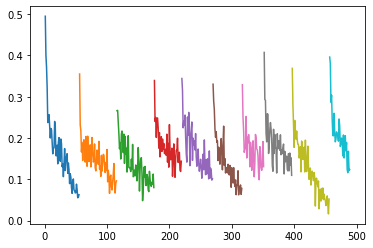

In [27]:
loss_plot(ewc_total_loss_dropout_earlystopping)

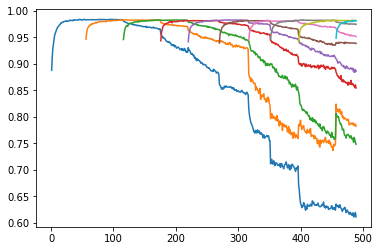

In [28]:
accuracy_plot(ewc_prec_dropout_earlystopping)

In [9]:
#dropout, early stopping, wider layers, higher lambda
hidden_size1 = 1500
hidden_size2 = 1000
lamda = 3000

In [30]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_optimised)

# run the standard experiment.
consolidate = False
(standard_prec_optimised,
 standard_total_loss_optimised,
 standard_ce_loss_optimised, 
 standard_ewc_loss_optimised) =train(
    mlp_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4511 / ewc: 0.0 / total: 0.4511: : 469it [00:16, 27.65it/s]


Validation loss decreased (inf --> 0.355353).  Saving model ...


=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.377 / ewc: 0.0 / total: 0.377: : 469it [00:16, 27.73it/s]    


Validation loss decreased (0.355353 --> 0.269128).  Saving model ...


=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3163 / ewc: 0.0 / total: 0.3163: : 469it [00:16, 27.70it/s]  


Validation loss decreased (0.269128 --> 0.220143).  Saving model ...


=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2444 / ewc: 0.0 / total: 0.2444: : 469it [00:16, 27.88it/s]  


Validation loss decreased (0.220143 --> 0.184630).  Saving model ...


=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2613 / ewc: 0.0 / total: 0.2613: : 469it [00:16, 27.68it/s]  


Validation loss decreased (0.184630 --> 0.159274).  Saving model ...


=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2296 / ewc: 0.0 / total: 0.2296: : 469it [00:16, 27.76it/s] 


Validation loss decreased (0.159274 --> 0.138680).  Saving model ...


=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2134 / ewc: 0.0 / total: 0.2134: : 469it [00:16, 27.68it/s]  


Validation loss decreased (0.138680 --> 0.126028).  Saving model ...


=> task: 1/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1983 / ewc: 0.0 / total: 0.1983: : 469it [00:16, 27.76it/s] 


Validation loss decreased (0.126028 --> 0.112379).  Saving model ...


=> task: 1/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2023 / ewc: 0.0 / total: 0.2023: : 469it [00:16, 27.79it/s] 


Validation loss decreased (0.112379 --> 0.104551).  Saving model ...


=> task: 1/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2022 / ewc: 0.0 / total: 0.2022: : 469it [00:16, 27.82it/s]  


Validation loss decreased (0.104551 --> 0.097798).  Saving model ...


=> task: 1/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2234 / ewc: 0.0 / total: 0.2234: : 469it [00:16, 27.93it/s] 


Validation loss decreased (0.097798 --> 0.091755).  Saving model ...


=> task: 1/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2039 / ewc: 0.0 / total: 0.2039: : 469it [00:16, 27.83it/s] 


Validation loss decreased (0.091755 --> 0.086040).  Saving model ...


=> task: 1/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1477 / ewc: 0.0 / total: 0.1477: : 469it [00:16, 27.86it/s]  


Validation loss decreased (0.086040 --> 0.082368).  Saving model ...


=> task: 1/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1812 / ewc: 0.0 / total: 0.1812: : 469it [00:16, 27.77it/s] 


Validation loss decreased (0.082368 --> 0.078686).  Saving model ...


=> task: 1/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.204 / ewc: 0.0 / total: 0.204: : 469it [00:16, 27.73it/s]    


Validation loss decreased (0.078686 --> 0.076312).  Saving model ...


=> task: 1/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1838 / ewc: 0.0 / total: 0.1838: : 469it [00:18, 25.64it/s] 


Validation loss decreased (0.076312 --> 0.073563).  Saving model ...


=> task: 1/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2105 / ewc: 0.0 / total: 0.2105: : 469it [00:17, 26.36it/s] 


Validation loss decreased (0.073563 --> 0.070227).  Saving model ...


=> task: 1/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1326 / ewc: 0.0 / total: 0.1326: : 469it [00:16, 27.92it/s] 


Validation loss decreased (0.070227 --> 0.068298).  Saving model ...


=> task: 1/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1969 / ewc: 0.0 / total: 0.1969: : 469it [00:16, 27.95it/s]  


Validation loss decreased (0.068298 --> 0.066061).  Saving model ...


=> task: 1/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1755 / ewc: 0.0 / total: 0.1755: : 469it [00:16, 27.96it/s] 


Validation loss decreased (0.066061 --> 0.065085).  Saving model ...


=> task: 1/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1492 / ewc: 0.0 / total: 0.1492: : 469it [00:16, 28.10it/s]  


Validation loss decreased (0.065085 --> 0.064532).  Saving model ...


=> task: 1/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1319 / ewc: 0.0 / total: 0.1319: : 469it [00:16, 28.05it/s]  


Validation loss decreased (0.064532 --> 0.062811).  Saving model ...


=> task: 1/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1604 / ewc: 0.0 / total: 0.1604: : 469it [00:16, 27.96it/s] 


Validation loss decreased (0.062811 --> 0.062184).  Saving model ...


=> task: 1/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1511 / ewc: 0.0 / total: 0.1511: : 469it [00:16, 28.23it/s] 


Validation loss decreased (0.062184 --> 0.060547).  Saving model ...


=> task: 1/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1548 / ewc: 0.0 / total: 0.1548: : 469it [00:16, 28.12it/s] 


Validation loss decreased (0.060547 --> 0.059922).  Saving model ...


=> task: 1/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1476 / ewc: 0.0 / total: 0.1476: : 469it [00:16, 27.98it/s]   


Validation loss decreased (0.059922 --> 0.058882).  Saving model ...


=> task: 1/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1421 / ewc: 0.0 / total: 0.1421: : 469it [00:16, 28.03it/s] 


Validation loss decreased (0.058882 --> 0.058557).  Saving model ...


=> task: 1/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1502 / ewc: 0.0 / total: 0.1502: : 469it [00:16, 28.03it/s]   


Validation loss decreased (0.058557 --> 0.058399).  Saving model ...


=> task: 1/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1455 / ewc: 0.0 / total: 0.1455: : 469it [00:16, 27.96it/s]   


Validation loss decreased (0.058399 --> 0.057778).  Saving model ...


=> task: 1/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1419 / ewc: 0.0 / total: 0.1419: : 469it [00:16, 28.16it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1117 / ewc: 0.0 / total: 0.1117: : 469it [00:16, 28.07it/s]   


Validation loss decreased (0.057778 --> 0.057541).  Saving model ...


=> task: 1/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1468 / ewc: 0.0 / total: 0.1468: : 469it [00:16, 28.17it/s] 


Validation loss decreased (0.057541 --> 0.056536).  Saving model ...


=> task: 1/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1536 / ewc: 0.0 / total: 0.1536: : 469it [00:16, 27.97it/s]  


Validation loss decreased (0.056536 --> 0.056183).  Saving model ...


=> task: 1/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1033 / ewc: 0.0 / total: 0.1033: : 469it [00:16, 28.35it/s] 


Validation loss decreased (0.056183 --> 0.054616).  Saving model ...


=> task: 1/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.134 / ewc: 0.0 / total: 0.134: : 469it [00:16, 27.85it/s]     


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.0 / total: 0.1152: : 469it [00:16, 27.98it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.102 / ewc: 0.0 / total: 0.102: : 469it [00:16, 28.15it/s]    


Validation loss decreased (0.054616 --> 0.053937).  Saving model ...


=> task: 1/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09037 / ewc: 0.0 / total: 0.09037: : 469it [00:17, 26.80it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1137 / ewc: 0.0 / total: 0.1137: : 469it [00:18, 25.52it/s]  


Validation loss decreased (0.053937 --> 0.053261).  Saving model ...


=> task: 1/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1026 / ewc: 0.0 / total: 0.1026: : 469it [00:18, 25.33it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1097 / ewc: 0.0 / total: 0.1097: : 469it [00:18, 24.84it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1358 / ewc: 0.0 / total: 0.1358: : 469it [00:18, 24.96it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09276 / ewc: 0.0 / total: 0.09276: : 469it [00:18, 24.94it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06031 / ewc: 0.0 / total: 0.06031: : 469it [00:18, 24.95it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.235 / ewc: 0.0 / total: 0.235: : 469it [00:19, 24.40it/s]    


Validation loss decreased (inf --> 0.152591).  Saving model ...


=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2044 / ewc: 0.0 / total: 0.2044: : 469it [00:18, 25.22it/s]  


Validation loss decreased (0.152591 --> 0.109400).  Saving model ...


=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2055 / ewc: 0.0 / total: 0.2055: : 469it [00:18, 25.45it/s]  


Validation loss decreased (0.109400 --> 0.093951).  Saving model ...


=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1925 / ewc: 0.0 / total: 0.1925: : 469it [00:18, 25.12it/s]  


Validation loss decreased (0.093951 --> 0.081983).  Saving model ...


=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1711 / ewc: 0.0 / total: 0.1711: : 469it [00:18, 25.13it/s] 


Validation loss decreased (0.081983 --> 0.075230).  Saving model ...


=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1449 / ewc: 0.0 / total: 0.1449: : 469it [00:18, 25.15it/s] 


Validation loss decreased (0.075230 --> 0.073540).  Saving model ...


=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1575 / ewc: 0.0 / total: 0.1575: : 469it [00:18, 25.01it/s] 


Validation loss decreased (0.073540 --> 0.067116).  Saving model ...


=> task: 2/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1607 / ewc: 0.0 / total: 0.1607: : 469it [00:17, 26.23it/s] 


Validation loss decreased (0.067116 --> 0.066551).  Saving model ...


=> task: 2/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1813 / ewc: 0.0 / total: 0.1813: : 469it [00:18, 25.61it/s] 


Validation loss decreased (0.066551 --> 0.063461).  Saving model ...


=> task: 2/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1421 / ewc: 0.0 / total: 0.1421: : 469it [00:18, 25.53it/s] 


Validation loss decreased (0.063461 --> 0.060802).  Saving model ...


=> task: 2/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1617 / ewc: 0.0 / total: 0.1617: : 469it [00:18, 24.81it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1446 / ewc: 0.0 / total: 0.1446: : 469it [00:18, 24.93it/s] 


Validation loss decreased (0.060802 --> 0.059277).  Saving model ...


=> task: 2/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1072 / ewc: 0.0 / total: 0.1072: : 469it [00:18, 24.91it/s] 


Validation loss decreased (0.059277 --> 0.056655).  Saving model ...


=> task: 2/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1081 / ewc: 0.0 / total: 0.1081: : 469it [00:18, 24.83it/s] 


Validation loss decreased (0.056655 --> 0.056421).  Saving model ...


=> task: 2/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1983 / ewc: 0.0 / total: 0.1983: : 469it [00:18, 25.12it/s] 


Validation loss decreased (0.056421 --> 0.055825).  Saving model ...


=> task: 2/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1389 / ewc: 0.0 / total: 0.1389: : 469it [00:18, 25.24it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1409 / ewc: 0.0 / total: 0.1409: : 469it [00:18, 25.22it/s]    


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1389 / ewc: 0.0 / total: 0.1389: : 469it [00:18, 25.24it/s]   


Validation loss decreased (0.055825 --> 0.055029).  Saving model ...


=> task: 2/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.107 / ewc: 0.0 / total: 0.107: : 469it [00:18, 25.19it/s]    


Validation loss decreased (0.055029 --> 0.054489).  Saving model ...


=> task: 2/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.128 / ewc: 0.0 / total: 0.128: : 469it [00:18, 24.96it/s]    


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09322 / ewc: 0.0 / total: 0.09322: : 469it [00:17, 27.40it/s]


Validation loss decreased (0.054489 --> 0.053332).  Saving model ...


=> task: 2/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1112 / ewc: 0.0 / total: 0.1112: : 469it [00:18, 25.63it/s]   


Validation loss decreased (0.053332 --> 0.052170).  Saving model ...


=> task: 2/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06678 / ewc: 0.0 / total: 0.06678: : 469it [00:18, 25.16it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1067 / ewc: 0.0 / total: 0.1067: : 469it [00:18, 25.18it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1153 / ewc: 0.0 / total: 0.1153: : 469it [00:18, 25.08it/s]   


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07233 / ewc: 0.0 / total: 0.07233: : 469it [00:18, 25.17it/s]


EarlyStopping counter: 4 out of 5


=> task: 2/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07887 / ewc: 0.0 / total: 0.07887: : 469it [00:18, 25.11it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2478 / ewc: 0.0 / total: 0.2478: : 469it [00:19, 24.35it/s]  


Validation loss decreased (inf --> 0.136306).  Saving model ...


=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2276 / ewc: 0.0 / total: 0.2276: : 469it [00:18, 24.80it/s]  


Validation loss decreased (0.136306 --> 0.097050).  Saving model ...


=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1987 / ewc: 0.0 / total: 0.1987: : 469it [00:18, 25.29it/s]  


Validation loss decreased (0.097050 --> 0.083634).  Saving model ...


=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1989 / ewc: 0.0 / total: 0.1989: : 469it [00:18, 25.29it/s]  


Validation loss decreased (0.083634 --> 0.074605).  Saving model ...


=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1886 / ewc: 0.0 / total: 0.1886: : 469it [00:18, 24.96it/s] 


Validation loss decreased (0.074605 --> 0.071633).  Saving model ...


=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1619 / ewc: 0.0 / total: 0.1619: : 469it [00:18, 24.96it/s] 


Validation loss decreased (0.071633 --> 0.068897).  Saving model ...


=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1741 / ewc: 0.0 / total: 0.1741: : 469it [00:18, 24.87it/s] 


Validation loss decreased (0.068897 --> 0.065332).  Saving model ...


=> task: 3/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1289 / ewc: 0.0 / total: 0.1289: : 469it [00:18, 24.97it/s] 


Validation loss decreased (0.065332 --> 0.063076).  Saving model ...


=> task: 3/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1392 / ewc: 0.0 / total: 0.1392: : 469it [00:18, 25.16it/s] 


Validation loss decreased (0.063076 --> 0.059039).  Saving model ...


=> task: 3/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1473 / ewc: 0.0 / total: 0.1473: : 469it [00:18, 25.11it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1183 / ewc: 0.0 / total: 0.1183: : 469it [00:18, 25.28it/s]  


Validation loss decreased (0.059039 --> 0.057601).  Saving model ...


=> task: 3/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1144 / ewc: 0.0 / total: 0.1144: : 469it [00:18, 25.66it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1521 / ewc: 0.0 / total: 0.1521: : 469it [00:18, 25.05it/s]   


Validation loss decreased (0.057601 --> 0.056559).  Saving model ...


=> task: 3/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1361 / ewc: 0.0 / total: 0.1361: : 469it [00:18, 25.13it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1013 / ewc: 0.0 / total: 0.1013: : 469it [00:18, 24.97it/s]   


Validation loss decreased (0.056559 --> 0.054611).  Saving model ...


=> task: 3/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1294 / ewc: 0.0 / total: 0.1294: : 469it [00:18, 25.65it/s]  


Validation loss decreased (0.054611 --> 0.054483).  Saving model ...


=> task: 3/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08742 / ewc: 0.0 / total: 0.08742: : 469it [00:18, 25.38it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07953 / ewc: 0.0 / total: 0.07953: : 469it [00:18, 24.80it/s] 


Validation loss decreased (0.054483 --> 0.053696).  Saving model ...


=> task: 3/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07434 / ewc: 0.0 / total: 0.07434: : 469it [00:18, 24.79it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06093 / ewc: 0.0 / total: 0.06093: : 469it [00:18, 24.85it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06931 / ewc: 0.0 / total: 0.06931: : 469it [00:18, 24.88it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03493 / ewc: 0.0 / total: 0.03493: : 469it [00:18, 25.23it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06794 / ewc: 0.0 / total: 0.06794: : 469it [00:18, 25.12it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2469 / ewc: 0.0 / total: 0.2469: : 469it [00:19, 24.61it/s] 


Validation loss decreased (inf --> 0.138026).  Saving model ...


=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2114 / ewc: 0.0 / total: 0.2114: : 469it [00:18, 25.07it/s] 


Validation loss decreased (0.138026 --> 0.097016).  Saving model ...


=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1603 / ewc: 0.0 / total: 0.1603: : 469it [00:18, 25.01it/s] 


Validation loss decreased (0.097016 --> 0.079835).  Saving model ...


=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1595 / ewc: 0.0 / total: 0.1595: : 469it [00:18, 25.02it/s] 


Validation loss decreased (0.079835 --> 0.074908).  Saving model ...


=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1665 / ewc: 0.0 / total: 0.1665: : 469it [00:18, 25.18it/s] 


Validation loss decreased (0.074908 --> 0.068334).  Saving model ...


=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1607 / ewc: 0.0 / total: 0.1607: : 469it [00:18, 24.82it/s]  


Validation loss decreased (0.068334 --> 0.066611).  Saving model ...


=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1403 / ewc: 0.0 / total: 0.1403: : 469it [00:18, 24.88it/s] 


Validation loss decreased (0.066611 --> 0.063664).  Saving model ...


=> task: 4/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1247 / ewc: 0.0 / total: 0.1247: : 469it [00:18, 24.95it/s] 


Validation loss decreased (0.063664 --> 0.061097).  Saving model ...


=> task: 4/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1234 / ewc: 0.0 / total: 0.1234: : 469it [00:18, 24.95it/s] 


Validation loss decreased (0.061097 --> 0.059868).  Saving model ...


=> task: 4/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1445 / ewc: 0.0 / total: 0.1445: : 469it [00:18, 25.24it/s] 


Validation loss decreased (0.059868 --> 0.057295).  Saving model ...


=> task: 4/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.175 / ewc: 0.0 / total: 0.175: : 469it [00:18, 25.11it/s]   


Validation loss decreased (0.057295 --> 0.056448).  Saving model ...


=> task: 4/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1172 / ewc: 0.0 / total: 0.1172: : 469it [00:18, 25.03it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1124 / ewc: 0.0 / total: 0.1124: : 469it [00:18, 25.05it/s]   


Validation loss decreased (0.056448 --> 0.055826).  Saving model ...


=> task: 4/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1336 / ewc: 0.0 / total: 0.1336: : 469it [00:18, 24.79it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1282 / ewc: 0.0 / total: 0.1282: : 469it [00:18, 25.34it/s]  


Validation loss decreased (0.055826 --> 0.053529).  Saving model ...


=> task: 4/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1046 / ewc: 0.0 / total: 0.1046: : 469it [00:18, 25.43it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1083 / ewc: 0.0 / total: 0.1083: : 469it [00:18, 24.93it/s]   


Validation loss decreased (0.053529 --> 0.053372).  Saving model ...


=> task: 4/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06369 / ewc: 0.0 / total: 0.06369: : 469it [00:18, 24.83it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09382 / ewc: 0.0 / total: 0.09382: : 469it [00:18, 24.89it/s] 


Validation loss decreased (0.053372 --> 0.051305).  Saving model ...


=> task: 4/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0523 / ewc: 0.0 / total: 0.0523: : 469it [00:18, 25.03it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06282 / ewc: 0.0 / total: 0.06282: : 469it [00:18, 25.08it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.06765 / ewc: 0.0 / total: 0.06765: : 469it [00:18, 25.11it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05546 / ewc: 0.0 / total: 0.05546: : 469it [00:18, 25.11it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04464 / ewc: 0.0 / total: 0.04464: : 469it [00:18, 25.08it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2477 / ewc: 0.0 / total: 0.2477: : 469it [00:19, 24.51it/s] 


Validation loss decreased (inf --> 0.117864).  Saving model ...


=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1783 / ewc: 0.0 / total: 0.1783: : 469it [00:18, 24.94it/s]  


Validation loss decreased (0.117864 --> 0.088631).  Saving model ...


=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2229 / ewc: 0.0 / total: 0.2229: : 469it [00:18, 24.90it/s] 


Validation loss decreased (0.088631 --> 0.078592).  Saving model ...


=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1757 / ewc: 0.0 / total: 0.1757: : 469it [00:18, 25.48it/s]  


Validation loss decreased (0.078592 --> 0.070831).  Saving model ...


=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1633 / ewc: 0.0 / total: 0.1633: : 469it [00:18, 25.28it/s] 


Validation loss decreased (0.070831 --> 0.064037).  Saving model ...


=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.176 / ewc: 0.0 / total: 0.176: : 469it [00:18, 24.76it/s]   


Validation loss decreased (0.064037 --> 0.062887).  Saving model ...


=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1758 / ewc: 0.0 / total: 0.1758: : 469it [00:19, 24.49it/s]   


Validation loss decreased (0.062887 --> 0.058755).  Saving model ...


=> task: 5/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1647 / ewc: 0.0 / total: 0.1647: : 469it [00:18, 25.20it/s] 


Validation loss decreased (0.058755 --> 0.056910).  Saving model ...


=> task: 5/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1541 / ewc: 0.0 / total: 0.1541: : 469it [00:18, 24.92it/s] 


Validation loss decreased (0.056910 --> 0.056092).  Saving model ...


=> task: 5/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1376 / ewc: 0.0 / total: 0.1376: : 469it [00:18, 25.07it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:18, 25.16it/s] 


Validation loss decreased (0.056092 --> 0.054964).  Saving model ...


=> task: 5/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1429 / ewc: 0.0 / total: 0.1429: : 469it [00:18, 25.11it/s]   


Validation loss decreased (0.054964 --> 0.054047).  Saving model ...


=> task: 5/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.0 / total: 0.1152: : 469it [00:18, 25.15it/s]  


Validation loss decreased (0.054047 --> 0.053910).  Saving model ...


=> task: 5/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1177 / ewc: 0.0 / total: 0.1177: : 469it [00:18, 25.04it/s]    


Validation loss decreased (0.053910 --> 0.053434).  Saving model ...


=> task: 5/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07168 / ewc: 0.0 / total: 0.07168: : 469it [00:18, 24.93it/s] 


Validation loss decreased (0.053434 --> 0.051936).  Saving model ...


=> task: 5/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09965 / ewc: 0.0 / total: 0.09965: : 469it [00:18, 25.63it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09676 / ewc: 0.0 / total: 0.09676: : 469it [00:18, 25.67it/s] 


Validation loss decreased (0.051936 --> 0.050957).  Saving model ...


=> task: 5/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1055 / ewc: 0.0 / total: 0.1055: : 469it [00:18, 24.80it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1048 / ewc: 0.0 / total: 0.1048: : 469it [00:18, 24.83it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1091 / ewc: 0.0 / total: 0.1091: : 469it [00:18, 24.85it/s]   


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07525 / ewc: 0.0 / total: 0.07525: : 469it [00:18, 24.84it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04382 / ewc: 0.0 / total: 0.04382: : 469it [00:18, 25.10it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2251 / ewc: 0.0 / total: 0.2251: : 469it [00:19, 24.60it/s]  


Validation loss decreased (inf --> 0.119770).  Saving model ...


=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2125 / ewc: 0.0 / total: 0.2125: : 469it [00:18, 25.01it/s] 


Validation loss decreased (0.119770 --> 0.089583).  Saving model ...


=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.17 / ewc: 0.0 / total: 0.17: : 469it [00:17, 26.61it/s]      


Validation loss decreased (0.089583 --> 0.077524).  Saving model ...


=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1443 / ewc: 0.0 / total: 0.1443: : 469it [00:18, 24.99it/s] 


Validation loss decreased (0.077524 --> 0.071128).  Saving model ...


=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1819 / ewc: 0.0 / total: 0.1819: : 469it [00:18, 25.04it/s] 


Validation loss decreased (0.071128 --> 0.065000).  Saving model ...


=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1746 / ewc: 0.0 / total: 0.1746: : 469it [00:18, 25.17it/s]  


Validation loss decreased (0.065000 --> 0.061011).  Saving model ...


=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.0 / total: 0.1305: : 469it [00:18, 25.19it/s] 


Validation loss decreased (0.061011 --> 0.058570).  Saving model ...


=> task: 6/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.0 / total: 0.1305: : 469it [00:18, 25.03it/s]    


Validation loss decreased (0.058570 --> 0.057023).  Saving model ...


=> task: 6/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1244 / ewc: 0.0 / total: 0.1244: : 469it [00:18, 25.00it/s]  


Validation loss decreased (0.057023 --> 0.055331).  Saving model ...


=> task: 6/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1579 / ewc: 0.0 / total: 0.1579: : 469it [00:16, 27.96it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1263 / ewc: 0.0 / total: 0.1263: : 469it [00:17, 26.38it/s]  


Validation loss decreased (0.055331 --> 0.054669).  Saving model ...


=> task: 6/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1114 / ewc: 0.0 / total: 0.1114: : 469it [00:19, 24.62it/s]  


Validation loss decreased (0.054669 --> 0.054343).  Saving model ...


=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.104 / ewc: 0.0 / total: 0.104: : 469it [00:18, 25.26it/s]    


Validation loss decreased (0.054343 --> 0.054171).  Saving model ...


=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1344 / ewc: 0.0 / total: 0.1344: : 469it [00:18, 24.91it/s]   


Validation loss decreased (0.054171 --> 0.054093).  Saving model ...


=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08436 / ewc: 0.0 / total: 0.08436: : 469it [00:18, 25.06it/s] 


Validation loss decreased (0.054093 --> 0.053610).  Saving model ...


=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06969 / ewc: 0.0 / total: 0.06969: : 469it [00:18, 24.88it/s] 


Validation loss decreased (0.053610 --> 0.053423).  Saving model ...


=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07082 / ewc: 0.0 / total: 0.07082: : 469it [00:18, 24.82it/s] 


Validation loss decreased (0.053423 --> 0.052420).  Saving model ...


=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08893 / ewc: 0.0 / total: 0.08893: : 469it [00:18, 24.99it/s] 


Validation loss decreased (0.052420 --> 0.051820).  Saving model ...


=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02896 / ewc: 0.0 / total: 0.02896: : 469it [00:19, 24.43it/s] 


Validation loss decreased (0.051820 --> 0.050898).  Saving model ...


=> task: 6/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05092 / ewc: 0.0 / total: 0.05092: : 469it [00:18, 25.09it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04226 / ewc: 0.0 / total: 0.04226: : 469it [00:18, 25.84it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03903 / ewc: 0.0 / total: 0.03903: : 469it [00:18, 25.11it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01566 / ewc: 0.0 / total: 0.01566: : 469it [00:18, 25.42it/s] 


Validation loss decreased (0.050898 --> 0.050067).  Saving model ...


=> task: 6/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01437 / ewc: 0.0 / total: 0.01437: : 469it [00:18, 25.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01594 / ewc: 0.0 / total: 0.01594: : 469it [00:18, 25.49it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.009571 / ewc: 0.0 / total: 0.009571: : 469it [00:18, 25.18it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.002469 / ewc: 0.0 / total: 0.002469: : 469it [00:18, 25.24it/s]  


Validation loss decreased (0.050067 --> 0.049880).  Saving model ...


=> task: 6/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.00185 / ewc: 0.0 / total: 0.00185: : 469it [00:18, 25.36it/s]    


Validation loss decreased (0.049880 --> 0.049622).  Saving model ...


=> task: 6/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.004428 / ewc: 0.0 / total: 0.004428: : 469it [00:18, 25.32it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.005097 / ewc: 0.0 / total: 0.005097: : 469it [00:18, 25.34it/s]  


Validation loss decreased (0.049622 --> 0.049229).  Saving model ...


=> task: 6/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.005863 / ewc: 0.0 / total: 0.005863: : 469it [00:18, 25.27it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003599 / ewc: 0.0 / total: 0.003599: : 469it [00:18, 25.33it/s]  


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01466 / ewc: 0.0 / total: 0.01466: : 469it [00:18, 25.00it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.003313 / ewc: 0.0 / total: 0.003313: : 469it [00:18, 25.45it/s]  


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.001315 / ewc: 0.0 / total: 0.001315: : 469it [00:18, 25.47it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1938 / ewc: 0.0 / total: 0.1938: : 469it [00:19, 24.53it/s] 


Validation loss decreased (inf --> 0.116533).  Saving model ...


=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1988 / ewc: 0.0 / total: 0.1988: : 469it [00:18, 25.27it/s]  


Validation loss decreased (0.116533 --> 0.091233).  Saving model ...


=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1805 / ewc: 0.0 / total: 0.1805: : 469it [00:18, 25.12it/s] 


Validation loss decreased (0.091233 --> 0.077807).  Saving model ...


=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1532 / ewc: 0.0 / total: 0.1532: : 469it [00:18, 25.81it/s] 


Validation loss decreased (0.077807 --> 0.073123).  Saving model ...


=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1366 / ewc: 0.0 / total: 0.1366: : 469it [00:24, 19.12it/s] 


Validation loss decreased (0.073123 --> 0.068418).  Saving model ...


=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1683 / ewc: 0.0 / total: 0.1683: : 469it [00:31, 14.78it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1523 / ewc: 0.0 / total: 0.1523: : 469it [00:28, 16.68it/s] 


Validation loss decreased (0.068418 --> 0.062192).  Saving model ...


=> task: 7/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1874 / ewc: 0.0 / total: 0.1874: : 469it [00:26, 17.49it/s] 


Validation loss decreased (0.062192 --> 0.059859).  Saving model ...


=> task: 7/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1519 / ewc: 0.0 / total: 0.1519: : 469it [00:27, 17.04it/s] 


Validation loss decreased (0.059859 --> 0.058606).  Saving model ...


=> task: 7/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1245 / ewc: 0.0 / total: 0.1245: : 469it [00:25, 18.51it/s]  


Validation loss decreased (0.058606 --> 0.056958).  Saving model ...


=> task: 7/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1013 / ewc: 0.0 / total: 0.1013: : 469it [00:29, 16.09it/s]  


Validation loss decreased (0.056958 --> 0.056444).  Saving model ...


=> task: 7/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1259 / ewc: 0.0 / total: 0.1259: : 469it [00:25, 18.11it/s]   


Validation loss decreased (0.056444 --> 0.056046).  Saving model ...


=> task: 7/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1275 / ewc: 0.0 / total: 0.1275: : 469it [00:28, 16.69it/s]   


Validation loss decreased (0.056046 --> 0.054728).  Saving model ...


=> task: 7/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1437 / ewc: 0.0 / total: 0.1437: : 469it [00:27, 17.11it/s]   


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.108 / ewc: 0.0 / total: 0.108: : 469it [00:25, 18.23it/s]     


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1041 / ewc: 0.0 / total: 0.1041: : 469it [00:27, 16.99it/s]    


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1323 / ewc: 0.0 / total: 0.1323: : 469it [00:26, 17.78it/s]   


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0488 / ewc: 0.0 / total: 0.0488: : 469it [00:28, 16.38it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1936 / ewc: 0.0 / total: 0.1936: : 469it [00:28, 16.57it/s] 


Validation loss decreased (inf --> 0.119949).  Saving model ...


=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1851 / ewc: 0.0 / total: 0.1851: : 469it [00:25, 18.50it/s] 


Validation loss decreased (0.119949 --> 0.090545).  Saving model ...


=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1765 / ewc: 0.0 / total: 0.1765: : 469it [00:27, 17.15it/s] 


Validation loss decreased (0.090545 --> 0.083675).  Saving model ...


=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1223 / ewc: 0.0 / total: 0.1223: : 469it [00:27, 17.13it/s]  


Validation loss decreased (0.083675 --> 0.070011).  Saving model ...


=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1617 / ewc: 0.0 / total: 0.1617: : 469it [00:26, 17.64it/s]   


Validation loss decreased (0.070011 --> 0.066500).  Saving model ...


=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1122 / ewc: 0.0 / total: 0.1122: : 469it [00:27, 17.02it/s] 


Validation loss decreased (0.066500 --> 0.061267).  Saving model ...


=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1157 / ewc: 0.0 / total: 0.1157: : 469it [00:25, 18.40it/s]   


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1126 / ewc: 0.0 / total: 0.1126: : 469it [00:28, 16.69it/s] 


Validation loss decreased (0.061267 --> 0.060771).  Saving model ...


=> task: 8/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1301 / ewc: 0.0 / total: 0.1301: : 469it [00:25, 18.45it/s]  


Validation loss decreased (0.060771 --> 0.057865).  Saving model ...


=> task: 8/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1117 / ewc: 0.0 / total: 0.1117: : 469it [00:26, 17.47it/s]   


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1041 / ewc: 0.0 / total: 0.1041: : 469it [00:27, 16.94it/s]   


Validation loss decreased (0.057865 --> 0.057576).  Saving model ...


=> task: 8/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0627 / ewc: 0.0 / total: 0.0627: : 469it [00:25, 18.53it/s]   


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07375 / ewc: 0.0 / total: 0.07375: : 469it [00:28, 16.66it/s] 


Validation loss decreased (0.057576 --> 0.056517).  Saving model ...


=> task: 8/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07796 / ewc: 0.0 / total: 0.07796: : 469it [00:27, 17.04it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09151 / ewc: 0.0 / total: 0.09151: : 469it [00:26, 17.69it/s] 


Validation loss decreased (0.056517 --> 0.054543).  Saving model ...


=> task: 8/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03129 / ewc: 0.0 / total: 0.03129: : 469it [00:29, 15.96it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05144 / ewc: 0.0 / total: 0.05144: : 469it [00:27, 17.26it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01567 / ewc: 0.0 / total: 0.01567: : 469it [00:27, 16.78it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05254 / ewc: 0.0 / total: 0.05254: : 469it [00:27, 16.87it/s] 


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03511 / ewc: 0.0 / total: 0.03511: : 469it [00:26, 17.45it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2473 / ewc: 0.0 / total: 0.2473: : 469it [00:31, 14.96it/s]  


Validation loss decreased (inf --> 0.113081).  Saving model ...


=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2207 / ewc: 0.0 / total: 0.2207: : 469it [00:27, 17.18it/s]  


Validation loss decreased (0.113081 --> 0.085528).  Saving model ...


=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2278 / ewc: 0.0 / total: 0.2278: : 469it [00:26, 18.00it/s] 


Validation loss decreased (0.085528 --> 0.073535).  Saving model ...


=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.143 / ewc: 0.0 / total: 0.143: : 469it [00:26, 17.62it/s]   


Validation loss decreased (0.073535 --> 0.068340).  Saving model ...


=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1744 / ewc: 0.0 / total: 0.1744: : 469it [00:23, 19.76it/s] 


Validation loss decreased (0.068340 --> 0.063741).  Saving model ...


=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1778 / ewc: 0.0 / total: 0.1778: : 469it [00:27, 17.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1297 / ewc: 0.0 / total: 0.1297: : 469it [00:27, 17.20it/s] 


Validation loss decreased (0.063741 --> 0.058149).  Saving model ...


=> task: 9/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1785 / ewc: 0.0 / total: 0.1785: : 469it [00:27, 16.77it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1566 / ewc: 0.0 / total: 0.1566: : 469it [00:27, 17.25it/s]  


Validation loss decreased (0.058149 --> 0.056169).  Saving model ...


=> task: 9/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1499 / ewc: 0.0 / total: 0.1499: : 469it [00:29, 15.90it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1657 / ewc: 0.0 / total: 0.1657: : 469it [00:27, 17.08it/s]   


Validation loss decreased (0.056169 --> 0.056037).  Saving model ...


=> task: 9/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1146 / ewc: 0.0 / total: 0.1146: : 469it [00:26, 17.80it/s]   


Validation loss decreased (0.056037 --> 0.053946).  Saving model ...


=> task: 9/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1008 / ewc: 0.0 / total: 0.1008: : 469it [00:29, 15.95it/s]  


Validation loss decreased (0.053946 --> 0.053806).  Saving model ...


=> task: 9/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09437 / ewc: 0.0 / total: 0.09437: : 469it [00:26, 17.98it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09698 / ewc: 0.0 / total: 0.09698: : 469it [00:27, 17.27it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1062 / ewc: 0.0 / total: 0.1062: : 469it [00:27, 17.05it/s]  


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07998 / ewc: 0.0 / total: 0.07998: : 469it [00:25, 18.63it/s] 


Validation loss decreased (0.053806 --> 0.053096).  Saving model ...


=> task: 9/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04751 / ewc: 0.0 / total: 0.04751: : 469it [00:29, 16.03it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08169 / ewc: 0.0 / total: 0.08169: : 469it [00:27, 17.07it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0679 / ewc: 0.0 / total: 0.0679: : 469it [00:26, 17.54it/s]   


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08925 / ewc: 0.0 / total: 0.08925: : 469it [00:28, 16.70it/s] 


Validation loss decreased (0.053096 --> 0.052674).  Saving model ...


=> task: 9/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06481 / ewc: 0.0 / total: 0.06481: : 469it [00:27, 16.87it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05141 / ewc: 0.0 / total: 0.05141: : 469it [00:27, 17.20it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02416 / ewc: 0.0 / total: 0.02416: : 469it [00:28, 16.52it/s] 


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0174 / ewc: 0.0 / total: 0.0174: : 469it [00:28, 16.32it/s]   


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04502 / ewc: 0.0 / total: 0.04502: : 469it [00:25, 18.75it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2471 / ewc: 0.0 / total: 0.2471: : 469it [00:27, 17.12it/s]  


Validation loss decreased (inf --> 0.118922).  Saving model ...


=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2397 / ewc: 0.0 / total: 0.2397: : 469it [00:29, 16.15it/s] 


Validation loss decreased (0.118922 --> 0.088632).  Saving model ...


=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2292 / ewc: 0.0 / total: 0.2292: : 469it [00:26, 17.43it/s] 


Validation loss decreased (0.088632 --> 0.075033).  Saving model ...


=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2014 / ewc: 0.0 / total: 0.2014: : 469it [00:27, 17.12it/s] 


Validation loss decreased (0.075033 --> 0.068316).  Saving model ...


=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1399 / ewc: 0.0 / total: 0.1399: : 469it [00:27, 17.00it/s] 


Validation loss decreased (0.068316 --> 0.065866).  Saving model ...


=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1526 / ewc: 0.0 / total: 0.1526: : 469it [00:24, 19.41it/s] 


Validation loss decreased (0.065866 --> 0.063438).  Saving model ...


=> task: 10/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1534 / ewc: 0.0 / total: 0.1534: : 469it [00:28, 16.57it/s]  


Validation loss decreased (0.063438 --> 0.059990).  Saving model ...


=> task: 10/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1339 / ewc: 0.0 / total: 0.1339: : 469it [00:27, 17.21it/s] 


Validation loss decreased (0.059990 --> 0.059286).  Saving model ...


=> task: 10/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1481 / ewc: 0.0 / total: 0.1481: : 469it [00:25, 18.34it/s]   


Validation loss decreased (0.059286 --> 0.057149).  Saving model ...


=> task: 10/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1207 / ewc: 0.0 / total: 0.1207: : 469it [00:29, 16.15it/s] 


Validation loss decreased (0.057149 --> 0.055084).  Saving model ...


=> task: 10/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1166 / ewc: 0.0 / total: 0.1166: : 469it [00:27, 17.23it/s]   


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1189 / ewc: 0.0 / total: 0.1189: : 469it [00:25, 18.50it/s]   


Validation loss decreased (0.055084 --> 0.054763).  Saving model ...


=> task: 10/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09916 / ewc: 0.0 / total: 0.09916: : 469it [00:27, 16.94it/s] 


Validation loss decreased (0.054763 --> 0.052251).  Saving model ...


=> task: 10/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08655 / ewc: 0.0 / total: 0.08655: : 469it [00:27, 17.21it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09301 / ewc: 0.0 / total: 0.09301: : 469it [00:25, 18.12it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08707 / ewc: 0.0 / total: 0.08707: : 469it [00:29, 16.16it/s] 


Validation loss decreased (0.052251 --> 0.050875).  Saving model ...


=> task: 10/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08605 / ewc: 0.0 / total: 0.08605: : 469it [00:27, 17.09it/s] 


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06915 / ewc: 0.0 / total: 0.06915: : 469it [00:25, 18.10it/s] 


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06094 / ewc: 0.0 / total: 0.06094: : 469it [00:28, 16.46it/s] 


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01624 / ewc: 0.0 / total: 0.01624: : 469it [00:27, 17.17it/s] 


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02334 / ewc: 0.0 / total: 0.02334: : 469it [00:25, 18.21it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


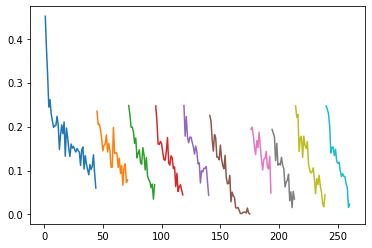

In [32]:
loss_plot(standard_total_loss_optimised)

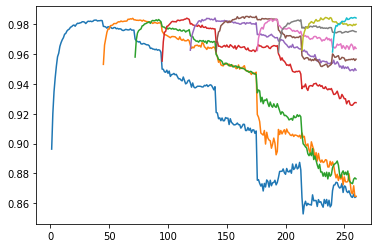

In [33]:
accuracy_plot(standard_prec_optimised)

In [10]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised, 
 ewc_total_loss_optimised,
 ewc_ce_loss_optimised, 
 ewc_ewc_loss_optimised) =train(
    mlp_consolidation_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4675 / ewc: 0.0 / total: 0.4675: : 469it [00:17, 26.15it/s] 


Validation loss decreased (inf --> 0.356596).  Saving model ...


=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3713 / ewc: 0.0 / total: 0.3713: : 469it [00:17, 27.38it/s]  


Validation loss decreased (0.356596 --> 0.266990).  Saving model ...


=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3512 / ewc: 0.0 / total: 0.3512: : 469it [00:17, 27.14it/s]  


Validation loss decreased (0.266990 --> 0.220059).  Saving model ...


=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2861 / ewc: 0.0 / total: 0.2861: : 469it [00:17, 27.57it/s] 


Validation loss decreased (0.220059 --> 0.182697).  Saving model ...


=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2568 / ewc: 0.0 / total: 0.2568: : 469it [00:17, 27.33it/s] 


Validation loss decreased (0.182697 --> 0.159800).  Saving model ...


=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2347 / ewc: 0.0 / total: 0.2347: : 469it [00:16, 28.40it/s]  


Validation loss decreased (0.159800 --> 0.141188).  Saving model ...


=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2199 / ewc: 0.0 / total: 0.2199: : 469it [00:16, 27.83it/s]  


Validation loss decreased (0.141188 --> 0.126083).  Saving model ...


=> task: 1/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2009 / ewc: 0.0 / total: 0.2009: : 469it [00:17, 27.30it/s]  


Validation loss decreased (0.126083 --> 0.114148).  Saving model ...


=> task: 1/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2051 / ewc: 0.0 / total: 0.2051: : 469it [00:17, 27.56it/s] 


Validation loss decreased (0.114148 --> 0.104564).  Saving model ...


=> task: 1/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2031 / ewc: 0.0 / total: 0.2031: : 469it [00:17, 27.40it/s] 


Validation loss decreased (0.104564 --> 0.097831).  Saving model ...


=> task: 1/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1872 / ewc: 0.0 / total: 0.1872: : 469it [00:17, 27.41it/s]  


Validation loss decreased (0.097831 --> 0.092302).  Saving model ...


=> task: 1/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1995 / ewc: 0.0 / total: 0.1995: : 469it [00:17, 27.39it/s] 


Validation loss decreased (0.092302 --> 0.086832).  Saving model ...


=> task: 1/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2053 / ewc: 0.0 / total: 0.2053: : 469it [00:16, 27.68it/s] 


Validation loss decreased (0.086832 --> 0.082060).  Saving model ...


=> task: 1/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.18 / ewc: 0.0 / total: 0.18: : 469it [00:16, 27.70it/s]     


Validation loss decreased (0.082060 --> 0.078525).  Saving model ...


=> task: 1/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1909 / ewc: 0.0 / total: 0.1909: : 469it [00:17, 27.55it/s] 


Validation loss decreased (0.078525 --> 0.076611).  Saving model ...


=> task: 1/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1392 / ewc: 0.0 / total: 0.1392: : 469it [00:17, 27.38it/s] 


Validation loss decreased (0.076611 --> 0.073257).  Saving model ...


=> task: 1/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1627 / ewc: 0.0 / total: 0.1627: : 469it [00:16, 27.67it/s] 


Validation loss decreased (0.073257 --> 0.071604).  Saving model ...


=> task: 1/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1719 / ewc: 0.0 / total: 0.1719: : 469it [00:17, 27.40it/s]  


Validation loss decreased (0.071604 --> 0.069574).  Saving model ...


=> task: 1/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1914 / ewc: 0.0 / total: 0.1914: : 469it [00:17, 27.39it/s] 


Validation loss decreased (0.069574 --> 0.067285).  Saving model ...


=> task: 1/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1353 / ewc: 0.0 / total: 0.1353: : 469it [00:16, 27.69it/s] 


Validation loss decreased (0.067285 --> 0.065471).  Saving model ...


=> task: 1/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1712 / ewc: 0.0 / total: 0.1712: : 469it [00:17, 27.42it/s] 


Validation loss decreased (0.065471 --> 0.064189).  Saving model ...


=> task: 1/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1715 / ewc: 0.0 / total: 0.1715: : 469it [00:16, 27.63it/s] 


Validation loss decreased (0.064189 --> 0.063983).  Saving model ...


=> task: 1/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1764 / ewc: 0.0 / total: 0.1764: : 469it [00:17, 27.43it/s] 


Validation loss decreased (0.063983 --> 0.061513).  Saving model ...


=> task: 1/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1391 / ewc: 0.0 / total: 0.1391: : 469it [00:17, 27.42it/s] 


Validation loss decreased (0.061513 --> 0.060898).  Saving model ...


=> task: 1/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1654 / ewc: 0.0 / total: 0.1654: : 469it [00:17, 27.46it/s] 


Validation loss decreased (0.060898 --> 0.060128).  Saving model ...


=> task: 1/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1601 / ewc: 0.0 / total: 0.1601: : 469it [00:17, 27.45it/s] 


Validation loss decreased (0.060128 --> 0.059787).  Saving model ...


=> task: 1/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1413 / ewc: 0.0 / total: 0.1413: : 469it [00:17, 27.57it/s] 


Validation loss decreased (0.059787 --> 0.058799).  Saving model ...


=> task: 1/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1372 / ewc: 0.0 / total: 0.1372: : 469it [00:16, 27.69it/s] 


Validation loss decreased (0.058799 --> 0.058490).  Saving model ...


=> task: 1/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1385 / ewc: 0.0 / total: 0.1385: : 469it [00:17, 27.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1557 / ewc: 0.0 / total: 0.1557: : 469it [00:17, 27.50it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1317 / ewc: 0.0 / total: 0.1317: : 469it [00:17, 27.52it/s] 


Validation loss decreased (0.058490 --> 0.056921).  Saving model ...


=> task: 1/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1151 / ewc: 0.0 / total: 0.1151: : 469it [00:17, 27.41it/s] 


Validation loss decreased (0.056921 --> 0.056812).  Saving model ...


=> task: 1/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1264 / ewc: 0.0 / total: 0.1264: : 469it [00:17, 27.49it/s]  


Validation loss decreased (0.056812 --> 0.056489).  Saving model ...


=> task: 1/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1378 / ewc: 0.0 / total: 0.1378: : 469it [00:17, 27.45it/s]   


Validation loss decreased (0.056489 --> 0.055752).  Saving model ...


=> task: 1/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1025 / ewc: 0.0 / total: 0.1025: : 469it [00:16, 27.70it/s] 


Validation loss decreased (0.055752 --> 0.055585).  Saving model ...


=> task: 1/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.122 / ewc: 0.0 / total: 0.122: : 469it [00:17, 26.65it/s]    


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.125 / ewc: 0.0 / total: 0.125: : 469it [00:16, 27.84it/s]     


Validation loss decreased (0.055585 --> 0.055450).  Saving model ...


=> task: 1/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1086 / ewc: 0.0 / total: 0.1086: : 469it [00:17, 27.44it/s]   


Validation loss decreased (0.055450 --> 0.055131).  Saving model ...


=> task: 1/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1007 / ewc: 0.0 / total: 0.1007: : 469it [00:16, 27.66it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09916 / ewc: 0.0 / total: 0.09916: : 469it [00:16, 27.67it/s] 


Validation loss decreased (0.055131 --> 0.054226).  Saving model ...


=> task: 1/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09858 / ewc: 0.0 / total: 0.09858: : 469it [00:16, 27.61it/s] 


Validation loss decreased (0.054226 --> 0.054080).  Saving model ...


=> task: 1/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1015 / ewc: 0.0 / total: 0.1015: : 469it [00:16, 29.31it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1012 / ewc: 0.0 / total: 0.1012: : 469it [00:17, 27.48it/s]   


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07583 / ewc: 0.0 / total: 0.07583: : 469it [00:17, 27.43it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.115 / ewc: 0.0 / total: 0.115: : 469it [00:17, 27.48it/s]     


Validation loss decreased (0.054080 --> 0.053292).  Saving model ...


=> task: 1/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06077 / ewc: 0.0 / total: 0.06077: : 469it [00:17, 27.46it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09534 / ewc: 0.0 / total: 0.09534: : 469it [00:16, 27.62it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08112 / ewc: 0.0 / total: 0.08112: : 469it [00:17, 27.23it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09135 / ewc: 0.0 / total: 0.09135: : 469it [00:17, 27.47it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.087 / ewc: 0.0 / total: 0.087: : 469it [00:17, 27.41it/s]     


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.273 / ewc: 0.02809 / total: 0.3011: : 469it [00:33, 14.02it/s]   


Validation loss decreased (inf --> 0.203539).  Saving model ...


=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2523 / ewc: 0.02224 / total: 0.2745: : 469it [00:33, 14.15it/s] 


Validation loss decreased (0.203539 --> 0.154836).  Saving model ...


=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2206 / ewc: 0.01926 / total: 0.2399: : 469it [00:32, 14.30it/s]  


Validation loss decreased (0.154836 --> 0.131528).  Saving model ...


=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2353 / ewc: 0.01772 / total: 0.253: : 469it [00:32, 14.47it/s]   


Validation loss decreased (0.131528 --> 0.119473).  Saving model ...


=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1879 / ewc: 0.01647 / total: 0.2044: : 469it [00:32, 14.58it/s]  


Validation loss decreased (0.119473 --> 0.109539).  Saving model ...


=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1701 / ewc: 0.01539 / total: 0.1855: : 469it [00:32, 14.47it/s] 


Validation loss decreased (0.109539 --> 0.102176).  Saving model ...


=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.18 / ewc: 0.01468 / total: 0.1947: : 469it [00:32, 14.55it/s]    


Validation loss decreased (0.102176 --> 0.100788).  Saving model ...


=> task: 2/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1792 / ewc: 0.0141 / total: 0.1933: : 469it [00:32, 14.52it/s]  


Validation loss decreased (0.100788 --> 0.097124).  Saving model ...


=> task: 2/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.196 / ewc: 0.01349 / total: 0.2095: : 469it [00:32, 14.46it/s]  


Validation loss decreased (0.097124 --> 0.090071).  Saving model ...


=> task: 2/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1927 / ewc: 0.01293 / total: 0.2057: : 469it [00:32, 14.24it/s]  


Validation loss decreased (0.090071 --> 0.088080).  Saving model ...


=> task: 2/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2071 / ewc: 0.0127 / total: 0.2198: : 469it [00:33, 14.14it/s]  


Validation loss decreased (0.088080 --> 0.086027).  Saving model ...


=> task: 2/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2002 / ewc: 0.01227 / total: 0.2125: : 469it [00:32, 14.46it/s] 


Validation loss decreased (0.086027 --> 0.083013).  Saving model ...


=> task: 2/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1534 / ewc: 0.01202 / total: 0.1654: : 469it [00:32, 14.64it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1484 / ewc: 0.01178 / total: 0.1602: : 469it [00:31, 14.89it/s] 


Validation loss decreased (0.083013 --> 0.079412).  Saving model ...


=> task: 2/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1389 / ewc: 0.01145 / total: 0.1503: : 469it [00:31, 14.77it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1901 / ewc: 0.01117 / total: 0.2012: : 469it [00:32, 14.59it/s] 


Validation loss decreased (0.079412 --> 0.076965).  Saving model ...


=> task: 2/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1487 / ewc: 0.01095 / total: 0.1597: : 469it [00:32, 14.53it/s] 


Validation loss decreased (0.076965 --> 0.076067).  Saving model ...


=> task: 2/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1451 / ewc: 0.01069 / total: 0.1558: : 469it [00:32, 14.52it/s] 


Validation loss decreased (0.076067 --> 0.074422).  Saving model ...


=> task: 2/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1467 / ewc: 0.01056 / total: 0.1572: : 469it [00:32, 14.53it/s] 


Validation loss decreased (0.074422 --> 0.073474).  Saving model ...


=> task: 2/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.146 / ewc: 0.01041 / total: 0.1564: : 469it [00:32, 14.43it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.153 / ewc: 0.01013 / total: 0.1631: : 469it [00:32, 14.55it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1768 / ewc: 0.01014 / total: 0.187: : 469it [00:32, 14.57it/s]   


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.147 / ewc: 0.009848 / total: 0.1569: : 469it [00:32, 14.38it/s]  


Validation loss decreased (0.073474 --> 0.072442).  Saving model ...


=> task: 2/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1534 / ewc: 0.009568 / total: 0.163: : 469it [00:32, 14.54it/s]  


Validation loss decreased (0.072442 --> 0.069761).  Saving model ...


=> task: 2/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1147 / ewc: 0.009517 / total: 0.1242: : 469it [00:33, 13.92it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1437 / ewc: 0.009391 / total: 0.1531: : 469it [00:32, 14.43it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1527 / ewc: 0.009302 / total: 0.162: : 469it [00:34, 13.76it/s]   


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1369 / ewc: 0.009209 / total: 0.1461: : 469it [00:33, 14.14it/s] 


Validation loss decreased (0.069761 --> 0.068803).  Saving model ...


=> task: 2/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1308 / ewc: 0.009151 / total: 0.1399: : 469it [00:32, 14.22it/s]  


Validation loss decreased (0.068803 --> 0.068579).  Saving model ...


=> task: 2/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.126 / ewc: 0.008917 / total: 0.1349: : 469it [00:33, 13.83it/s]  


Validation loss decreased (0.068579 --> 0.068359).  Saving model ...


=> task: 2/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0995 / ewc: 0.008783 / total: 0.1083: : 469it [00:33, 13.91it/s]  


Validation loss decreased (0.068359 --> 0.066998).  Saving model ...


=> task: 2/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1397 / ewc: 0.008654 / total: 0.1484: : 469it [00:33, 13.90it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1354 / ewc: 0.008614 / total: 0.144: : 469it [00:33, 13.85it/s]  


Validation loss decreased (0.066998 --> 0.066923).  Saving model ...


=> task: 2/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.106 / ewc: 0.008447 / total: 0.1145: : 469it [00:33, 13.81it/s]   


Validation loss decreased (0.066923 --> 0.066240).  Saving model ...


=> task: 2/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1416 / ewc: 0.008333 / total: 0.1499: : 469it [00:33, 13.87it/s] 


Validation loss decreased (0.066240 --> 0.066227).  Saving model ...


=> task: 2/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1041 / ewc: 0.008219 / total: 0.1123: : 469it [00:32, 14.52it/s] 


Validation loss decreased (0.066227 --> 0.065773).  Saving model ...


=> task: 2/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1293 / ewc: 0.008142 / total: 0.1374: : 469it [00:34, 13.76it/s] 


Validation loss decreased (0.065773 --> 0.065101).  Saving model ...


=> task: 2/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09646 / ewc: 0.008083 / total: 0.1045: : 469it [00:31, 14.69it/s] 


Validation loss decreased (0.065101 --> 0.064841).  Saving model ...


=> task: 2/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1031 / ewc: 0.007975 / total: 0.1111: : 469it [00:33, 13.84it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1008 / ewc: 0.007915 / total: 0.1087: : 469it [00:34, 13.73it/s] 


Validation loss decreased (0.064841 --> 0.063993).  Saving model ...


=> task: 2/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.109 / ewc: 0.007823 / total: 0.1169: : 469it [00:34, 13.79it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.101 / ewc: 0.007843 / total: 0.1088: : 469it [00:33, 14.11it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1226 / ewc: 0.007597 / total: 0.1302: : 469it [00:32, 14.31it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1368 / ewc: 0.007614 / total: 0.1444: : 469it [00:34, 13.68it/s]  


EarlyStopping counter: 4 out of 5


=> task: 2/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1018 / ewc: 0.007495 / total: 0.1093: : 469it [00:34, 13.66it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2667 / ewc: 0.03146 / total: 0.2982: : 469it [00:53,  8.79it/s]  


Validation loss decreased (inf --> 0.204759).  Saving model ...


=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2306 / ewc: 0.02422 / total: 0.2548: : 469it [00:49,  9.53it/s]  


Validation loss decreased (0.204759 --> 0.155926).  Saving model ...


=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2065 / ewc: 0.02062 / total: 0.2271: : 469it [00:49,  9.47it/s]  


Validation loss decreased (0.155926 --> 0.134045).  Saving model ...


=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.186 / ewc: 0.01829 / total: 0.2043: : 469it [00:50,  9.20it/s]   


Validation loss decreased (0.134045 --> 0.117734).  Saving model ...


=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1938 / ewc: 0.01688 / total: 0.2107: : 469it [00:50,  9.36it/s]  


Validation loss decreased (0.117734 --> 0.112906).  Saving model ...


=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1718 / ewc: 0.01574 / total: 0.1875: : 469it [00:50,  9.26it/s] 


Validation loss decreased (0.112906 --> 0.107446).  Saving model ...


=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1908 / ewc: 0.015 / total: 0.2058: : 469it [00:49,  9.43it/s]   


Validation loss decreased (0.107446 --> 0.099903).  Saving model ...


=> task: 3/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1447 / ewc: 0.01427 / total: 0.1589: : 469it [00:49,  9.42it/s] 


Validation loss decreased (0.099903 --> 0.095615).  Saving model ...


=> task: 3/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.174 / ewc: 0.01336 / total: 0.1873: : 469it [00:49,  9.39it/s]  


Validation loss decreased (0.095615 --> 0.092861).  Saving model ...


=> task: 3/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1652 / ewc: 0.01296 / total: 0.1782: : 469it [00:51,  9.18it/s]  


Validation loss decreased (0.092861 --> 0.088409).  Saving model ...


=> task: 3/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1706 / ewc: 0.01253 / total: 0.1831: : 469it [00:50,  9.31it/s] 


Validation loss decreased (0.088409 --> 0.086400).  Saving model ...


=> task: 3/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1766 / ewc: 0.01198 / total: 0.1886: : 469it [00:50,  9.29it/s] 


Validation loss decreased (0.086400 --> 0.084893).  Saving model ...


=> task: 3/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1665 / ewc: 0.01168 / total: 0.1781: : 469it [00:50,  9.34it/s] 


Validation loss decreased (0.084893 --> 0.082119).  Saving model ...


=> task: 3/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1566 / ewc: 0.01128 / total: 0.1679: : 469it [00:50,  9.26it/s]  


Validation loss decreased (0.082119 --> 0.080471).  Saving model ...


=> task: 3/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1809 / ewc: 0.01111 / total: 0.1921: : 469it [00:50,  9.31it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1582 / ewc: 0.01087 / total: 0.1691: : 469it [00:51,  9.13it/s] 


Validation loss decreased (0.080471 --> 0.079401).  Saving model ...


=> task: 3/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1279 / ewc: 0.01057 / total: 0.1385: : 469it [00:51,  9.19it/s] 


Validation loss decreased (0.079401 --> 0.077406).  Saving model ...


=> task: 3/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1375 / ewc: 0.01019 / total: 0.1477: : 469it [00:51,  9.13it/s]  


Validation loss decreased (0.077406 --> 0.076920).  Saving model ...


=> task: 3/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1629 / ewc: 0.009941 / total: 0.1728: : 469it [00:51,  9.14it/s] 


Validation loss decreased (0.076920 --> 0.075136).  Saving model ...


=> task: 3/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1535 / ewc: 0.00982 / total: 0.1633: : 469it [00:50,  9.26it/s]  


Validation loss decreased (0.075136 --> 0.074461).  Saving model ...


=> task: 3/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1331 / ewc: 0.009591 / total: 0.1427: : 469it [00:35, 13.33it/s] 


Validation loss decreased (0.074461 --> 0.072967).  Saving model ...


=> task: 3/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1377 / ewc: 0.009454 / total: 0.1471: : 469it [00:29, 16.17it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1333 / ewc: 0.009303 / total: 0.1426: : 469it [00:28, 16.19it/s] 


Validation loss decreased (0.072967 --> 0.070540).  Saving model ...


=> task: 3/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1622 / ewc: 0.009076 / total: 0.1713: : 469it [00:28, 16.56it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1471 / ewc: 0.008915 / total: 0.156: : 469it [00:28, 16.72it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1163 / ewc: 0.008758 / total: 0.1251: : 469it [00:28, 16.62it/s]  


Validation loss decreased (0.070540 --> 0.070006).  Saving model ...


=> task: 3/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09782 / ewc: 0.008546 / total: 0.1064: : 469it [00:28, 16.67it/s] 


Validation loss decreased (0.070006 --> 0.068365).  Saving model ...


=> task: 3/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1211 / ewc: 0.008508 / total: 0.1296: : 469it [00:28, 16.51it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1375 / ewc: 0.008432 / total: 0.1459: : 469it [00:28, 16.48it/s] 


Validation loss decreased (0.068365 --> 0.067507).  Saving model ...


=> task: 3/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1035 / ewc: 0.00826 / total: 0.1117: : 469it [00:28, 16.57it/s]  


Validation loss decreased (0.067507 --> 0.067491).  Saving model ...


=> task: 3/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1428 / ewc: 0.007986 / total: 0.1508: : 469it [00:28, 16.45it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07683 / ewc: 0.007881 / total: 0.08471: : 469it [00:28, 16.71it/s]


Validation loss decreased (0.067491 --> 0.066498).  Saving model ...


=> task: 3/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.105 / ewc: 0.007821 / total: 0.1128: : 469it [00:28, 16.48it/s]   


Validation loss decreased (0.066498 --> 0.066334).  Saving model ...


=> task: 3/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1354 / ewc: 0.007649 / total: 0.1431: : 469it [00:27, 17.03it/s]  


Validation loss decreased (0.066334 --> 0.065710).  Saving model ...


=> task: 3/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1187 / ewc: 0.00749 / total: 0.1262: : 469it [00:28, 16.49it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1118 / ewc: 0.007399 / total: 0.1192: : 469it [00:28, 16.46it/s]  


Validation loss decreased (0.065710 --> 0.064045).  Saving model ...


=> task: 3/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1157 / ewc: 0.007383 / total: 0.1231: : 469it [00:28, 16.47it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1026 / ewc: 0.007157 / total: 0.1098: : 469it [00:28, 16.42it/s]  


Validation loss decreased (0.064045 --> 0.063935).  Saving model ...


=> task: 3/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1256 / ewc: 0.007232 / total: 0.1328: : 469it [00:27, 16.88it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09494 / ewc: 0.006955 / total: 0.1019: : 469it [00:28, 16.48it/s] 


Validation loss decreased (0.063935 --> 0.063924).  Saving model ...


=> task: 3/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09343 / ewc: 0.006971 / total: 0.1004: : 469it [00:28, 16.38it/s]


Validation loss decreased (0.063924 --> 0.062796).  Saving model ...


=> task: 3/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07604 / ewc: 0.006876 / total: 0.08292: : 469it [00:28, 16.40it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08914 / ewc: 0.006912 / total: 0.09606: : 469it [00:28, 16.58it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09244 / ewc: 0.006695 / total: 0.09914: : 469it [00:27, 16.84it/s]


Validation loss decreased (0.062796 --> 0.062444).  Saving model ...


=> task: 3/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1144 / ewc: 0.00664 / total: 0.1211: : 469it [00:28, 16.50it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1083 / ewc: 0.006662 / total: 0.1149: : 469it [00:28, 16.40it/s]  


Validation loss decreased (0.062444 --> 0.060689).  Saving model ...


=> task: 3/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1143 / ewc: 0.006551 / total: 0.1209: : 469it [00:28, 16.63it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1065 / ewc: 0.006475 / total: 0.113: : 469it [00:28, 16.44it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09803 / ewc: 0.006344 / total: 0.1044: : 469it [00:29, 15.74it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.092 / ewc: 0.006492 / total: 0.09849: : 469it [00:29, 16.09it/s]  


EarlyStopping counter: 4 out of 5


=> task: 3/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04731 / ewc: 0.006368 / total: 0.05367: : 469it [00:29, 16.08it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.251 / ewc: 0.02602 / total: 0.277: : 469it [00:28, 16.18it/s]   


Validation loss decreased (inf --> 0.191581).  Saving model ...


=> task: 4/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1578 / ewc: 0.01991 / total: 0.1777: : 469it [00:28, 16.67it/s] 


Validation loss decreased (0.191581 --> 0.142630).  Saving model ...


=> task: 4/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.26 / ewc: 0.01723 / total: 0.2772: : 469it [00:28, 16.71it/s]   


Validation loss decreased (0.142630 --> 0.130728).  Saving model ...


=> task: 4/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.177 / ewc: 0.01573 / total: 0.1927: : 469it [00:27, 17.28it/s]  


Validation loss decreased (0.130728 --> 0.111753).  Saving model ...


=> task: 4/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2135 / ewc: 0.01438 / total: 0.2279: : 469it [00:28, 16.59it/s]  


Validation loss decreased (0.111753 --> 0.107140).  Saving model ...


=> task: 4/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1106 / ewc: 0.01341 / total: 0.124: : 469it [00:28, 16.62it/s]  


Validation loss decreased (0.107140 --> 0.093818).  Saving model ...


=> task: 4/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1629 / ewc: 0.01285 / total: 0.1757: : 469it [00:28, 16.56it/s] 


Validation loss decreased (0.093818 --> 0.092867).  Saving model ...


=> task: 4/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1549 / ewc: 0.01217 / total: 0.1671: : 469it [00:27, 16.99it/s] 


Validation loss decreased (0.092867 --> 0.089598).  Saving model ...


=> task: 4/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.01169 / total: 0.1269: : 469it [00:28, 16.60it/s]  


Validation loss decreased (0.089598 --> 0.084313).  Saving model ...


=> task: 4/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1306 / ewc: 0.01128 / total: 0.1418: : 469it [00:28, 16.69it/s] 


Validation loss decreased (0.084313 --> 0.083012).  Saving model ...


=> task: 4/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1189 / ewc: 0.0106 / total: 0.1295: : 469it [00:27, 17.05it/s]  


Validation loss decreased (0.083012 --> 0.079346).  Saving model ...


=> task: 4/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1262 / ewc: 0.01031 / total: 0.1365: : 469it [00:28, 16.65it/s] 


Validation loss decreased (0.079346 --> 0.077689).  Saving model ...


=> task: 4/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1105 / ewc: 0.01005 / total: 0.1206: : 469it [00:27, 16.87it/s]  


Validation loss decreased (0.077689 --> 0.077458).  Saving model ...


=> task: 4/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.137 / ewc: 0.00975 / total: 0.1468: : 469it [00:28, 16.44it/s]   


Validation loss decreased (0.077458 --> 0.076924).  Saving model ...


=> task: 4/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1222 / ewc: 0.009381 / total: 0.1315: : 469it [00:28, 16.44it/s] 


Validation loss decreased (0.076924 --> 0.072969).  Saving model ...


=> task: 4/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1286 / ewc: 0.009148 / total: 0.1378: : 469it [00:28, 16.33it/s]  


Validation loss decreased (0.072969 --> 0.072385).  Saving model ...


=> task: 4/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1114 / ewc: 0.008939 / total: 0.1204: : 469it [00:28, 16.29it/s] 


Validation loss decreased (0.072385 --> 0.072105).  Saving model ...


=> task: 4/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1063 / ewc: 0.008653 / total: 0.1149: : 469it [00:28, 16.35it/s] 


Validation loss decreased (0.072105 --> 0.069667).  Saving model ...


=> task: 4/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1147 / ewc: 0.00841 / total: 0.1231: : 469it [00:28, 16.68it/s]   


Validation loss decreased (0.069667 --> 0.068991).  Saving model ...


=> task: 4/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1018 / ewc: 0.008299 / total: 0.1101: : 469it [00:28, 16.54it/s] 


Validation loss decreased (0.068991 --> 0.068404).  Saving model ...


=> task: 4/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09187 / ewc: 0.008185 / total: 0.1001: : 469it [00:28, 16.71it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.133 / ewc: 0.007855 / total: 0.1408: : 469it [00:28, 16.52it/s]  


Validation loss decreased (0.068404 --> 0.067524).  Saving model ...


=> task: 4/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1136 / ewc: 0.007792 / total: 0.1213: : 469it [00:28, 16.66it/s]  


Validation loss decreased (0.067524 --> 0.067215).  Saving model ...


=> task: 4/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08801 / ewc: 0.007718 / total: 0.09573: : 469it [00:29, 15.72it/s]


Validation loss decreased (0.067215 --> 0.066510).  Saving model ...


=> task: 4/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08352 / ewc: 0.007626 / total: 0.09115: : 469it [00:28, 16.48it/s]


Validation loss decreased (0.066510 --> 0.066434).  Saving model ...


=> task: 4/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1114 / ewc: 0.007256 / total: 0.1186: : 469it [00:27, 16.80it/s]  


Validation loss decreased (0.066434 --> 0.064317).  Saving model ...


=> task: 4/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06932 / ewc: 0.007248 / total: 0.07657: : 469it [00:28, 16.42it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0792 / ewc: 0.006956 / total: 0.08616: : 469it [00:28, 16.73it/s] 


Validation loss decreased (0.064317 --> 0.063917).  Saving model ...


=> task: 4/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07441 / ewc: 0.007031 / total: 0.08145: : 469it [00:29, 16.11it/s]


Validation loss decreased (0.063917 --> 0.063406).  Saving model ...


=> task: 4/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06786 / ewc: 0.006899 / total: 0.07476: : 469it [00:28, 16.34it/s]


Validation loss decreased (0.063406 --> 0.062700).  Saving model ...


=> task: 4/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08308 / ewc: 0.006796 / total: 0.08988: : 469it [00:29, 16.08it/s]


Validation loss decreased (0.062700 --> 0.062030).  Saving model ...


=> task: 4/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1157 / ewc: 0.006585 / total: 0.1223: : 469it [00:29, 16.11it/s] 


Validation loss decreased (0.062030 --> 0.062005).  Saving model ...


=> task: 4/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07399 / ewc: 0.006565 / total: 0.08055: : 469it [00:29, 16.15it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07082 / ewc: 0.006429 / total: 0.07725: : 469it [00:28, 16.28it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0561 / ewc: 0.006395 / total: 0.0625: : 469it [00:30, 15.24it/s] 


Validation loss decreased (0.062005 --> 0.061043).  Saving model ...


=> task: 4/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09453 / ewc: 0.006222 / total: 0.1008: : 469it [00:31, 14.96it/s] 


Validation loss decreased (0.061043 --> 0.060479).  Saving model ...


=> task: 4/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07699 / ewc: 0.006251 / total: 0.08324: : 469it [00:31, 15.06it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06252 / ewc: 0.006023 / total: 0.06854: : 469it [00:31, 14.99it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02058 / ewc: 0.006128 / total: 0.02671: : 469it [00:31, 14.98it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06316 / ewc: 0.005866 / total: 0.06903: : 469it [00:31, 14.98it/s]


Validation loss decreased (0.060479 --> 0.059435).  Saving model ...


=> task: 4/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0486 / ewc: 0.005804 / total: 0.0544: : 469it [00:31, 14.99it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05183 / ewc: 0.005784 / total: 0.05762: : 469it [00:31, 14.95it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04138 / ewc: 0.005671 / total: 0.04705: : 469it [00:30, 15.28it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03187 / ewc: 0.005673 / total: 0.03754: : 469it [00:28, 16.46it/s]


Validation loss decreased (0.059435 --> 0.058824).  Saving model ...


=> task: 4/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04301 / ewc: 0.005545 / total: 0.04855: : 469it [00:28, 16.48it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01641 / ewc: 0.005382 / total: 0.02179: : 469it [00:27, 17.14it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04189 / ewc: 0.005454 / total: 0.04734: : 469it [00:28, 16.48it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03574 / ewc: 0.00562 / total: 0.04136: : 469it [00:28, 16.44it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.007095 / ewc: 0.005245 / total: 0.01234: : 469it [00:28, 16.51it/s]  


Validation loss decreased (0.058824 --> 0.058757).  Saving model ...


=> task: 4/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03503 / ewc: 0.00521 / total: 0.04024: : 469it [00:28, 16.34it/s]


Validation loss decreased (0.058757 --> 0.057763).  Saving model ...


=> task: 4/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0169 / ewc: 0.005112 / total: 0.02201: : 469it [00:29, 16.15it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01256 / ewc: 0.005126 / total: 0.01768: : 469it [00:29, 16.15it/s]   


Validation loss decreased (0.057763 --> 0.057698).  Saving model ...


=> task: 4/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01039 / ewc: 0.004998 / total: 0.01539: : 469it [00:29, 16.07it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01999 / ewc: 0.005047 / total: 0.02504: : 469it [00:28, 16.24it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04669 / ewc: 0.004955 / total: 0.05165: : 469it [00:28, 16.46it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01854 / ewc: 0.005017 / total: 0.02356: : 469it [00:28, 16.49it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01111 / ewc: 0.004806 / total: 0.01591: : 469it [00:28, 16.33it/s]  


Validation loss decreased (0.057698 --> 0.057413).  Saving model ...


=> task: 4/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01833 / ewc: 0.004769 / total: 0.02309: : 469it [00:29, 16.17it/s]


Validation loss decreased (0.057413 --> 0.056439).  Saving model ...


=> task: 4/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05916 / ewc: 0.004693 / total: 0.06385: : 469it [00:29, 16.10it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02332 / ewc: 0.004686 / total: 0.028: : 469it [00:29, 16.05it/s] 


EarlyStopping counter: 2 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2698 / ewc: 0.02537 / total: 0.2951: : 469it [00:29, 16.08it/s]  


Validation loss decreased (inf --> 0.175747).  Saving model ...


=> task: 5/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2502 / ewc: 0.01952 / total: 0.2697: : 469it [00:27, 16.77it/s]  


Validation loss decreased (0.175747 --> 0.141330).  Saving model ...


=> task: 5/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1982 / ewc: 0.01696 / total: 0.2151: : 469it [00:27, 16.93it/s] 


Validation loss decreased (0.141330 --> 0.121887).  Saving model ...


=> task: 5/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1692 / ewc: 0.01539 / total: 0.1846: : 469it [00:27, 16.97it/s]  


Validation loss decreased (0.121887 --> 0.105801).  Saving model ...


=> task: 5/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2038 / ewc: 0.01377 / total: 0.2175: : 469it [00:28, 16.68it/s] 


Validation loss decreased (0.105801 --> 0.098825).  Saving model ...


=> task: 5/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1828 / ewc: 0.01309 / total: 0.1959: : 469it [00:28, 16.63it/s]  


Validation loss decreased (0.098825 --> 0.094625).  Saving model ...


=> task: 5/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1607 / ewc: 0.01213 / total: 0.1728: : 469it [00:27, 16.99it/s] 


Validation loss decreased (0.094625 --> 0.087985).  Saving model ...


=> task: 5/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1943 / ewc: 0.0116 / total: 0.2059: : 469it [00:28, 16.56it/s]  


Validation loss decreased (0.087985 --> 0.087732).  Saving model ...


=> task: 5/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.189 / ewc: 0.01123 / total: 0.2002: : 469it [00:49,  9.54it/s]  


Validation loss decreased (0.087732 --> 0.083039).  Saving model ...


=> task: 5/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1711 / ewc: 0.01074 / total: 0.1818: : 469it [00:50,  9.31it/s]  


Validation loss decreased (0.083039 --> 0.081029).  Saving model ...


=> task: 5/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1535 / ewc: 0.01032 / total: 0.1639: : 469it [00:44, 10.59it/s] 


Validation loss decreased (0.081029 --> 0.079132).  Saving model ...


=> task: 5/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1545 / ewc: 0.00999 / total: 0.1645: : 469it [00:44, 10.46it/s]  


Validation loss decreased (0.079132 --> 0.077576).  Saving model ...


=> task: 5/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1653 / ewc: 0.009577 / total: 0.1749: : 469it [00:46, 10.13it/s] 


Validation loss decreased (0.077576 --> 0.075461).  Saving model ...


=> task: 5/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1718 / ewc: 0.009331 / total: 0.1812: : 469it [00:42, 11.12it/s]  


Validation loss decreased (0.075461 --> 0.074402).  Saving model ...


=> task: 5/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.162 / ewc: 0.008942 / total: 0.1709: : 469it [00:46, 10.19it/s]  


Validation loss decreased (0.074402 --> 0.072635).  Saving model ...


=> task: 5/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1709 / ewc: 0.00878 / total: 0.1797: : 469it [00:43, 10.71it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1391 / ewc: 0.008498 / total: 0.1476: : 469it [00:45, 10.22it/s] 


Validation loss decreased (0.072635 --> 0.071483).  Saving model ...


=> task: 5/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1275 / ewc: 0.008372 / total: 0.1359: : 469it [00:43, 10.83it/s] 


Validation loss decreased (0.071483 --> 0.070055).  Saving model ...


=> task: 5/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1369 / ewc: 0.008173 / total: 0.1451: : 469it [00:42, 10.92it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1149 / ewc: 0.007905 / total: 0.1228: : 469it [00:45, 10.29it/s] 


Validation loss decreased (0.070055 --> 0.068260).  Saving model ...


=> task: 5/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1295 / ewc: 0.007756 / total: 0.1372: : 469it [00:42, 10.92it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1146 / ewc: 0.00754 / total: 0.1221: : 469it [00:45, 10.35it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.128 / ewc: 0.007567 / total: 0.1356: : 469it [00:44, 10.57it/s]  


Validation loss decreased (0.068260 --> 0.067113).  Saving model ...


=> task: 5/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1321 / ewc: 0.007206 / total: 0.1393: : 469it [00:44, 10.56it/s]  


Validation loss decreased (0.067113 --> 0.066836).  Saving model ...


=> task: 5/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1252 / ewc: 0.007237 / total: 0.1324: : 469it [00:48,  9.76it/s] 


Validation loss decreased (0.066836 --> 0.065338).  Saving model ...


=> task: 5/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09917 / ewc: 0.007142 / total: 0.1063: : 469it [00:43, 10.89it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1375 / ewc: 0.00688 / total: 0.1444: : 469it [00:46, 10.18it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1142 / ewc: 0.006745 / total: 0.1209: : 469it [00:42, 10.97it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1037 / ewc: 0.006714 / total: 0.1104: : 469it [00:45, 10.32it/s]  


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1033 / ewc: 0.006612 / total: 0.11: : 469it [00:46, 10.03it/s]    


Validation loss decreased (0.065338 --> 0.065224).  Saving model ...


=> task: 5/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08279 / ewc: 0.006344 / total: 0.08914: : 469it [00:45, 10.23it/s]


Validation loss decreased (0.065224 --> 0.064393).  Saving model ...


=> task: 5/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1174 / ewc: 0.006236 / total: 0.1236: : 469it [00:42, 11.01it/s]  


Validation loss decreased (0.064393 --> 0.064218).  Saving model ...


=> task: 5/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06806 / ewc: 0.006176 / total: 0.07424: : 469it [00:45, 10.26it/s]


Validation loss decreased (0.064218 --> 0.063168).  Saving model ...


=> task: 5/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08417 / ewc: 0.006199 / total: 0.09037: : 469it [00:42, 11.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1024 / ewc: 0.006047 / total: 0.1085: : 469it [00:45, 10.30it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08135 / ewc: 0.006054 / total: 0.08741: : 469it [00:42, 10.94it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08556 / ewc: 0.00587 / total: 0.09143: : 469it [00:45, 10.22it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.06223 / ewc: 0.005822 / total: 0.06805: : 469it [00:45, 10.22it/s]


Validation loss decreased (0.063168 --> 0.062869).  Saving model ...


=> task: 5/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09207 / ewc: 0.005655 / total: 0.09772: : 469it [00:43, 10.85it/s]


Validation loss decreased (0.062869 --> 0.062521).  Saving model ...


=> task: 5/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07027 / ewc: 0.005635 / total: 0.0759: : 469it [00:46, 10.19it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0706 / ewc: 0.005498 / total: 0.0761: : 469it [00:41, 11.26it/s] 


Validation loss decreased (0.062521 --> 0.062510).  Saving model ...


=> task: 5/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07684 / ewc: 0.005468 / total: 0.08231: : 469it [00:45, 10.23it/s]


Validation loss decreased (0.062510 --> 0.062088).  Saving model ...


=> task: 5/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03607 / ewc: 0.005453 / total: 0.04152: : 469it [00:42, 11.15it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03774 / ewc: 0.005271 / total: 0.04301: : 469it [00:45, 10.25it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04149 / ewc: 0.005253 / total: 0.04674: : 469it [00:47,  9.81it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02592 / ewc: 0.005159 / total: 0.03107: : 469it [00:45, 10.29it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04069 / ewc: 0.005069 / total: 0.04576: : 469it [00:44, 10.61it/s]


Validation loss decreased (0.062088 --> 0.061351).  Saving model ...


=> task: 5/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08374 / ewc: 0.005078 / total: 0.08882: : 469it [00:43, 10.90it/s]


Validation loss decreased (0.061351 --> 0.061175).  Saving model ...


=> task: 5/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06856 / ewc: 0.005029 / total: 0.07359: : 469it [00:46, 10.06it/s]


Validation loss decreased (0.061175 --> 0.060702).  Saving model ...


=> task: 5/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03735 / ewc: 0.004947 / total: 0.0423: : 469it [00:49,  9.48it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0263 / ewc: 0.004858 / total: 0.03115: : 469it [00:43, 10.88it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03876 / ewc: 0.004844 / total: 0.0436: : 469it [00:42, 11.04it/s] 


Validation loss decreased (0.060702 --> 0.060370).  Saving model ...


=> task: 5/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03826 / ewc: 0.00479 / total: 0.04305: : 469it [00:45, 10.35it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02051 / ewc: 0.004698 / total: 0.0252: : 469it [00:45, 10.20it/s] 


Validation loss decreased (0.060370 --> 0.060336).  Saving model ...


=> task: 5/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03606 / ewc: 0.004793 / total: 0.04085: : 469it [00:47,  9.87it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01701 / ewc: 0.004647 / total: 0.02166: : 469it [00:42, 11.12it/s]


Validation loss decreased (0.060336 --> 0.060002).  Saving model ...


=> task: 5/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03989 / ewc: 0.004567 / total: 0.04445: : 469it [00:42, 11.00it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02975 / ewc: 0.00452 / total: 0.03427: : 469it [00:43, 10.67it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01233 / ewc: 0.004546 / total: 0.01687: : 469it [00:45, 10.37it/s]   


EarlyStopping counter: 3 out of 5


=> task: 5/10 | epoch: 60/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01214 / ewc: 0.004472 / total: 0.01661: : 469it [00:47,  9.92it/s]   


EarlyStopping counter: 4 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 6/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2717 / ewc: 0.02106 / total: 0.2928: : 469it [00:51,  9.15it/s]  


Validation loss decreased (inf --> 0.167255).  Saving model ...


=> task: 6/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2217 / ewc: 0.01662 / total: 0.2384: : 469it [00:50,  9.38it/s]  


Validation loss decreased (0.167255 --> 0.126729).  Saving model ...


=> task: 6/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1478 / ewc: 0.01446 / total: 0.1623: : 469it [00:50,  9.32it/s]  


Validation loss decreased (0.126729 --> 0.110051).  Saving model ...


=> task: 6/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.225 / ewc: 0.01294 / total: 0.2379: : 469it [00:51,  9.14it/s]   


Validation loss decreased (0.110051 --> 0.101219).  Saving model ...


=> task: 6/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1869 / ewc: 0.012 / total: 0.1989: : 469it [00:49,  9.42it/s]   


Validation loss decreased (0.101219 --> 0.092946).  Saving model ...


=> task: 6/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1474 / ewc: 0.01121 / total: 0.1586: : 469it [00:50,  9.31it/s]  


Validation loss decreased (0.092946 --> 0.086151).  Saving model ...


=> task: 6/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.159 / ewc: 0.01056 / total: 0.1696: : 469it [00:51,  9.17it/s]   


Validation loss decreased (0.086151 --> 0.083256).  Saving model ...


=> task: 6/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1534 / ewc: 0.01006 / total: 0.1635: : 469it [00:51,  9.15it/s]  


Validation loss decreased (0.083256 --> 0.081002).  Saving model ...


=> task: 6/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1208 / ewc: 0.009557 / total: 0.1303: : 469it [00:49,  9.44it/s]  


Validation loss decreased (0.081002 --> 0.077056).  Saving model ...


=> task: 6/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1419 / ewc: 0.00919 / total: 0.1511: : 469it [00:51,  9.15it/s]  


Validation loss decreased (0.077056 --> 0.074089).  Saving model ...


=> task: 6/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1422 / ewc: 0.008858 / total: 0.151: : 469it [00:49,  9.52it/s]  


Validation loss decreased (0.074089 --> 0.072925).  Saving model ...


=> task: 6/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1558 / ewc: 0.008512 / total: 0.1643: : 469it [00:49,  9.38it/s] 


Validation loss decreased (0.072925 --> 0.070925).  Saving model ...


=> task: 6/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1489 / ewc: 0.008248 / total: 0.1572: : 469it [00:51,  9.14it/s] 


Validation loss decreased (0.070925 --> 0.070342).  Saving model ...


=> task: 6/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1331 / ewc: 0.008082 / total: 0.1412: : 469it [00:50,  9.28it/s] 


Validation loss decreased (0.070342 --> 0.069586).  Saving model ...


=> task: 6/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1226 / ewc: 0.007795 / total: 0.1304: : 469it [00:49,  9.45it/s] 


Validation loss decreased (0.069586 --> 0.068356).  Saving model ...


=> task: 6/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1286 / ewc: 0.007786 / total: 0.1363: : 469it [00:50,  9.27it/s]  


Validation loss decreased (0.068356 --> 0.067193).  Saving model ...


=> task: 6/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0855 / ewc: 0.007302 / total: 0.09281: : 469it [00:50,  9.21it/s]


Validation loss decreased (0.067193 --> 0.066274).  Saving model ...


=> task: 6/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1176 / ewc: 0.007177 / total: 0.1248: : 469it [00:51,  9.09it/s] 


Validation loss decreased (0.066274 --> 0.065977).  Saving model ...


=> task: 6/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1389 / ewc: 0.007096 / total: 0.146: : 469it [00:51,  9.13it/s]  


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1165 / ewc: 0.00687 / total: 0.1234: : 469it [00:51,  9.14it/s]  


Validation loss decreased (0.065977 --> 0.063921).  Saving model ...


=> task: 6/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1317 / ewc: 0.006672 / total: 0.1384: : 469it [00:50,  9.35it/s] 


Validation loss decreased (0.063921 --> 0.063515).  Saving model ...


=> task: 6/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1015 / ewc: 0.006517 / total: 0.108: : 469it [00:53,  8.85it/s]   


Validation loss decreased (0.063515 --> 0.063509).  Saving model ...


=> task: 6/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1105 / ewc: 0.006352 / total: 0.1169: : 469it [00:50,  9.24it/s]  


Validation loss decreased (0.063509 --> 0.063500).  Saving model ...


=> task: 6/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1466 / ewc: 0.006256 / total: 0.1528: : 469it [00:49,  9.43it/s]  


Validation loss decreased (0.063500 --> 0.062663).  Saving model ...


=> task: 6/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09927 / ewc: 0.00625 / total: 0.1055: : 469it [00:49,  9.41it/s]  


Validation loss decreased (0.062663 --> 0.062524).  Saving model ...


=> task: 6/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09911 / ewc: 0.006003 / total: 0.1051: : 469it [00:48,  9.58it/s] 


Validation loss decreased (0.062524 --> 0.062282).  Saving model ...


=> task: 6/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09158 / ewc: 0.005843 / total: 0.09742: : 469it [00:49,  9.53it/s]


Validation loss decreased (0.062282 --> 0.061345).  Saving model ...


=> task: 6/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07964 / ewc: 0.005666 / total: 0.08531: : 469it [00:49,  9.57it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1004 / ewc: 0.005638 / total: 0.106: : 469it [00:50,  9.26it/s]   


Validation loss decreased (0.061345 --> 0.060961).  Saving model ...


=> task: 6/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08977 / ewc: 0.005614 / total: 0.09539: : 469it [00:49,  9.56it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03414 / ewc: 0.005365 / total: 0.03951: : 469it [00:50,  9.35it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05664 / ewc: 0.005302 / total: 0.06194: : 469it [00:49,  9.44it/s]


Validation loss decreased (0.060961 --> 0.059633).  Saving model ...


=> task: 6/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05711 / ewc: 0.005291 / total: 0.0624: : 469it [00:50,  9.24it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09549 / ewc: 0.005162 / total: 0.1007: : 469it [00:49,  9.41it/s] 


Validation loss decreased (0.059633 --> 0.059537).  Saving model ...


=> task: 6/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03858 / ewc: 0.005032 / total: 0.04362: : 469it [00:49,  9.43it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06891 / ewc: 0.004973 / total: 0.07388: : 469it [00:49,  9.41it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05346 / ewc: 0.00489 / total: 0.05835: : 469it [00:48,  9.61it/s] 


Validation loss decreased (0.059537 --> 0.059426).  Saving model ...


=> task: 6/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03515 / ewc: 0.004983 / total: 0.04013: : 469it [00:49,  9.44it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0628 / ewc: 0.004852 / total: 0.06765: : 469it [00:49,  9.45it/s] 


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0364 / ewc: 0.004761 / total: 0.04116: : 469it [00:49,  9.47it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03673 / ewc: 0.004653 / total: 0.04138: : 469it [00:52,  8.95it/s]


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02915 / ewc: 0.004568 / total: 0.03372: : 469it [00:49,  9.46it/s]


Validation loss decreased (0.059426 --> 0.058547).  Saving model ...


=> task: 6/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03112 / ewc: 0.004525 / total: 0.03565: : 469it [00:49,  9.55it/s]


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02112 / ewc: 0.004448 / total: 0.02557: : 469it [00:48,  9.76it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02144 / ewc: 0.004431 / total: 0.02587: : 469it [00:51,  9.17it/s]


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05184 / ewc: 0.004323 / total: 0.05617: : 469it [00:50,  9.25it/s] 


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03875 / ewc: 0.004262 / total: 0.04302: : 469it [00:49,  9.49it/s]


Validation loss decreased (0.058547 --> 0.058398).  Saving model ...


=> task: 6/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02221 / ewc: 0.004234 / total: 0.02644: : 469it [00:50,  9.34it/s]


Validation loss decreased (0.058398 --> 0.058145).  Saving model ...


=> task: 6/10 | epoch: 49/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05008 / ewc: 0.004206 / total: 0.05429: : 469it [00:50,  9.35it/s]


Validation loss decreased (0.058145 --> 0.057821).  Saving model ...


=> task: 6/10 | epoch: 50/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02751 / ewc: 0.004087 / total: 0.0316: : 469it [00:50,  9.35it/s] 


Validation loss decreased (0.057821 --> 0.057439).  Saving model ...


=> task: 6/10 | epoch: 51/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01227 / ewc: 0.004028 / total: 0.0163: : 469it [00:49,  9.44it/s]    


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04283 / ewc: 0.004003 / total: 0.04683: : 469it [00:49,  9.48it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01262 / ewc: 0.003982 / total: 0.0166: : 469it [00:50,  9.38it/s] 


Validation loss decreased (0.057439 --> 0.056750).  Saving model ...


=> task: 6/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0262 / ewc: 0.003953 / total: 0.03015: : 469it [00:49,  9.49it/s] 


EarlyStopping counter: 1 out of 5


=> task: 6/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01799 / ewc: 0.003883 / total: 0.02187: : 469it [00:49,  9.48it/s]


EarlyStopping counter: 2 out of 5


=> task: 6/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02103 / ewc: 0.003868 / total: 0.0249: : 469it [00:50,  9.36it/s] 


EarlyStopping counter: 3 out of 5


=> task: 6/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.007636 / ewc: 0.003769 / total: 0.01141: : 469it [00:50,  9.35it/s]  


EarlyStopping counter: 4 out of 5


=> task: 6/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02721 / ewc: 0.003793 / total: 0.03101: : 469it [00:49,  9.38it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 7/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2509 / ewc: 0.02279 / total: 0.2737: : 469it [10:50,  1.39s/it] 


Validation loss decreased (inf --> 0.167231).  Saving model ...


=> task: 7/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1926 / ewc: 0.01729 / total: 0.2099: : 469it [01:03,  7.33it/s]  


Validation loss decreased (0.167231 --> 0.130195).  Saving model ...


=> task: 7/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2397 / ewc: 0.01473 / total: 0.2544: : 469it [00:45, 10.33it/s]  


Validation loss decreased (0.130195 --> 0.111803).  Saving model ...


=> task: 7/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1437 / ewc: 0.01314 / total: 0.1569: : 469it [00:56,  8.28it/s] 


Validation loss decreased (0.111803 --> 0.096726).  Saving model ...


=> task: 7/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1733 / ewc: 0.01195 / total: 0.1852: : 469it [01:07,  7.00it/s] 


Validation loss decreased (0.096726 --> 0.092576).  Saving model ...


=> task: 7/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1724 / ewc: 0.01122 / total: 0.1836: : 469it [01:01,  7.65it/s] 


Validation loss decreased (0.092576 --> 0.086802).  Saving model ...


=> task: 7/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1219 / ewc: 0.0104 / total: 0.1323: : 469it [00:58,  8.08it/s]  


Validation loss decreased (0.086802 --> 0.082708).  Saving model ...


=> task: 7/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1654 / ewc: 0.009827 / total: 0.1752: : 469it [00:54,  8.57it/s] 


Validation loss decreased (0.082708 --> 0.081443).  Saving model ...


=> task: 7/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1394 / ewc: 0.009382 / total: 0.1487: : 469it [00:48,  9.60it/s] 


Validation loss decreased (0.081443 --> 0.078366).  Saving model ...


=> task: 7/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1196 / ewc: 0.008993 / total: 0.1286: : 469it [00:37, 12.62it/s] 


Validation loss decreased (0.078366 --> 0.075321).  Saving model ...


=> task: 7/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1215 / ewc: 0.008549 / total: 0.1301: : 469it [00:38, 12.15it/s] 


Validation loss decreased (0.075321 --> 0.074403).  Saving model ...


=> task: 7/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1344 / ewc: 0.008245 / total: 0.1426: : 469it [00:37, 12.67it/s] 


Validation loss decreased (0.074403 --> 0.072738).  Saving model ...


=> task: 7/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1336 / ewc: 0.007902 / total: 0.1415: : 469it [00:36, 12.69it/s] 


Validation loss decreased (0.072738 --> 0.071076).  Saving model ...


=> task: 7/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1042 / ewc: 0.007607 / total: 0.1118: : 469it [00:36, 12.72it/s]  


Validation loss decreased (0.071076 --> 0.069682).  Saving model ...


=> task: 7/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1199 / ewc: 0.007396 / total: 0.1273: : 469it [00:37, 12.58it/s]  


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09253 / ewc: 0.007174 / total: 0.0997: : 469it [00:36, 12.72it/s]


Validation loss decreased (0.069682 --> 0.068780).  Saving model ...


=> task: 7/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09434 / ewc: 0.006923 / total: 0.1013: : 469it [00:37, 12.65it/s]


Validation loss decreased (0.068780 --> 0.068003).  Saving model ...


=> task: 7/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.094 / ewc: 0.006725 / total: 0.1007: : 469it [00:37, 12.58it/s]   


Validation loss decreased (0.068003 --> 0.066781).  Saving model ...


=> task: 7/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06125 / ewc: 0.006522 / total: 0.06778: : 469it [00:37, 12.60it/s]


Validation loss decreased (0.066781 --> 0.065743).  Saving model ...


=> task: 7/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1191 / ewc: 0.006395 / total: 0.1255: : 469it [00:40, 11.49it/s] 


Validation loss decreased (0.065743 --> 0.064337).  Saving model ...


=> task: 7/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07004 / ewc: 0.006291 / total: 0.07633: : 469it [00:52,  8.93it/s]


Validation loss decreased (0.064337 --> 0.063899).  Saving model ...


=> task: 7/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07936 / ewc: 0.005954 / total: 0.08531: : 469it [00:59,  7.92it/s]


Validation loss decreased (0.063899 --> 0.062852).  Saving model ...


=> task: 7/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04744 / ewc: 0.005861 / total: 0.0533: : 469it [01:00,  7.80it/s] 


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06901 / ewc: 0.005726 / total: 0.07473: : 469it [00:53,  8.79it/s]


Validation loss decreased (0.062852 --> 0.062561).  Saving model ...


=> task: 7/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06524 / ewc: 0.005608 / total: 0.07085: : 469it [00:53,  8.78it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0416 / ewc: 0.005591 / total: 0.04719: : 469it [00:53,  8.80it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04483 / ewc: 0.005329 / total: 0.05016: : 469it [00:57,  8.20it/s]


Validation loss decreased (0.062561 --> 0.062094).  Saving model ...


=> task: 7/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05706 / ewc: 0.005392 / total: 0.06246: : 469it [01:17,  6.02it/s]


Validation loss decreased (0.062094 --> 0.061587).  Saving model ...


=> task: 7/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04038 / ewc: 0.005183 / total: 0.04557: : 469it [01:16,  6.09it/s]


Validation loss decreased (0.061587 --> 0.061256).  Saving model ...


=> task: 7/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06764 / ewc: 0.005101 / total: 0.07274: : 469it [01:18,  5.96it/s]


Validation loss decreased (0.061256 --> 0.060865).  Saving model ...


=> task: 7/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04499 / ewc: 0.004989 / total: 0.04998: : 469it [01:16,  6.14it/s]


Validation loss decreased (0.060865 --> 0.060793).  Saving model ...


=> task: 7/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07419 / ewc: 0.004876 / total: 0.07907: : 469it [01:16,  6.12it/s]


Validation loss decreased (0.060793 --> 0.060152).  Saving model ...


=> task: 7/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04457 / ewc: 0.004701 / total: 0.04927: : 469it [01:16,  6.13it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04006 / ewc: 0.00473 / total: 0.04479: : 469it [01:16,  6.16it/s] 


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02941 / ewc: 0.004603 / total: 0.03401: : 469it [01:16,  6.17it/s]


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02548 / ewc: 0.004572 / total: 0.03005: : 469it [01:17,  6.09it/s]


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01089 / ewc: 0.004473 / total: 0.01536: : 469it [01:16,  6.10it/s]   


Validation loss decreased (0.060152 --> 0.060000).  Saving model ...


=> task: 7/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02374 / ewc: 0.004374 / total: 0.02811: : 469it [01:16,  6.10it/s]


Validation loss decreased (0.060000 --> 0.059164).  Saving model ...


=> task: 7/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01586 / ewc: 0.004281 / total: 0.02014: : 469it [01:17,  6.05it/s]


Validation loss decreased (0.059164 --> 0.058737).  Saving model ...


=> task: 7/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02042 / ewc: 0.004243 / total: 0.02466: : 469it [01:16,  6.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01065 / ewc: 0.004149 / total: 0.0148: : 469it [01:16,  6.13it/s]   


Validation loss decreased (0.058737 --> 0.058346).  Saving model ...


=> task: 7/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04318 / ewc: 0.004112 / total: 0.04729: : 469it [01:17,  6.06it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01692 / ewc: 0.004037 / total: 0.02096: : 469it [01:16,  6.15it/s]


Validation loss decreased (0.058346 --> 0.057884).  Saving model ...


=> task: 7/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01824 / ewc: 0.003964 / total: 0.02221: : 469it [01:16,  6.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 7/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04732 / ewc: 0.003951 / total: 0.05127: : 469it [01:16,  6.16it/s]


EarlyStopping counter: 2 out of 5


=> task: 7/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01012 / ewc: 0.003852 / total: 0.01398: : 469it [01:17,  6.09it/s]   


EarlyStopping counter: 3 out of 5


=> task: 7/10 | epoch: 47/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0184 / ewc: 0.003771 / total: 0.02217: : 469it [01:16,  6.12it/s] 


EarlyStopping counter: 4 out of 5


=> task: 7/10 | epoch: 48/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.008343 / ewc: 0.003798 / total: 0.01214: : 469it [01:16,  6.13it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 8/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2209 / ewc: 0.02328 / total: 0.2442: : 469it [00:43, 10.79it/s]  


Validation loss decreased (inf --> 0.167640).  Saving model ...


=> task: 8/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2548 / ewc: 0.01729 / total: 0.2721: : 469it [01:03,  7.37it/s]  


Validation loss decreased (0.167640 --> 0.129510).  Saving model ...


=> task: 8/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2395 / ewc: 0.01428 / total: 0.2538: : 469it [01:03,  7.39it/s] 


Validation loss decreased (0.129510 --> 0.108916).  Saving model ...


=> task: 8/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.215 / ewc: 0.01264 / total: 0.2277: : 469it [00:59,  7.86it/s]  


Validation loss decreased (0.108916 --> 0.098309).  Saving model ...


=> task: 8/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1717 / ewc: 0.01167 / total: 0.1833: : 469it [00:56,  8.31it/s] 


Validation loss decreased (0.098309 --> 0.090294).  Saving model ...


=> task: 8/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1393 / ewc: 0.0107 / total: 0.15: : 469it [00:54,  8.56it/s]     


Validation loss decreased (0.090294 --> 0.085911).  Saving model ...


=> task: 8/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1693 / ewc: 0.009959 / total: 0.1792: : 469it [00:53,  8.69it/s] 


Validation loss decreased (0.085911 --> 0.080072).  Saving model ...


=> task: 8/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1585 / ewc: 0.009466 / total: 0.168: : 469it [00:54,  8.62it/s]  


Validation loss decreased (0.080072 --> 0.077430).  Saving model ...


=> task: 8/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1302 / ewc: 0.009184 / total: 0.1394: : 469it [00:55,  8.50it/s] 


Validation loss decreased (0.077430 --> 0.076208).  Saving model ...


=> task: 8/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1265 / ewc: 0.008663 / total: 0.1351: : 469it [00:58,  7.97it/s] 


Validation loss decreased (0.076208 --> 0.074132).  Saving model ...


=> task: 8/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1371 / ewc: 0.008285 / total: 0.1453: : 469it [00:51,  9.07it/s]  


Validation loss decreased (0.074132 --> 0.072381).  Saving model ...


=> task: 8/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09184 / ewc: 0.008237 / total: 0.1001: : 469it [00:57,  8.22it/s]


Validation loss decreased (0.072381 --> 0.072071).  Saving model ...


=> task: 8/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09905 / ewc: 0.007589 / total: 0.1066: : 469it [00:54,  8.66it/s]


Validation loss decreased (0.072071 --> 0.068508).  Saving model ...


=> task: 8/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1134 / ewc: 0.007263 / total: 0.1207: : 469it [00:58,  8.08it/s] 


Validation loss decreased (0.068508 --> 0.067971).  Saving model ...


=> task: 8/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09667 / ewc: 0.007354 / total: 0.104: : 469it [00:57,  8.20it/s]  


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1444 / ewc: 0.006976 / total: 0.1514: : 469it [00:55,  8.42it/s] 


Validation loss decreased (0.067971 --> 0.067569).  Saving model ...


=> task: 8/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1218 / ewc: 0.006743 / total: 0.1285: : 469it [00:56,  8.31it/s] 


Validation loss decreased (0.067569 --> 0.065152).  Saving model ...


=> task: 8/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1196 / ewc: 0.006449 / total: 0.126: : 469it [00:55,  8.39it/s]   


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0864 / ewc: 0.006257 / total: 0.09266: : 469it [00:57,  8.19it/s] 


Validation loss decreased (0.065152 --> 0.062806).  Saving model ...


=> task: 8/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08347 / ewc: 0.006112 / total: 0.08959: : 469it [01:00,  7.81it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0817 / ewc: 0.005949 / total: 0.08765: : 469it [01:11,  6.58it/s]


Validation loss decreased (0.062806 --> 0.062747).  Saving model ...


=> task: 8/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07374 / ewc: 0.005823 / total: 0.07956: : 469it [00:52,  8.91it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1094 / ewc: 0.005714 / total: 0.1151: : 469it [00:38, 12.23it/s]  


Validation loss decreased (0.062747 --> 0.062188).  Saving model ...


=> task: 8/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08887 / ewc: 0.005474 / total: 0.09434: : 469it [00:47,  9.79it/s]


Validation loss decreased (0.062188 --> 0.060585).  Saving model ...


=> task: 8/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06879 / ewc: 0.005365 / total: 0.07415: : 469it [00:52,  8.93it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05243 / ewc: 0.005212 / total: 0.05764: : 469it [00:48,  9.60it/s]


Validation loss decreased (0.060585 --> 0.060548).  Saving model ...


=> task: 8/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07093 / ewc: 0.005355 / total: 0.07628: : 469it [00:52,  8.98it/s]


Validation loss decreased (0.060548 --> 0.059423).  Saving model ...


=> task: 8/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06267 / ewc: 0.005136 / total: 0.0678: : 469it [00:48,  9.67it/s] 


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08675 / ewc: 0.004938 / total: 0.09169: : 469it [00:46, 10.15it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0591 / ewc: 0.004832 / total: 0.06393: : 469it [00:47,  9.80it/s] 


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0541 / ewc: 0.004822 / total: 0.05892: : 469it [00:47,  9.79it/s] 


Validation loss decreased (0.059423 --> 0.058538).  Saving model ...


=> task: 8/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07577 / ewc: 0.004709 / total: 0.08048: : 469it [01:12,  6.44it/s]


EarlyStopping counter: 1 out of 5


=> task: 8/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05424 / ewc: 0.00465 / total: 0.05889: : 469it [01:16,  6.12it/s] 


EarlyStopping counter: 2 out of 5


=> task: 8/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05961 / ewc: 0.004606 / total: 0.06422: : 469it [01:17,  6.03it/s]


EarlyStopping counter: 3 out of 5


=> task: 8/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03119 / ewc: 0.004387 / total: 0.03558: : 469it [01:16,  6.17it/s]


EarlyStopping counter: 4 out of 5


=> task: 8/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01459 / ewc: 0.004279 / total: 0.01887: : 469it [01:16,  6.14it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 9/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3 / ewc: 0.02339 / total: 0.3234: : 469it [00:37, 12.60it/s]    


Validation loss decreased (inf --> 0.170740).  Saving model ...


=> task: 9/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1959 / ewc: 0.01772 / total: 0.2136: : 469it [00:37, 12.43it/s]  


Validation loss decreased (0.170740 --> 0.126017).  Saving model ...


=> task: 9/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2178 / ewc: 0.01446 / total: 0.2322: : 469it [00:37, 12.42it/s] 


Validation loss decreased (0.126017 --> 0.106266).  Saving model ...


=> task: 9/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1986 / ewc: 0.01296 / total: 0.2116: : 469it [00:36, 12.76it/s]  


Validation loss decreased (0.106266 --> 0.096776).  Saving model ...


=> task: 9/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2061 / ewc: 0.01185 / total: 0.2179: : 469it [00:36, 12.75it/s] 


Validation loss decreased (0.096776 --> 0.089869).  Saving model ...


=> task: 9/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1809 / ewc: 0.01081 / total: 0.1917: : 469it [00:37, 12.60it/s] 


Validation loss decreased (0.089869 --> 0.083522).  Saving model ...


=> task: 9/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.187 / ewc: 0.01025 / total: 0.1972: : 469it [00:37, 12.67it/s]   


Validation loss decreased (0.083522 --> 0.079984).  Saving model ...


=> task: 9/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1667 / ewc: 0.009397 / total: 0.1761: : 469it [00:33, 14.18it/s] 


Validation loss decreased (0.079984 --> 0.075657).  Saving model ...


=> task: 9/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1623 / ewc: 0.008991 / total: 0.1713: : 469it [00:29, 15.85it/s] 


Validation loss decreased (0.075657 --> 0.075080).  Saving model ...


=> task: 9/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1452 / ewc: 0.008612 / total: 0.1539: : 469it [00:27, 17.04it/s] 


Validation loss decreased (0.075080 --> 0.071902).  Saving model ...


=> task: 9/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1813 / ewc: 0.008058 / total: 0.1893: : 469it [03:29,  2.24it/s] 


Validation loss decreased (0.071902 --> 0.069730).  Saving model ...


=> task: 9/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1879 / ewc: 0.007757 / total: 0.1957: : 469it [04:04,  1.92it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1525 / ewc: 0.007315 / total: 0.1599: : 469it [00:28, 16.48it/s]  


Validation loss decreased (0.069730 --> 0.068722).  Saving model ...


=> task: 9/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1591 / ewc: 0.007169 / total: 0.1662: : 469it [00:29, 16.16it/s] 


Validation loss decreased (0.068722 --> 0.066905).  Saving model ...


=> task: 9/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1369 / ewc: 0.006839 / total: 0.1438: : 469it [00:28, 16.23it/s] 


Validation loss decreased (0.066905 --> 0.066432).  Saving model ...


=> task: 9/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1403 / ewc: 0.006649 / total: 0.1469: : 469it [00:29, 15.86it/s] 


Validation loss decreased (0.066432 --> 0.064845).  Saving model ...


=> task: 9/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1277 / ewc: 0.0064 / total: 0.1341: : 469it [00:29, 15.83it/s]   


Validation loss decreased (0.064845 --> 0.063205).  Saving model ...


=> task: 9/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.162 / ewc: 0.00638 / total: 0.1684: : 469it [00:29, 15.89it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08711 / ewc: 0.005952 / total: 0.09306: : 469it [00:29, 15.90it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07609 / ewc: 0.005914 / total: 0.08201: : 469it [00:28, 16.33it/s]


Validation loss decreased (0.063205 --> 0.062665).  Saving model ...


=> task: 9/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1491 / ewc: 0.005545 / total: 0.1547: : 469it [00:28, 16.24it/s]  


Validation loss decreased (0.062665 --> 0.062023).  Saving model ...


=> task: 9/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.084 / ewc: 0.005482 / total: 0.08948: : 469it [00:28, 16.71it/s]  


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1192 / ewc: 0.005324 / total: 0.1245: : 469it [00:28, 16.56it/s]  


Validation loss decreased (0.062023 --> 0.062001).  Saving model ...


=> task: 9/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1111 / ewc: 0.005122 / total: 0.1162: : 469it [00:29, 16.03it/s]  


Validation loss decreased (0.062001 --> 0.061593).  Saving model ...


=> task: 9/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07417 / ewc: 0.005091 / total: 0.07926: : 469it [00:29, 15.73it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1131 / ewc: 0.005062 / total: 0.1182: : 469it [00:28, 16.44it/s]  


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09977 / ewc: 0.004838 / total: 0.1046: : 469it [00:27, 16.83it/s] 


Validation loss decreased (0.061593 --> 0.059662).  Saving model ...


=> task: 9/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06572 / ewc: 0.004643 / total: 0.07037: : 469it [00:28, 16.34it/s]


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06031 / ewc: 0.00463 / total: 0.06494: : 469it [00:29, 15.96it/s] 


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07648 / ewc: 0.00459 / total: 0.08107: : 469it [00:29, 16.12it/s] 


Validation loss decreased (0.059662 --> 0.059427).  Saving model ...


=> task: 9/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01586 / ewc: 0.004388 / total: 0.02025: : 469it [00:29, 16.06it/s]   


Validation loss decreased (0.059427 --> 0.057819).  Saving model ...


=> task: 9/10 | epoch: 32/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03392 / ewc: 0.00415 / total: 0.03807: : 469it [00:29, 16.13it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 33/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07404 / ewc: 0.004135 / total: 0.07818: : 469it [00:29, 15.98it/s]


Validation loss decreased (0.057819 --> 0.057811).  Saving model ...


=> task: 9/10 | epoch: 34/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05661 / ewc: 0.004089 / total: 0.0607: : 469it [00:29, 15.90it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 35/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03282 / ewc: 0.004219 / total: 0.03704: : 469it [00:29, 15.79it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 36/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01969 / ewc: 0.004164 / total: 0.02386: : 469it [00:29, 15.97it/s]


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 37/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01927 / ewc: 0.00396 / total: 0.02323: : 469it [00:29, 16.16it/s] 


Validation loss decreased (0.057811 --> 0.057276).  Saving model ...


=> task: 9/10 | epoch: 38/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.00772 / ewc: 0.003769 / total: 0.01149: : 469it [00:28, 16.31it/s]   


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 39/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06148 / ewc: 0.003745 / total: 0.06522: : 469it [00:30, 15.15it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 40/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01297 / ewc: 0.003702 / total: 0.01668: : 469it [00:29, 15.89it/s]   


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 41/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03061 / ewc: 0.003659 / total: 0.03427: : 469it [00:29, 15.81it/s]


Validation loss decreased (0.057276 --> 0.056024).  Saving model ...


=> task: 9/10 | epoch: 42/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.004919 / ewc: 0.003516 / total: 0.008435: : 469it [00:29, 15.81it/s] 


EarlyStopping counter: 1 out of 5


=> task: 9/10 | epoch: 43/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03467 / ewc: 0.003619 / total: 0.03828: : 469it [00:29, 15.83it/s]


EarlyStopping counter: 2 out of 5


=> task: 9/10 | epoch: 44/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.00648 / ewc: 0.003403 / total: 0.009883: : 469it [00:29, 15.78it/s]  


EarlyStopping counter: 3 out of 5


=> task: 9/10 | epoch: 45/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02525 / ewc: 0.003442 / total: 0.02869: : 469it [00:29, 15.83it/s]


EarlyStopping counter: 4 out of 5


=> task: 9/10 | epoch: 46/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01862 / ewc: 0.003338 / total: 0.02196: : 469it [00:29, 15.89it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 10/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2673 / ewc: 0.01675 / total: 0.2841: : 469it [00:29, 15.67it/s]  


Validation loss decreased (inf --> 0.166342).  Saving model ...


=> task: 10/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2432 / ewc: 0.01276 / total: 0.2559: : 469it [00:29, 16.17it/s]  


Validation loss decreased (0.166342 --> 0.116793).  Saving model ...


=> task: 10/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2239 / ewc: 0.01102 / total: 0.2349: : 469it [00:29, 16.09it/s]  


Validation loss decreased (0.116793 --> 0.107094).  Saving model ...


=> task: 10/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2047 / ewc: 0.009836 / total: 0.2145: : 469it [00:29, 16.06it/s]  


Validation loss decreased (0.107094 --> 0.093559).  Saving model ...


=> task: 10/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1151 / ewc: 0.009032 / total: 0.1242: : 469it [00:29, 16.09it/s] 


Validation loss decreased (0.093559 --> 0.083831).  Saving model ...


=> task: 10/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1495 / ewc: 0.008313 / total: 0.1578: : 469it [00:29, 15.75it/s] 


Validation loss decreased (0.083831 --> 0.079277).  Saving model ...


=> task: 10/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1536 / ewc: 0.007813 / total: 0.1615: : 469it [00:30, 15.60it/s] 


Validation loss decreased (0.079277 --> 0.075719).  Saving model ...


=> task: 10/10 | epoch: 8/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1526 / ewc: 0.00733 / total: 0.1599: : 469it [00:29, 15.84it/s]  


Validation loss decreased (0.075719 --> 0.074406).  Saving model ...


=> task: 10/10 | epoch: 9/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1489 / ewc: 0.007139 / total: 0.156: : 469it [00:29, 15.66it/s]  


Validation loss decreased (0.074406 --> 0.072647).  Saving model ...


=> task: 10/10 | epoch: 10/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.118 / ewc: 0.006735 / total: 0.1247: : 469it [00:29, 15.99it/s]  


Validation loss decreased (0.072647 --> 0.070020).  Saving model ...


=> task: 10/10 | epoch: 11/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1683 / ewc: 0.006528 / total: 0.1749: : 469it [00:29, 15.96it/s]  


Validation loss decreased (0.070020 --> 0.068894).  Saving model ...


=> task: 10/10 | epoch: 12/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.136 / ewc: 0.006182 / total: 0.1422: : 469it [00:29, 15.86it/s]  


Validation loss decreased (0.068894 --> 0.067492).  Saving model ...


=> task: 10/10 | epoch: 13/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1319 / ewc: 0.005901 / total: 0.1378: : 469it [00:29, 15.89it/s]  


Validation loss decreased (0.067492 --> 0.066175).  Saving model ...


=> task: 10/10 | epoch: 14/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1208 / ewc: 0.005725 / total: 0.1265: : 469it [00:28, 16.53it/s]  


Validation loss decreased (0.066175 --> 0.065036).  Saving model ...


=> task: 10/10 | epoch: 15/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1069 / ewc: 0.0055 / total: 0.1124: : 469it [00:29, 15.67it/s]    


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 16/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09137 / ewc: 0.005302 / total: 0.09667: : 469it [00:29, 15.72it/s]


Validation loss decreased (0.065036 --> 0.062746).  Saving model ...


=> task: 10/10 | epoch: 17/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09003 / ewc: 0.005234 / total: 0.09526: : 469it [00:29, 15.71it/s]


Validation loss decreased (0.062746 --> 0.061851).  Saving model ...


=> task: 10/10 | epoch: 18/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1072 / ewc: 0.005059 / total: 0.1122: : 469it [00:29, 15.72it/s]  


Validation loss decreased (0.061851 --> 0.060839).  Saving model ...


=> task: 10/10 | epoch: 19/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1195 / ewc: 0.004929 / total: 0.1244: : 469it [00:29, 15.92it/s]  


Validation loss decreased (0.060839 --> 0.060511).  Saving model ...


=> task: 10/10 | epoch: 20/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04268 / ewc: 0.004824 / total: 0.04751: : 469it [00:29, 15.67it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 21/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05659 / ewc: 0.004592 / total: 0.06118: : 469it [00:29, 15.79it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 22/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0534 / ewc: 0.004431 / total: 0.05783: : 469it [00:29, 16.12it/s] 


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 23/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0541 / ewc: 0.004456 / total: 0.05855: : 469it [00:29, 15.97it/s]


Validation loss decreased (0.060511 --> 0.060090).  Saving model ...


=> task: 10/10 | epoch: 24/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05512 / ewc: 0.004262 / total: 0.05938: : 469it [00:29, 15.65it/s]


Validation loss decreased (0.060090 --> 0.059578).  Saving model ...


=> task: 10/10 | epoch: 25/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05619 / ewc: 0.004117 / total: 0.06031: : 469it [00:29, 15.86it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 26/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04709 / ewc: 0.00405 / total: 0.05114: : 469it [00:29, 16.06it/s] 


Validation loss decreased (0.059578 --> 0.059096).  Saving model ...


=> task: 10/10 | epoch: 27/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03498 / ewc: 0.003999 / total: 0.03898: : 469it [00:29, 16.04it/s]


EarlyStopping counter: 1 out of 5


=> task: 10/10 | epoch: 28/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02328 / ewc: 0.003833 / total: 0.02711: : 469it [00:28, 16.19it/s]


EarlyStopping counter: 2 out of 5


=> task: 10/10 | epoch: 29/60 | progress: [60032/60000] (100%) | prec: 1.0 | loss => ce: 0.01244 / ewc: 0.003833 / total: 0.01627: : 469it [00:28, 16.41it/s]   


EarlyStopping counter: 3 out of 5


=> task: 10/10 | epoch: 30/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03765 / ewc: 0.003639 / total: 0.04129: : 469it [00:29, 15.98it/s]


EarlyStopping counter: 4 out of 5


=> task: 10/10 | epoch: 31/60 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03033 / ewc: 0.003678 / total: 0.034: : 469it [00:29, 15.91it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


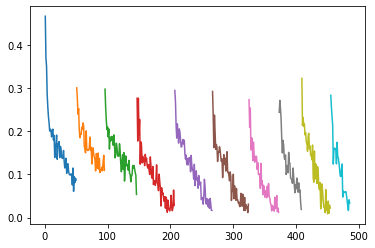

In [11]:
loss_plot(ewc_total_loss_optimised)

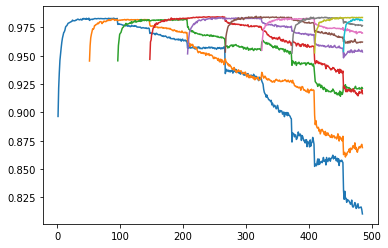

In [12]:
accuracy_plot(ewc_prec_optimised)

In [ ]:
#compare performance on first task:
fig = plt.figure(figsize = (20,10))
plt.ylim(0.65,1)
plt.plot(range(1, len(standard_prec_no_dropout_no_earlystopping)+1),
         standard_prec_no_dropout_no_earlystopping, label = 'std_no_drop_no_stop')
plt.plot(range(1, len(ewc_prec_no_dropout_no_earlystopping)+1),
         ewc_prec_no_dropout_no_earlystopping, label = 'ewc_no_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropout_no_earlystopping)+1),
         standard_prec_dropout_no_earlystopping, label = 'std_drop_no_stop')
plt.plot(range(1, len(ewc_prec_dropout_no_earlystopping)+1),
         ewc_prec_dropout_no_earlystopping, label = 'ewc_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropopout_earlystopping)+1),
         standard_prec_dropout_earlystopping, label = 'std_drop_stop')
plt.plot(range(1, len(ewc_prec_dropout_earlystopping)+1),
         ewc_prec_dropout_earlystopping, label = 'ewc_drop_stop')
plt.plot(range(1, len(standard_prec_optimised)+1),
         standard_prec_optimised, label = 'std_opt')
plt.plot(range(1, len(ewc_prec_optimised)+1),
         ewc_prec_optimised, label = 'ewc_opt')
plt.legend()

In [ ]:
lamda = 2000
lr = 1.e-2
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised2 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised2, 
 ewc_total_loss_optimised2,
 ewc_ce_loss_optimised2, 
 ewc_ewc_loss_optimised2) =train(
    mlp_consolidation_optimised2, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.6354 | loss => ce: 1.821 / ewc: 0.0 / total: 1.821: : 469it [00:05, 90.25it/s] 
=> task: 1/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.8021 | loss => ce: 0.8077 / ewc: 0.0 / total: 0.8077: : 469it [00:04, 94.30it/s] 
=> task: 1/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.556 / ewc: 0.0 / total: 0.556: : 469it [00:05, 92.35it/s]   
=> task: 1/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4744 / ewc: 0.0 / total: 0.4744: : 469it [00:05, 80.04it/s]
=> task: 1/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.4346 / ewc: 0.0 / total: 0.4346: : 469it [00:05, 84.82it/s] 
=> task: 1/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.4096 / ewc: 0.0 / total: 0.4096: : 469it [00:06, 77.32it/s]  
=> task: 1/10 | epoch: 7/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss =

=> task: 1/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2024 / ewc: 0.0 / total: 0.2024: : 469it [00:05, 84.85it/s] 
=> task: 1/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.201 / ewc: 0.0 / total: 0.201: : 469it [00:05, 82.87it/s]    
=> task: 1/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1996 / ewc: 0.0 / total: 0.1996: : 469it [00:05, 81.72it/s]  
=> task: 1/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1981 / ewc: 0.0 / total: 0.1981: : 469it [00:06, 74.58it/s] 
=> task: 1/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1967 / ewc: 0.0 / total: 0.1967: : 469it [00:05, 78.78it/s] 
=> task: 1/10 | epoch: 58/60 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1954 / ewc: 0.0 / total: 0.1954: : 469it [00:06, 77.36it/s] 
=> task: 1/10 | epoch: 59/60 | progress: [60032/60000] (100%) | prec: 0.97

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4267 / ewc: 0.05552 / total: 0.4822: : 469it [00:08, 56.37it/s] 
=> task: 2/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3624 / ewc: 0.04221 / total: 0.4046: : 469it [00:07, 61.64it/s] 
=> task: 2/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3295 / ewc: 0.03583 / total: 0.3653: : 469it [00:07, 58.85it/s]
=> task: 2/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3077 / ewc: 0.03194 / total: 0.3396: : 469it [00:07, 58.88it/s]
=> task: 2/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2919 / ewc: 0.02928 / total: 0.3212: : 469it [00:08, 56.42it/s] 
=> task: 2/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2796 / ewc: 0.02733 / total: 0.307: : 469it [00:07, 61.44it/s]  
=> task: 2/10 | epoch: 7/60 | progress: [60032/60000] (100%) 

=> task: 2/10 | epoch: 52/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1905 / ewc: 0.01299 / total: 0.2035: : 469it [00:08, 58.56it/s]  
=> task: 2/10 | epoch: 53/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1901 / ewc: 0.01291 / total: 0.203: : 469it [00:08, 55.44it/s]   
=> task: 2/10 | epoch: 54/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1896 / ewc: 0.01284 / total: 0.2024: : 469it [00:08, 52.83it/s] 
=> task: 2/10 | epoch: 55/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1891 / ewc: 0.01277 / total: 0.2019: : 469it [00:08, 52.99it/s]  
=> task: 2/10 | epoch: 56/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1887 / ewc: 0.01269 / total: 0.2014: : 469it [00:08, 57.35it/s]  
=> task: 2/10 | epoch: 57/60 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1882 / ewc: 0.01263 / total: 0.2008: : 469it [00:08, 54.66it/s]  
=> task: 2/10 | epoch: 58/60 | progress: [60032

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/10 | epoch: 1/60 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4597 / ewc: 0.06488 / total: 0.5246: : 469it [00:07, 58.88it/s]
=> task: 3/10 | epoch: 2/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3821 / ewc: 0.04684 / total: 0.4289: : 469it [00:06, 68.26it/s]
=> task: 3/10 | epoch: 3/60 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3473 / ewc: 0.03833 / total: 0.3857: : 469it [00:06, 71.32it/s] 
=> task: 3/10 | epoch: 4/60 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3248 / ewc: 0.03325 / total: 0.358: : 469it [00:07, 60.58it/s]  
=> task: 3/10 | epoch: 5/60 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.308 / ewc: 0.02981 / total: 0.3378: : 469it [00:07, 60.72it/s]  
=> task: 3/10 | epoch: 6/60 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.295 / ewc: 0.02728 / total: 0.3223: : 469it [00:07, 60.84it/s]   
=> task: 3/10 | epoch: 7/60 | progress: [60032/60000] (100%)

In [ ]:
loss_plot(ewc_total_loss_optimised2)

In [ ]:
accuracy_plot(ewc_prec_optimised)